# rank-order-optim

## Optimization of global structure through Rank-order correlation

In this Notebook, we perform optimization experiments on 6 datasets aiming to find the set of hiperparameters that allow for the highest Rank-order correlation between the orderings of cluster distances in the high-dimensional and low-dimensional embeddings.

## Tools & Libraries

We use **`Python`**. The following modules are used:

* **pandas:** reading, writing and manipulating data.
* **numpy:** vectorized calculations and other relevant math functions.
* **scipy:** functions for scientific purposes. Great statistics content.
* **matplotlib & seaborn:** data visualization.
* **sklearn:** comprehensive machine learning libraries.
* **hyperopt:** random search and TPE for hyperparameter optimization.
* **BayesianOptimization:** Gaussian Processes.

In [2]:
# opening up a console as the notebook starts
%qtconsole

# making plots stay on the notebook (no extra windows!)
%matplotlib inline

# show figures with highest resolution 
%config InlineBackend.figure_format = 'retina'

# changing working directory
import os
os.chdir('C:\\Users\\Guilherme\\Documents\\TCC\\tsne-optim')

# importing modules
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import png, array
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from bayes_opt import BayesianOptimization
from hyperopt import fmin, rand, tpe, hp, STATUS_OK, Trials
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import euclidean_distances

## 1. Search spaces

Let us define our hyperparameter search space, both for **`hyperopt`** and **`BayesianOptimization`**. Furthermore, we also define a **baseline** set of parameters, used by Maaten et. al. in the [2008 paper](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) that first proposed t-SNE.

In [2]:
# search space definition - hyperopt #

space_hp = {'perplexity': hp.quniform('perp', 2, 200, 1),
            'early_exaggeration': hp.uniform('exag', 1.0, 12.0),
            'learning_rate': hp.uniform('lr', 50, 1000),
            'n_iter': hp.quniform('ni', 200, 5000, 100),
            'angle': hp.uniform('angle', 0.2, 0.8),
            'pca_dims': hp.quniform('pca', 10, 100, 5),
            'whitening_flag': hp.choice('white', [True, False])}

In [3]:
# search space definition - bayesian optimzation #

space_bo = {'perplexity': (2, 200),
            'early_exaggeration': (1.0, 12.0),
            'learning_rate': (50, 1000),
            'n_iter': (200, 5000),
            'angle': (0.2,0.8),
            'pca_dims': (10, 100),
            'whitening_flag': (0.0, 1.0)}

In [4]:
# set of hyperparameters definition - baseline #

space_base = {'perplexity': 30,
              'early_exaggeration': 4.0,
              'learning_rate': 100,
              'n_iter': 1000,
              'angle': 0.5,
              'pca_dims': 30,
              'whitening_flag': False}

## 2. Target function

Let us define our optimization objective. Here we run t-SNE.

In [5]:
# defining cost function: KL divergence #

# the function takes a search space sample as parameter #
def optim_target(data, perplexity, early_exaggeration, learning_rate, n_iter, angle, pca_dims, whitening_flag, n_runs=3):    
    
    # setting random seed
    np.random.seed(42)
    
    # store target info
    target_var = data['TARGET']; data = data.drop('TARGET', axis=1)
    
    # HDBSCAN to compute clusters on high dimensional space
    # HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)
    clusterer_highd = HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)

    # clustering points
    cluster_assign_highd = clusterer_highd.fit_predict(PCA(n_components=100).fit_transform(data))        
    
    # PCA first to reduce data
    reducer = PCA(n_components=pca_dims, whiten=whitening_flag)
    
    # reducing
    reduced_data = reducer.fit_transform(data)
    
    # let us run t-SNE 5 times and get the best KL div #
    
    # divergence accumulator, initialize with +infinity
    KL_div = np.inf
    
    # loop for each t-SNE run
    for i in range(n_runs):
        
        # configuring t-SNE
        embedder = TSNE(perplexity=perplexity, early_exaggeration=early_exaggeration,
                        learning_rate=learning_rate, n_iter=n_iter,
                        angle=angle, random_state=i)
        
        # fitting
        temp_data = embedder.fit_transform(reduced_data)
    
        # KL divergence result after optimization
        temp_div = embedder.kl_divergence_
        
        # if smaller than last experiment, update
        if temp_div < KL_div:
            
            # updating values
            KL_div = temp_div
            embedded_data = temp_data
    
    # data frame form embedded_data
    embedded_data = pd.DataFrame({'x': zip(*embedded_data)[0], 'y': zip(*embedded_data)[1]})
    
    # computing ajusted mutual information over clusterings #

    # HDBSCAN to compute clusters on embedded space
    clusterer_lowd = HDBSCAN(min_cluster_size=10, min_samples=1, allow_single_cluster=True)

    # clustering points - low-dim
    cluster_assign_lowd = clusterer_lowd.fit_predict(embedded_data)

    # ajusted mutual info score
    AMI_score = adjusted_mutual_info_score(cluster_assign_highd, cluster_assign_lowd)
    
    # ajusted mutual info on target and dimensions
    AMI_target_highd = adjusted_mutual_info_score(target_var, cluster_assign_highd)
    AMI_target_lowd = adjusted_mutual_info_score(target_var, cluster_assign_lowd)

    # computing global geometry #
    
    # treating empty centers errors
    try:
        # centers on high dimensional space
        data['assignment'] = cluster_assign_highd; c_groups = data.groupby('assignment').mean()
        centers_highd = [np.array(c_groups.iloc[i,:]) for i in c_groups.index if not i == -1]

        # distances on high dimensional space
        dists_highd = euclidean_distances(centers_highd)
        closest_highd = [np.argsort(dists_highd[:,i])[1:] for i in range(dists_highd.shape[0])]
        closest_highd_df = pd.DataFrame(np.matrix(closest_highd))

        # centers on low dimensional space
        embedded_data['assignment'] = cluster_assign_highd; c_groups = embedded_data.groupby('assignment').mean()
        centers_lowd = [np.array(c_groups.iloc[i,:]) for i in c_groups.index if not i == -1]

        # distances on high dimensional space
        dists_lowd = euclidean_distances(centers_lowd)
        closest_lowd = [np.argsort(dists_lowd[:,i])[1:] for i in range(dists_lowd.shape[0])]
        closest_lowd_df = pd.DataFrame(np.matrix(closest_lowd))

        # correlations
        rank_order_cor = [spearmanr(closest_lowd_df.iloc[i,:], closest_highd_df.iloc[i,:]).correlation for i in closest_lowd_df.index]
        rank_order_cor_score = np.mean(rank_order_cor)
        
        # if missing value, make it -1.0
        if pd.isnull(rank_order_cor_score):
            rank_order_cor_score = -1.0
        
    # lowest value for rank-order corr if error
    except ValueError:
        rank_order_cor_score = -1.0
    
    # organizing parameters to return
    params = {'perplexity': perplexity,
              'early_exaggeration': early_exaggeration,
              'learning_rate': learning_rate,
              'n_iter': n_iter,
              'angle': angle,
              'pca_dims': pca_dims,
              'whitening_flag': whitening_flag}
    
    # adding target variable to embedded data
    embedded_data.loc[:,'target'] = target_var
    
    # printing results
    print 'KL divergence:', KL_div, '| AMI score:', AMI_score
    print 'AMI target-highd:', AMI_target_highd, '| AMI target-lowd:', AMI_target_lowd
    print 'Rank-order correlation:', rank_order_cor_score
    print 'Parameters:', params
    print ' '

    # returning values
    return KL_div, AMI_score, AMI_target_highd, AMI_target_lowd, rank_order_cor_score, embedded_data, params

In [6]:
# testing the function #

# let us use coil-20 dataset on baseline parameters
test_df = pd.read_csv('data/final/coil-20.csv')

# removing target variable
test_target = test_df['TARGET']

# running target function
kl_div, ami, ami_th, ami_tl, spearman, embed, params = optim_target(test_df, n_runs=1, **space_base)

KL divergence: 1.8724489212 | AMI score: 0.613024245036
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.593382676379
Rank-order correlation: 0.0554985754986
Parameters: {'whitening_flag': False, 'n_iter': 1000, 'pca_dims': 30, 'angle': 0.5, 'learning_rate': 100, 'early_exaggeration': 4.0, 'perplexity': 30}
 


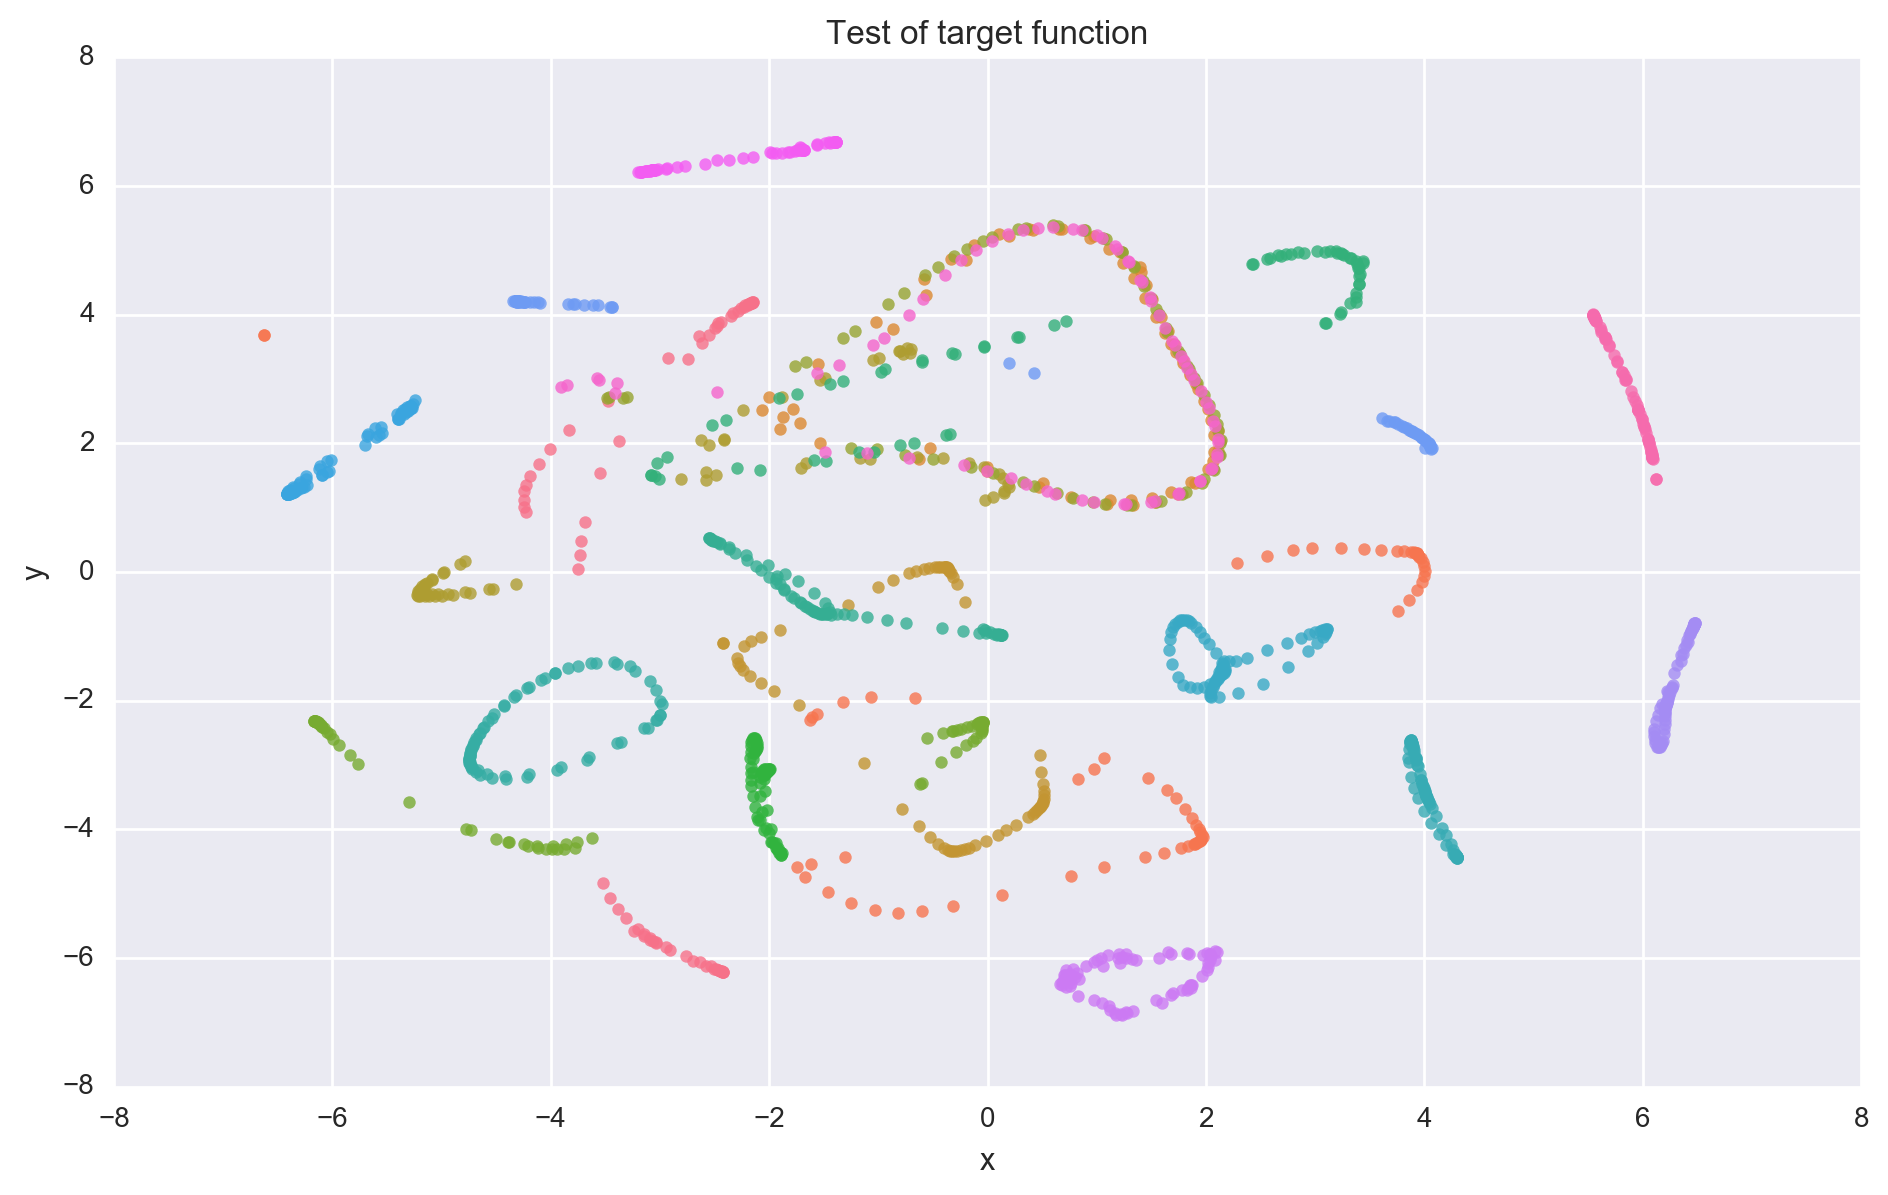

In [7]:
# let us study the result #
sns.lmplot(x='x', y='y', hue='target', data=embed, fit_reg=False, size=6, aspect=1.6, legend=False); plt.title('Test of target function');

## 3. Wrappers

We need to create wrappers for the target function, so it can work with the optimization packages we chose.

In [8]:
# wrapper for hyperopt #

# hyperopt minimizes functions, so our target value is set
class hp_wrapper:
    
    def __init__(self, data, save_path=None, n_runs=5):
        self.data = data
        self.save_path = save_path
        self.n_runs = n_runs
    
    def target(self, space):
        
        # pre-processing space
        space['pca_dims'] = int(space['pca_dims'])
        space['n_iter'] = int(space['n_iter'])
        
        # trying to ignore errors
        try:        
            # running target function
            kl_div, ami, ami_th, ami_tl, spearman, embed, params = optim_target(self.data, n_runs=self.n_runs, **space)    

            # if we want to save
            if not self.save_path == None:

                # creating path if necessary
                if not os.path.exists(self.save_path):
                    os.makedirs(self.save_path)

                # save name of the plot
                save_name = str(max([int(e.split('.')[0]) for e in os.listdir(self.save_path)]+[-1]) + 1) + '.png'

                # title of the plot
                plot_title = 'KL divergence: {0:.3f} | AMI score: {1:.3f} | AMI target-highd:'.format(kl_div, ami) + \
                             '{0:.3f} | AMI target-lowd: {1:.3f} | Rank-order correlation: {2:.3f}'.format(ami_th, ami_tl, spearman)

                # subtitle showing parameters
                subtitle = '{}'.format(params)

                # creating plot
                fig = sns.lmplot(x='x', y='y', hue='target', data=embed, fit_reg=False, size=9, aspect=1.6, legend=False); 
                plt.title(plot_title); plt.xlabel(subtitle)

                # saving
                fig.savefig(os.path.join(self.save_path,save_name))
                
                # do not show plot on jupyter
                plt.close()

            # a dict with 'loss' and 'status' is required
            return {'loss': -spearman,
                    'status': STATUS_OK,
                    'parameters': params,
                    'embedding': embed}
        
        # catching exception
        except Exception as e:
            print 'An Error occurred:', e
            
            # a dict with 'loss' and 'status' is required
            return {'loss': -1.0,
                    'status': 'fail',
                    'parameters': space,
                    'embedding': 'error'}


In [9]:
# wrapper for BayesianOptimization #

# we need to coerce some variables to int, as the gaussian process regression only works with floats
class bo_wrapper:
    
    def __init__(self, data, save_path=None, n_runs=5):
        self.data = data
        self.save_path = save_path
        self.n_runs = n_runs
        
    def target(self, perplexity, early_exaggeration, learning_rate, n_iter, angle, pca_dims, whitening_flag):
    
        # pre-processing space
        pca_dims = int(pca_dims)
        n_iter = int(n_iter)

        # proxy for whitening flag
        if whitening_flag < 0.50:
            whitening_flag = False
        else:
            whitening_flag = True
        
        # hadling errors
        try:
    
            # running target function
            kl_div, ami, ami_th, ami_tl, spearman, embed, params = optim_target(self.data, perplexity, early_exaggeration, 
                                                                                learning_rate, n_iter, angle, pca_dims, 
                                                                                whitening_flag, n_runs=self.n_runs)
            # if we want to save
            if not self.save_path == None:

                # creating path if necessary
                if not os.path.exists(self.save_path):
                    os.makedirs(self.save_path)

                # save name of the plot
                save_name = str(max([int(e.split('.')[0]) for e in os.listdir(self.save_path)]+[-1]) + 1) + '.png'

                # title of the plot
                plot_title = 'KL divergence: {0:.3f} | AMI score: {1:.3f} | AMI target-highd:'.format(kl_div, ami) + \
                             '{0:.3f} | AMI target-lowd: {1:.3f} | Rank-order correlation: {2:.3f}'.format(ami_th, ami_tl, spearman)

                # subtitle showing parameters
                subtitle = '{}'.format(params)

                # creating plot
                fig = sns.lmplot(x='x', y='y', hue='target', data=embed, fit_reg=False, size=9, aspect=1.6, legend=False); 
                plt.title(plot_title); plt.xlabel(subtitle)

                # saving
                fig.savefig(os.path.join(self.save_path,save_name))
                
                # do not show plot on jupyter
                plt.close()

            # retuning target value: negative because BO maximizes functions
            return spearman
        
        # catching exception
        except Exception as e:
            print 'An Error occurred:', e
            
            # a dict with 'loss' and 'status' is required
            return -1.0

In [10]:
# testing hyperopt wrapper
opt_task = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/test_figs', n_runs=1)
opt_task.target(space_base)['loss']

KL divergence: 1.8724489212 | AMI score: 0.613024245036
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.593382676379
Rank-order correlation: 0.0554985754986
Parameters: {'whitening_flag': False, 'n_iter': 1000, 'pca_dims': 30, 'angle': 0.5, 'learning_rate': 100, 'early_exaggeration': 4.0, 'perplexity': 30}
 


-0.055498575498575495

In [11]:
# testing bayes_opt wrapper
opt_task = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/test_figs', n_runs=1)
opt_task.target(**space_base)

KL divergence: 1.8724489212 | AMI score: 0.613024245036
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.593382676379
Rank-order correlation: 0.0554985754986
Parameters: {'whitening_flag': False, 'n_iter': 1000, 'pca_dims': 30, 'angle': 0.5, 'learning_rate': 100, 'early_exaggeration': 4.0, 'perplexity': 30}
 


0.055498575498575495

## 4. Optimization Tasks

Let us now create and execute our optimization tasks. We need to run 3 optimization procedures: Random Search, TPE and Gaussian Processes for 6 datasets. Let us divide our analysis by dataset.

In [12]:
# let us define an experiment dict #
# and index the results by dataset and optimization method #
# e.g. exp_dict['well_sep']['random_search'] refers to the results #
# of random search no the well-separated clusters data #

# defining dict
experiment_dict = dict()

# initializing dict
for dataset in ['well_sep', 'well_sep_noise', 'gaussian_noise', 'topology', 'coil_20', 'olivetti']:
    for optim in ['rand', 'tpe', 'gp']:
        try:
            experiment_dict[dataset][optim] = dict()
        except KeyError:
            experiment_dict[dataset] = dict()
            experiment_dict[dataset][optim] = dict()
            
# checking the result
experiment_dict

{'coil_20': {'gp': {}, 'rand': {}, 'tpe': {}},
 'gaussian_noise': {'gp': {}, 'rand': {}, 'tpe': {}},
 'olivetti': {'gp': {}, 'rand': {}, 'tpe': {}},
 'topology': {'gp': {}, 'rand': {}, 'tpe': {}},
 'well_sep': {'gp': {}, 'rand': {}, 'tpe': {}},
 'well_sep_noise': {'gp': {}, 'rand': {}, 'tpe': {}}}

### 4.1 Well-separated clusters

Set of 8 well-separated gaussian blobs in a 100-dimensional space.

In [13]:
# reading the data
test_df = pd.read_csv('data/final/well-sep.csv')

In [14]:
# storing target variable
test_target = test_df['TARGET']

In [15]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['well_sep']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

KL divergence: 0.689474821091 | AMI score: 1.0
AMI target-highd: 1.0 | AMI target-lowd: 1.0
Rank-order correlation: 0.116071428571
Parameters: {'whitening_flag': False, 'n_iter': 3100, 'pca_dims': 15, 'angle': 0.6888575033881257, 'learning_rate': 844.1395512832464, 'early_exaggeration': 5.743145526354907, 'perplexity': 31.0}
 
KL divergence: 0.0827879831195 | AMI score: 1.0
AMI target-highd: 1.0 | AMI target-lowd: 1.0
Rank-order correlation: 0.0892857142857
Parameters: {'whitening_flag': True, 'n_iter': 4200, 'pca_dims': 10, 'angle': 0.388244586408576, 'learning_rate': 450.1326340364166, 'early_exaggeration': 7.210504100204965, 'perplexity': 173.0}
 
KL divergence: 0.302831858397 | AMI score: 0.896352041418
AMI target-highd: 1.0 | AMI target-lowd: 0.896352041418
Rank-order correlation: 0.0357142857143
Parameters: {'whitening_flag': False, 'n_iter': 4400, 'pca_dims': 20, 'angle': 0.7032118655761674, 'learning_rate': 266.1696391985295, 'early_exaggeration': 7.405428408209977, 'perplexity

In [16]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['well_sep']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

KL divergence: 1.33179497719 | AMI score: 0.00310890462818
AMI target-highd: 1.0 | AMI target-lowd: 0.00310890462818
Rank-order correlation: -0.142857142857
Parameters: {'whitening_flag': True, 'n_iter': 4200, 'pca_dims': 55, 'angle': 0.3092340286821289, 'learning_rate': 827.6010169859494, 'early_exaggeration': 5.443792648093993, 'perplexity': 55.0}
 
KL divergence: 1.62385773659 | AMI score: 0.00670186356376
AMI target-highd: 1.0 | AMI target-lowd: 0.00670186356376
Rank-order correlation: 0.0892857142857
Parameters: {'whitening_flag': True, 'n_iter': 4100, 'pca_dims': 95, 'angle': 0.29657063761326635, 'learning_rate': 728.2853906803106, 'early_exaggeration': 5.772273725728525, 'perplexity': 54.0}
 
KL divergence: 0.0127831883729 | AMI score: 0.85082363381
AMI target-highd: 1.0 | AMI target-lowd: 0.85082363381
Rank-order correlation: 0.191964285714
Parameters: {'whitening_flag': False, 'n_iter': 3400, 'pca_dims': 95, 'angle': 0.4829523460748746, 'learning_rate': 524.7871258740431, 'ear

In [17]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['well_sep']['gp'] = bo.res['all']

KL divergence: 1.040807724 | AMI score: 1.0
AMI target-highd: 1.0 | AMI target-lowd: 1.0
Rank-order correlation: -0.165178571429
Parameters: {'whitening_flag': False, 'n_iter': 4239, 'pca_dims': 76, 'angle': 0.51312454837012256, 'learning_rate': 753.77955105363696, 'early_exaggeration': 7.4377832125825067, 'perplexity': 21.674788549423887}
 
KL divergence: 1.40806722641 | AMI score: 0.00589275028398
AMI target-highd: 1.0 | AMI target-lowd: 0.00589275028398
Rank-order correlation: -0.232142857143
Parameters: {'whitening_flag': True, 'n_iter': 1677, 'pca_dims': 78, 'angle': 0.61268801773906123, 'learning_rate': 348.96800012138823, 'early_exaggeration': 1.0292185538935601, 'perplexity': 91.132262767027285}
 
KL divergence: 0.860722124577 | AMI score: 0.981657869168
AMI target-highd: 1.0 | AMI target-lowd: 0.981657869168
Rank-order correlation: -0.370535714286
Parameters: {'whitening_flag': True, 'n_iter': 2196, 'pca_dims': 40, 'angle': 0.5567790770152542, 'learning_rate': 270.419211259782

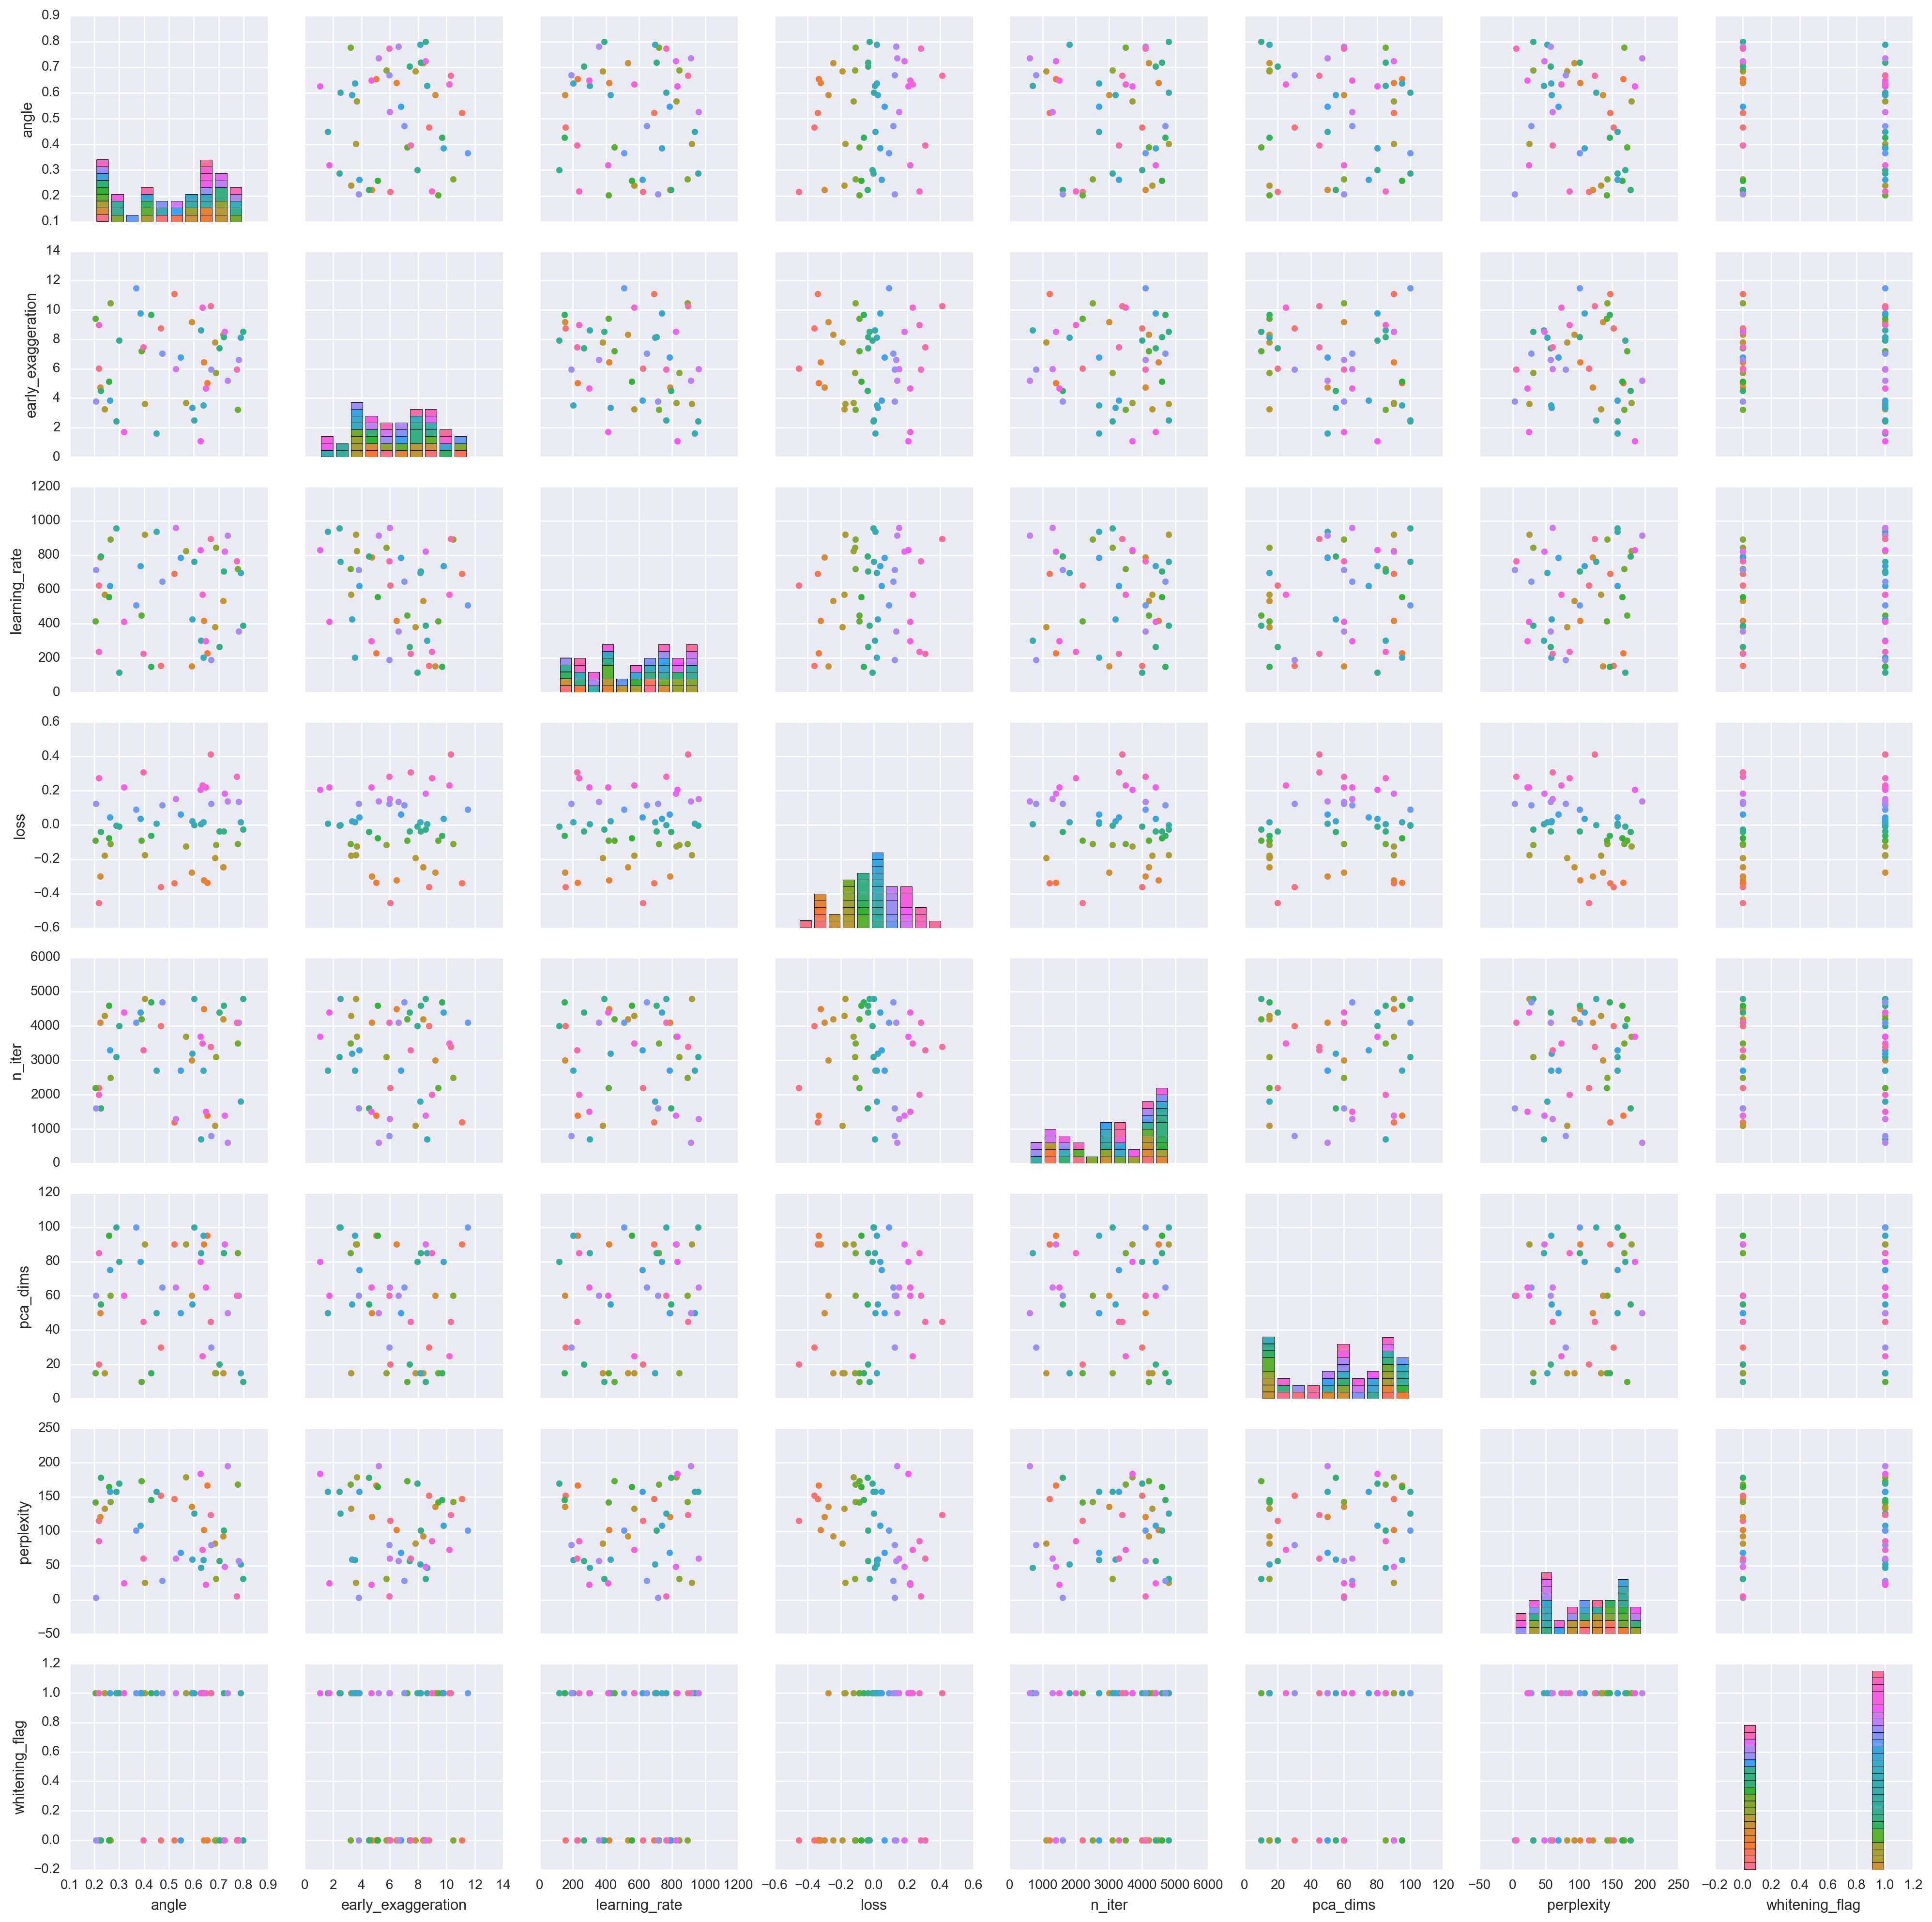

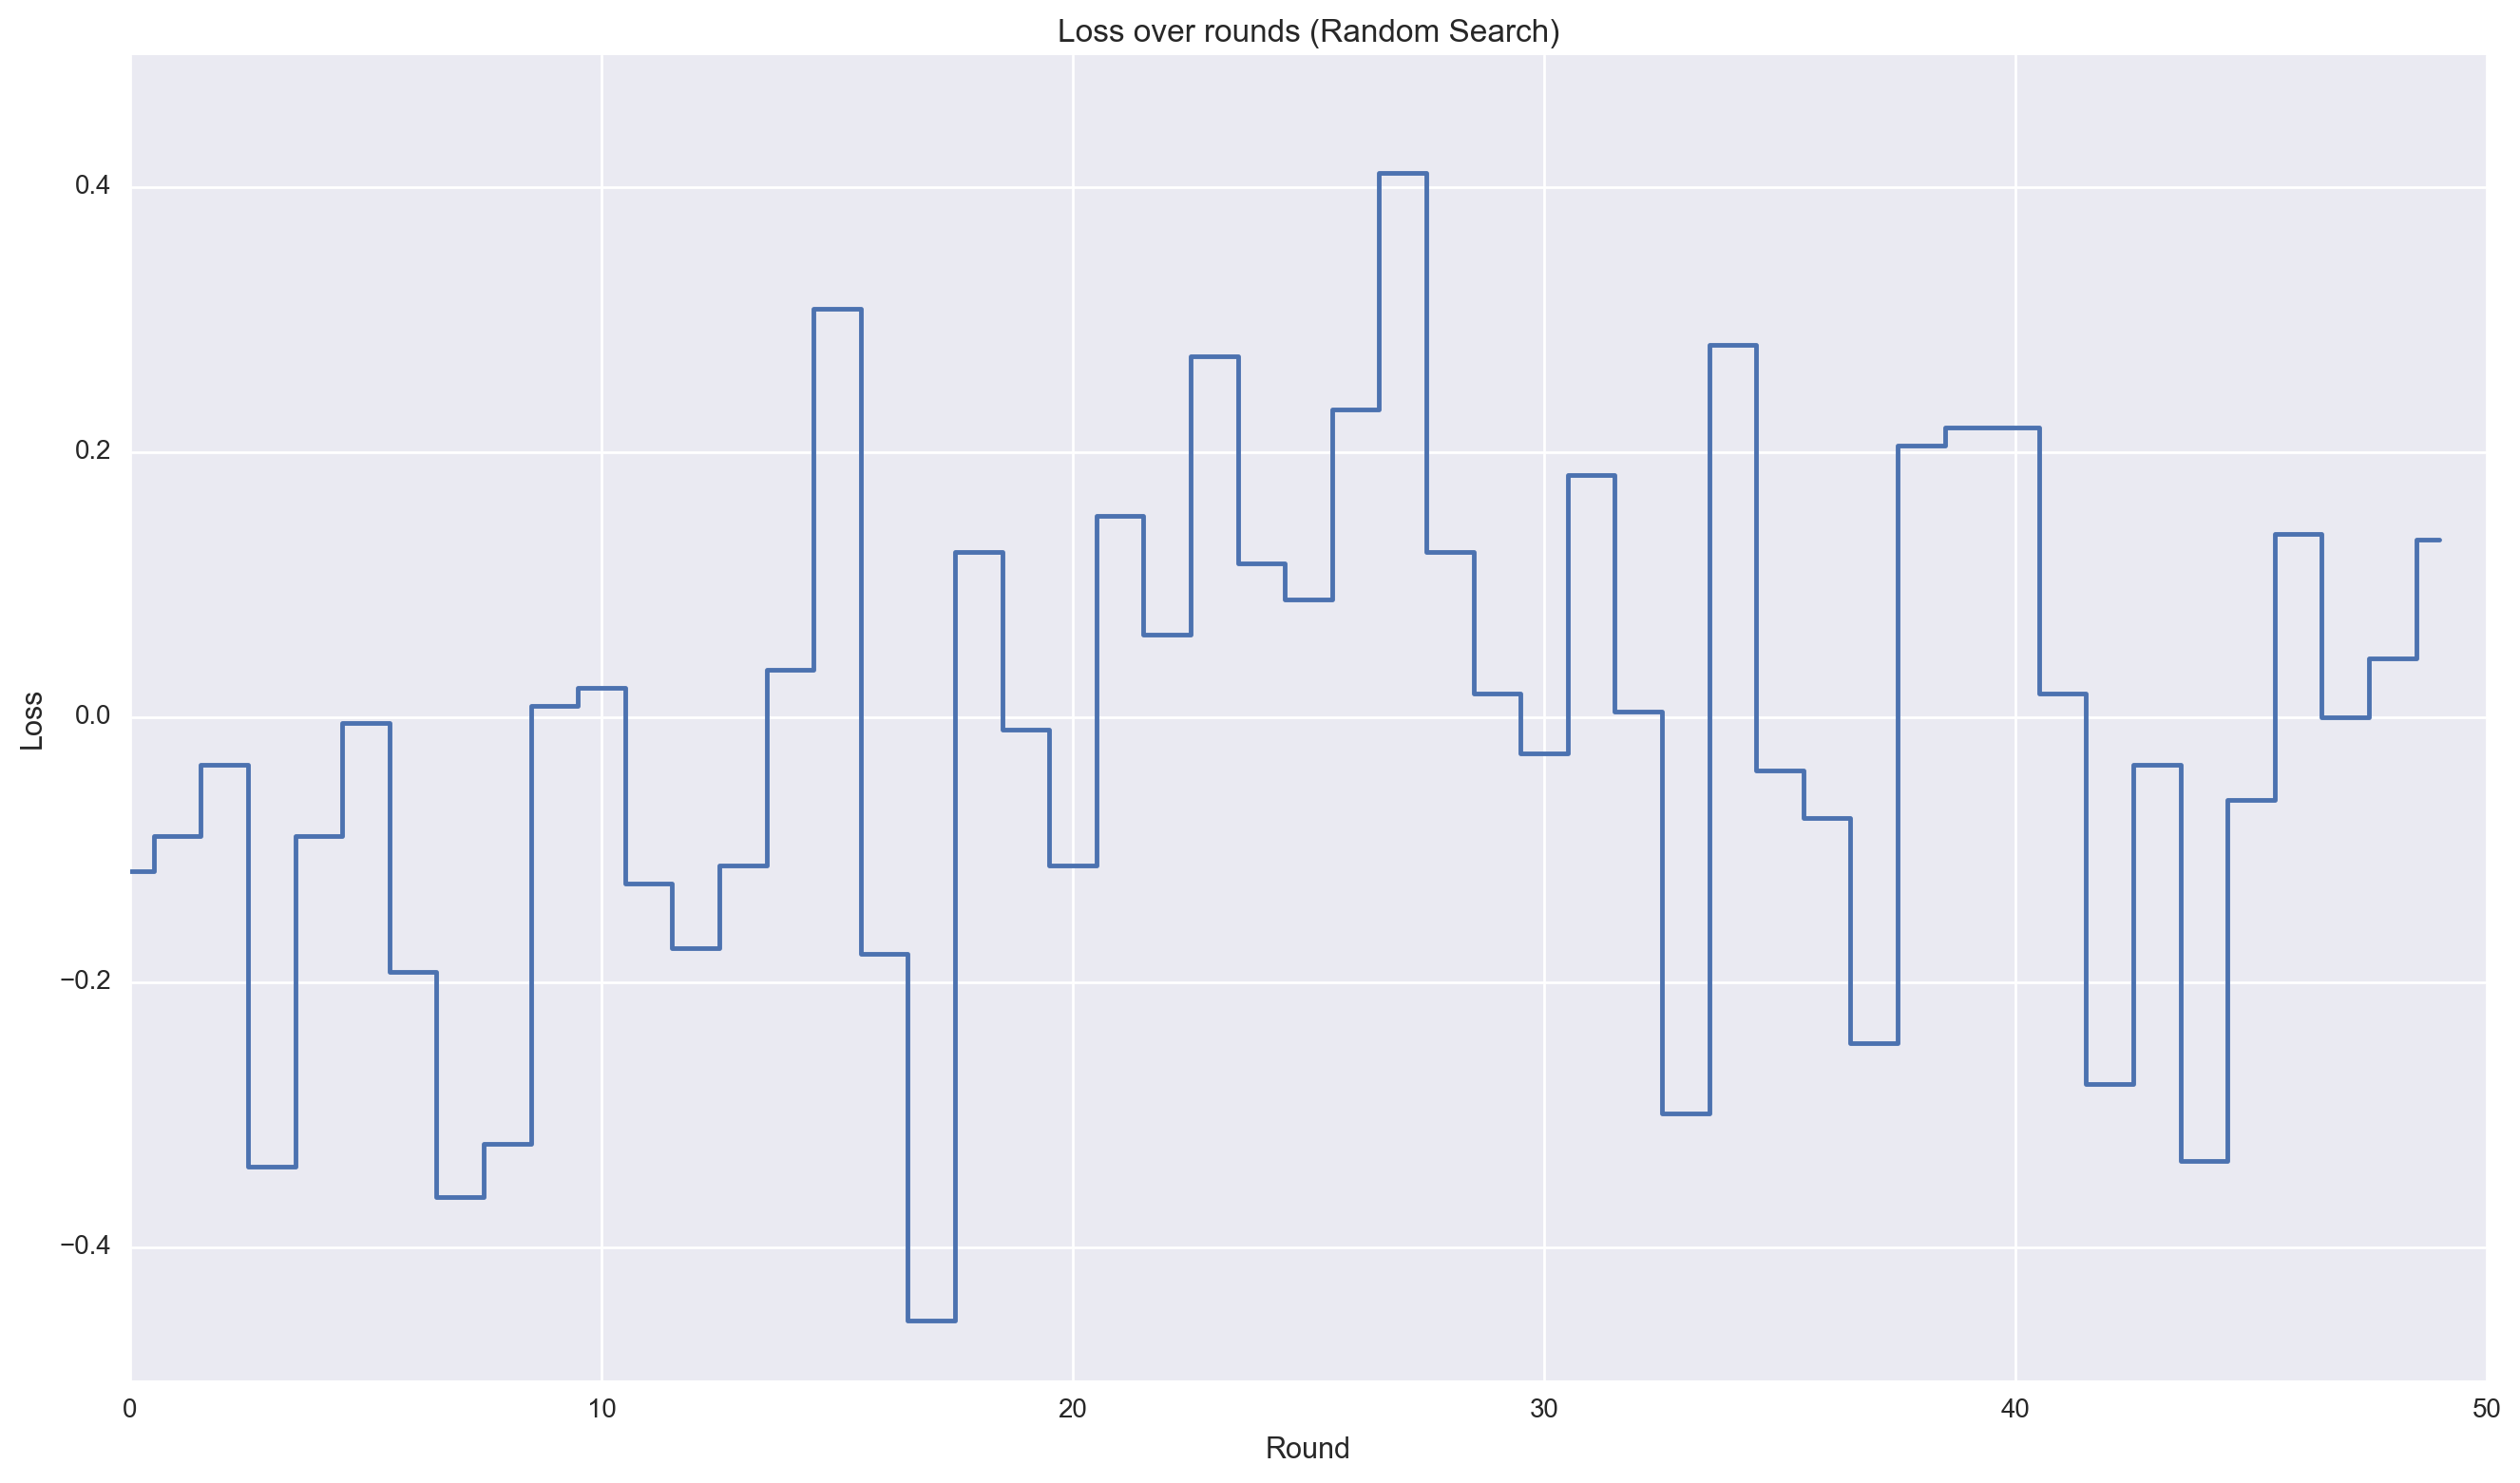

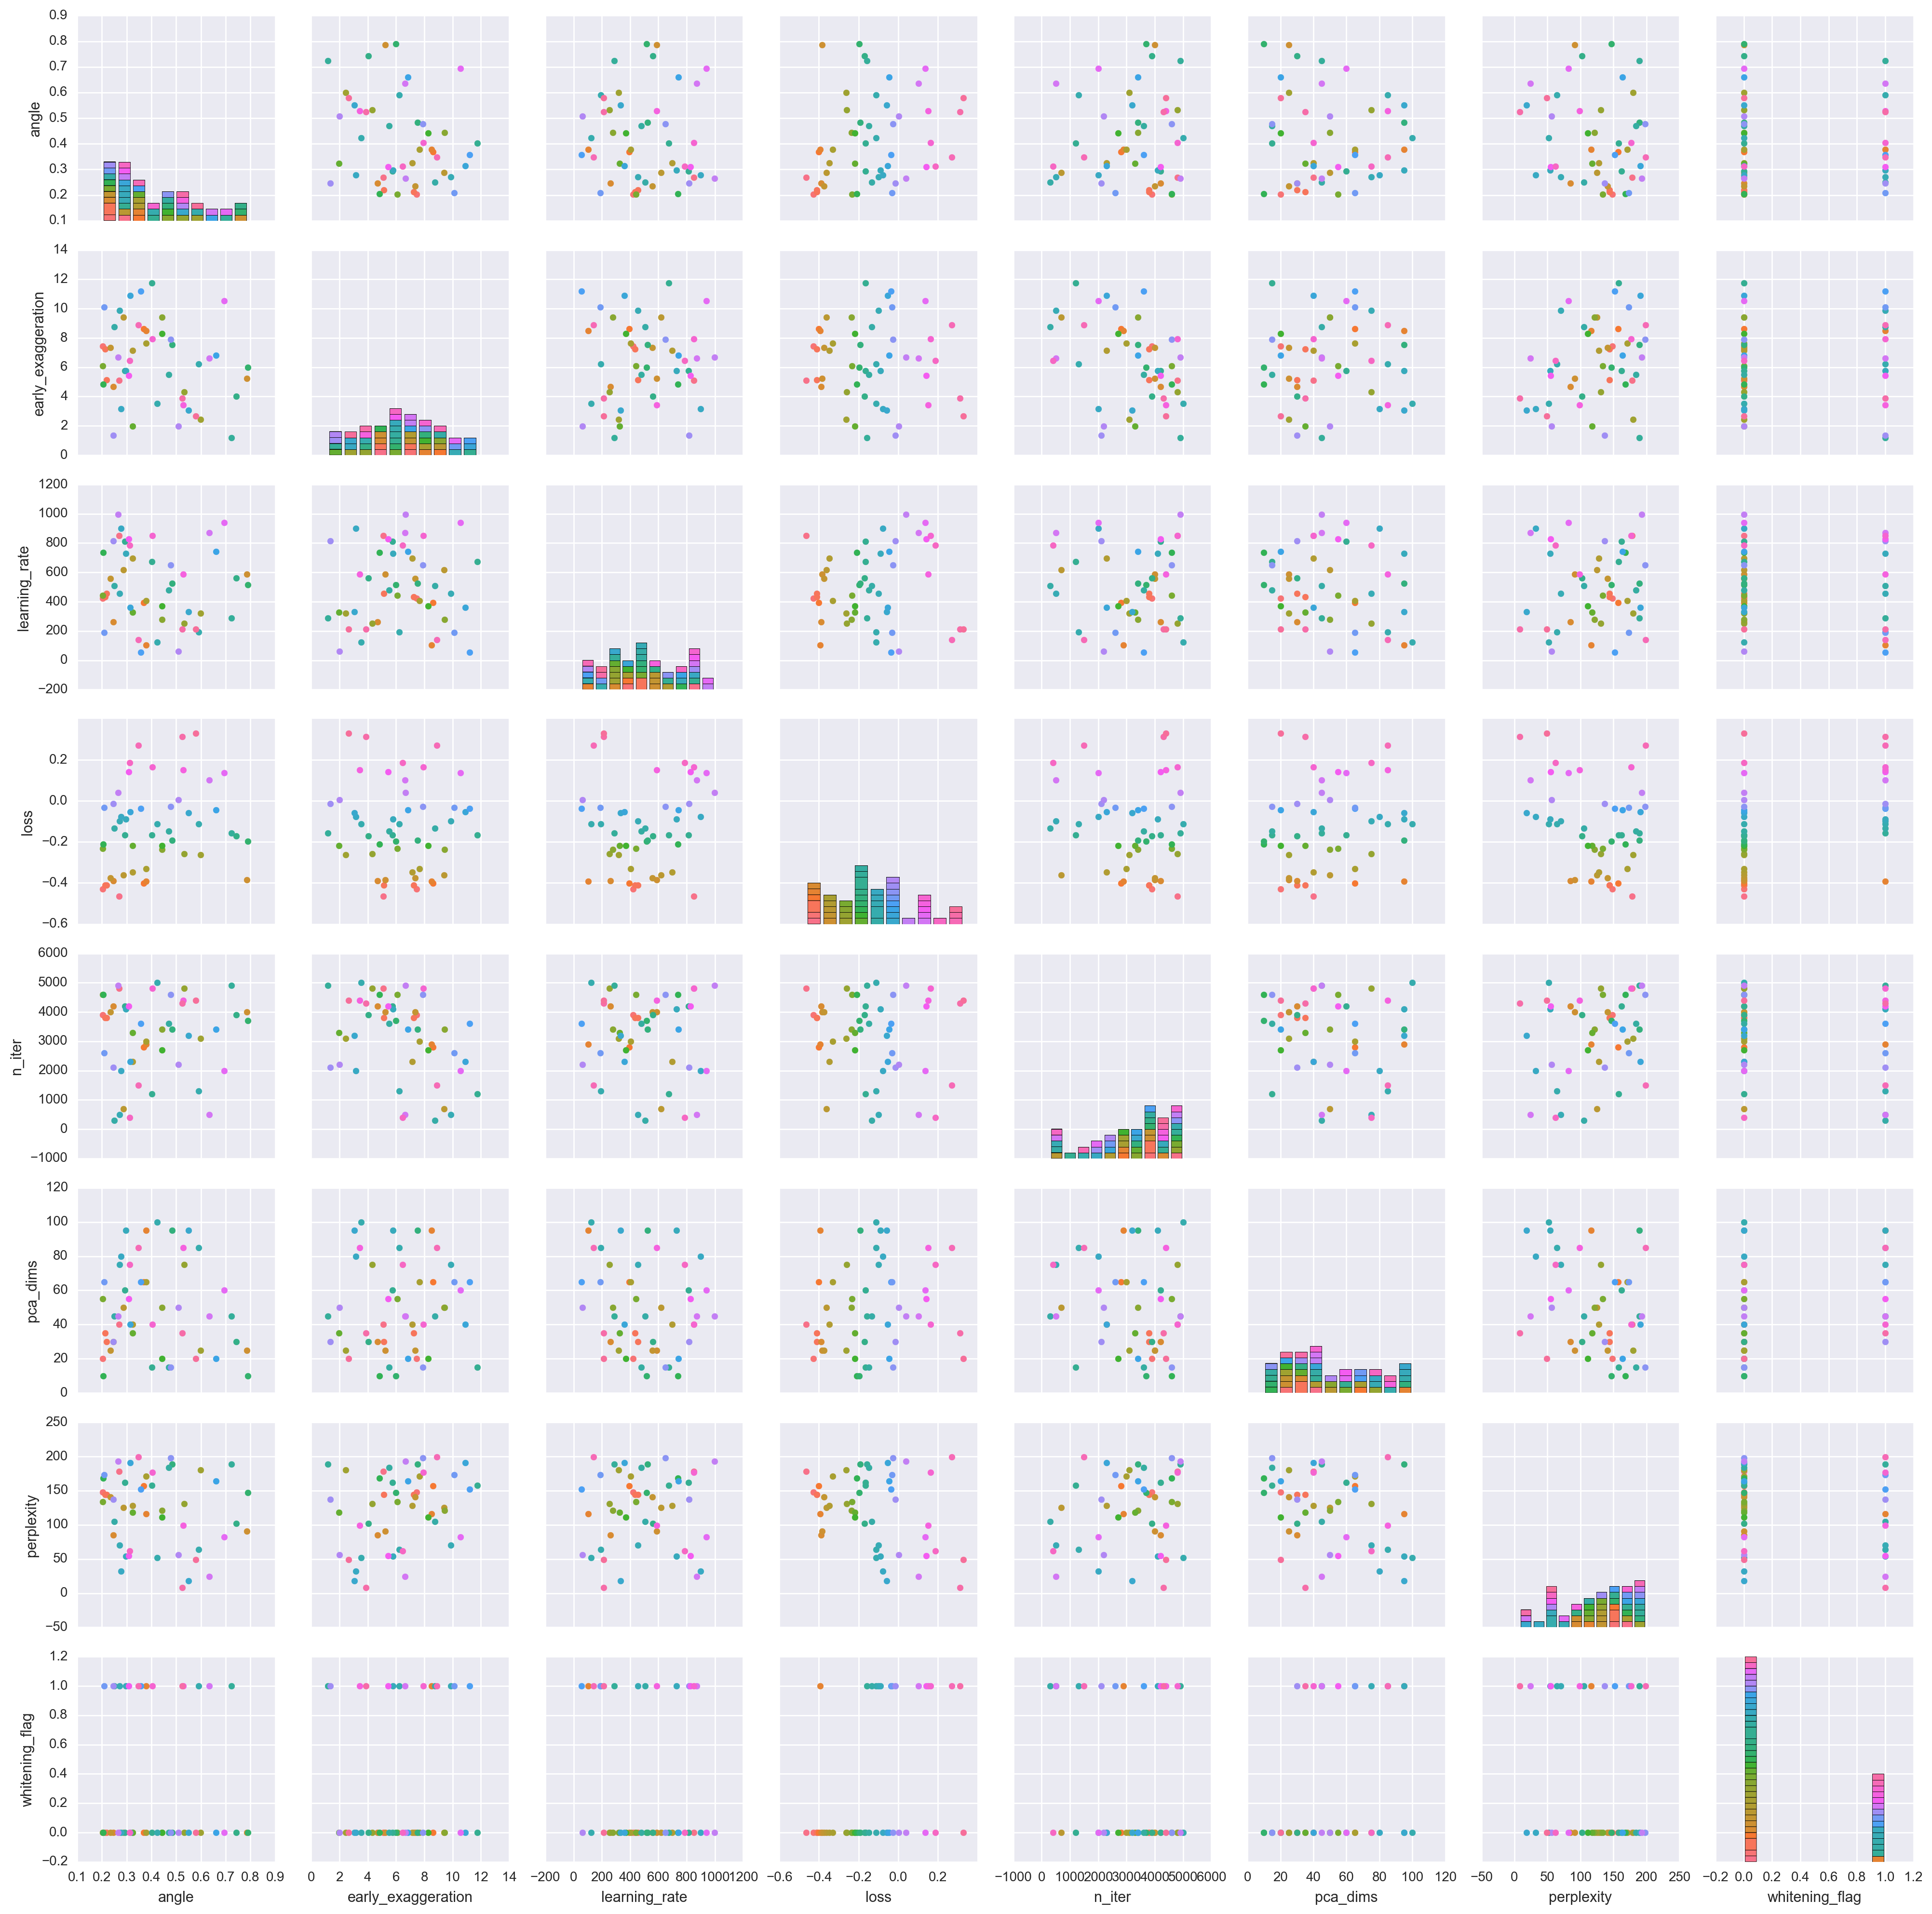

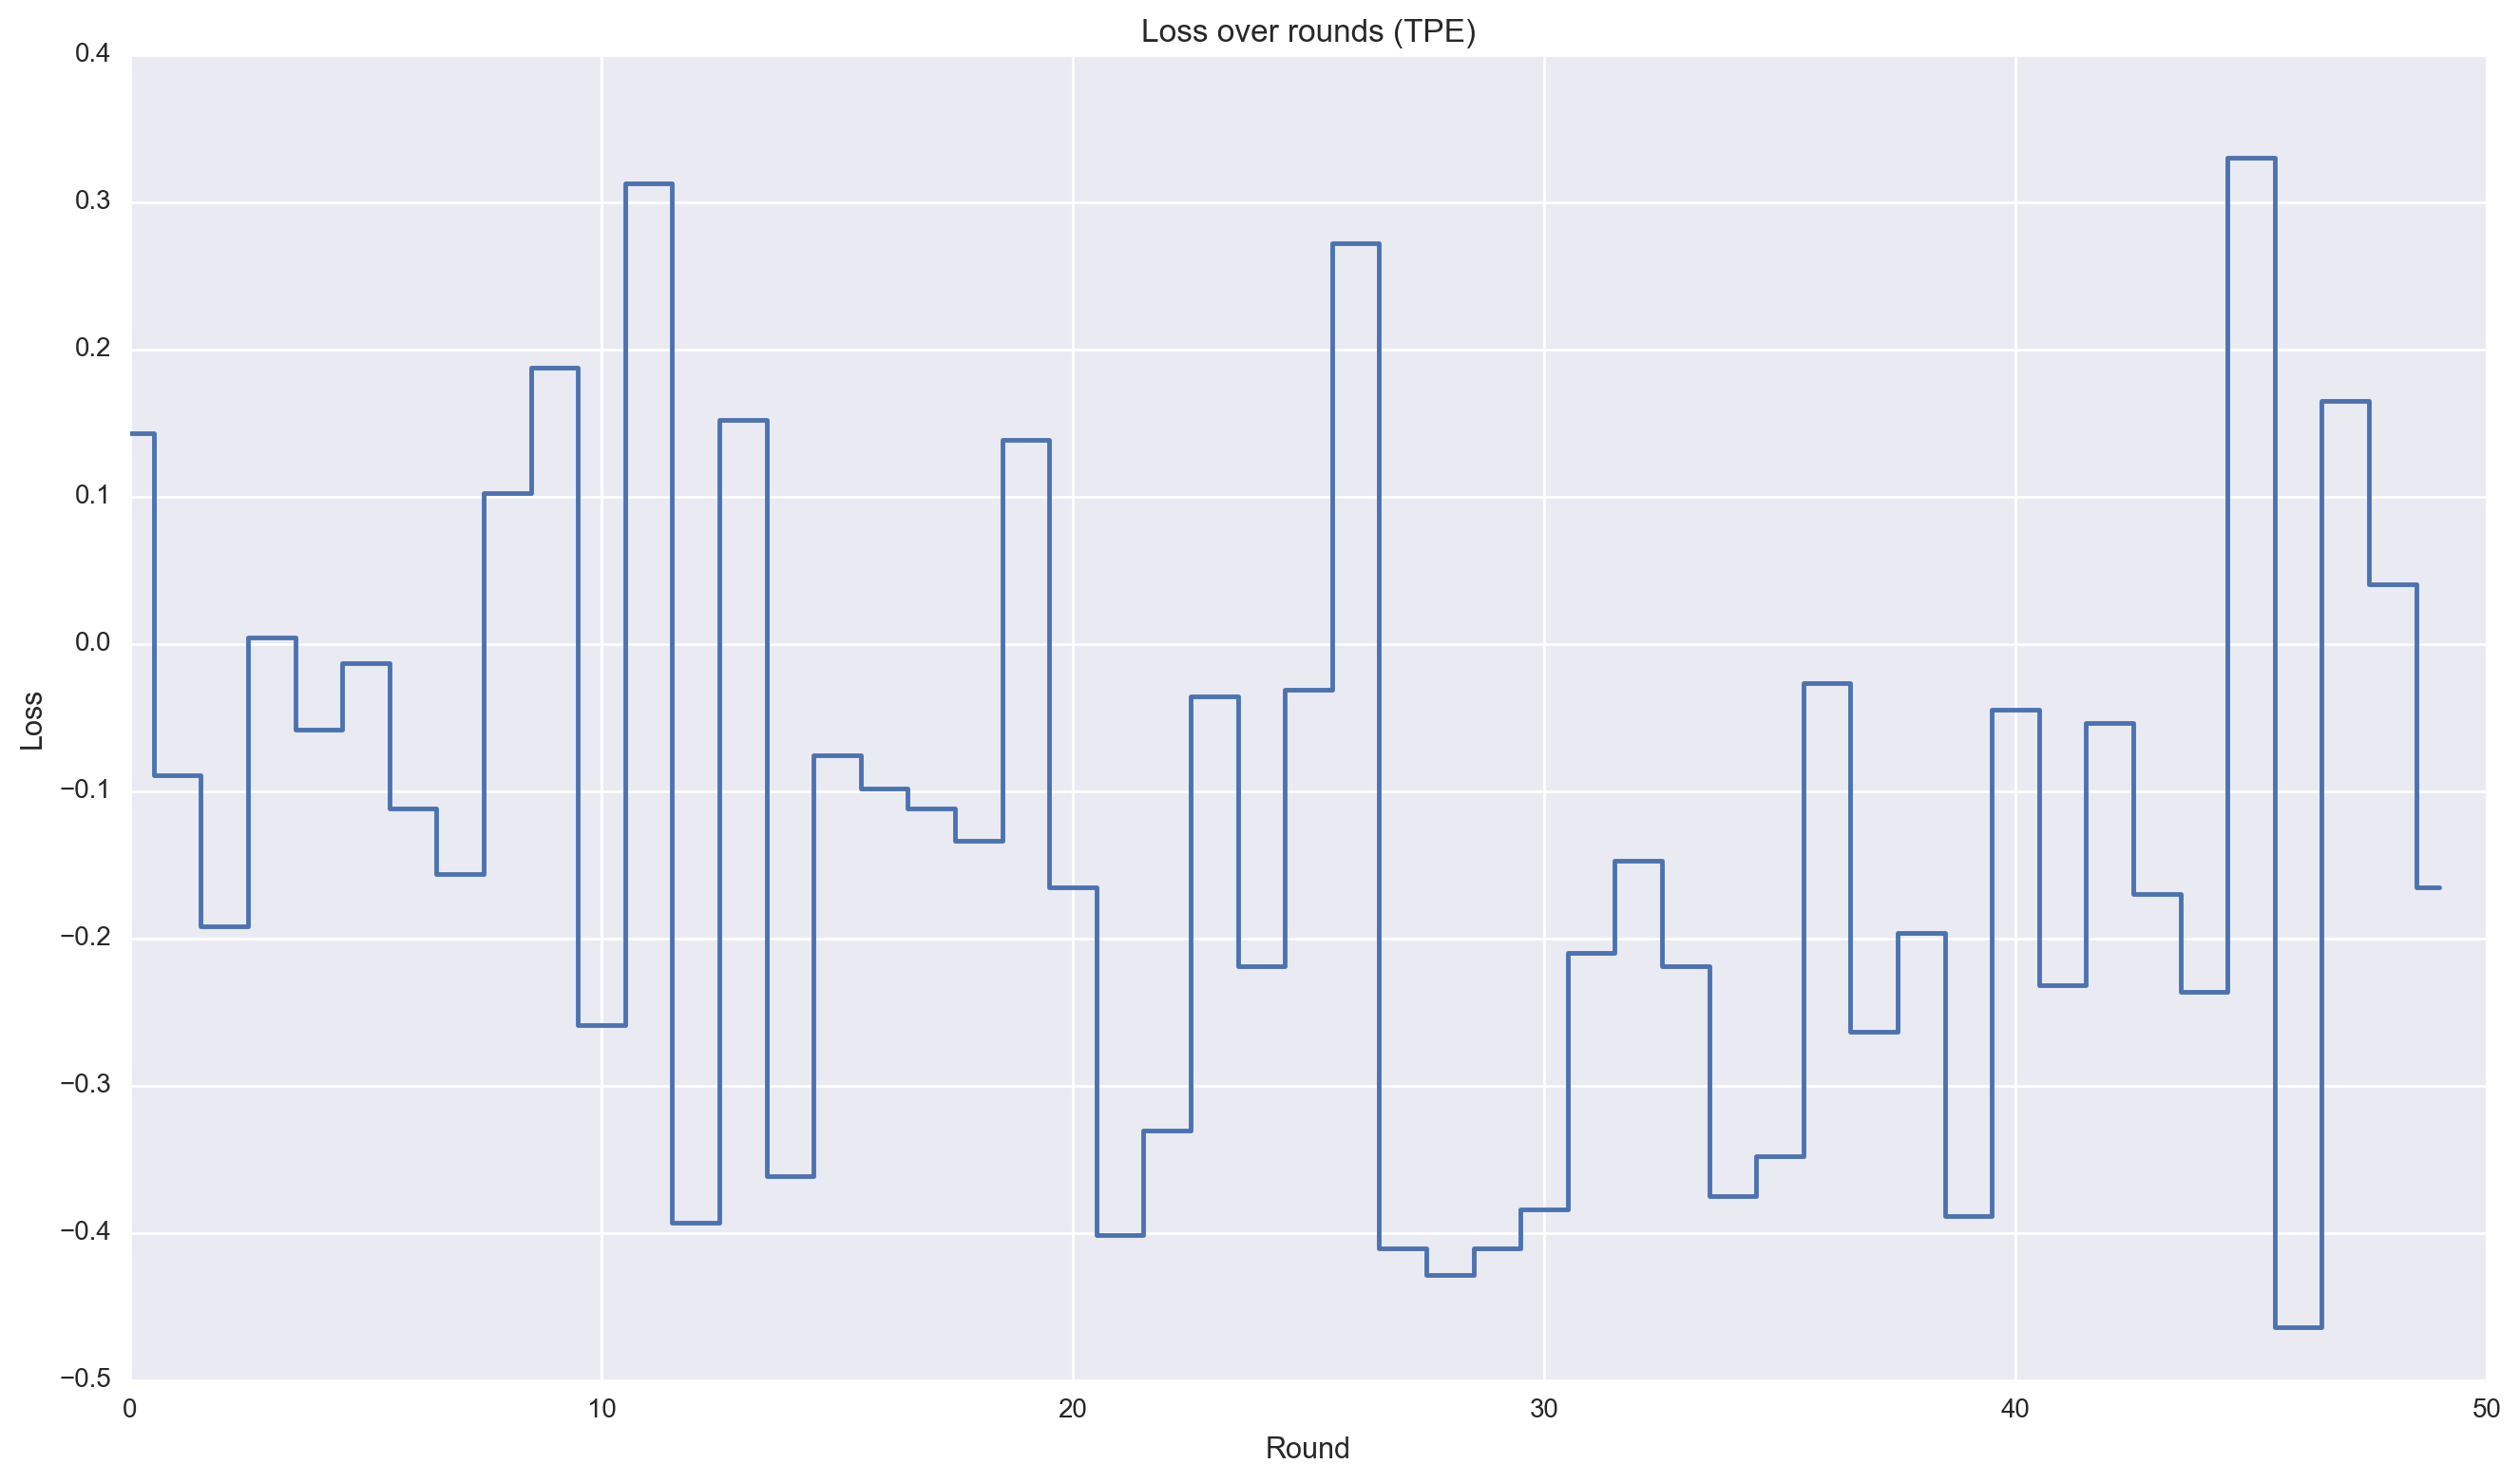

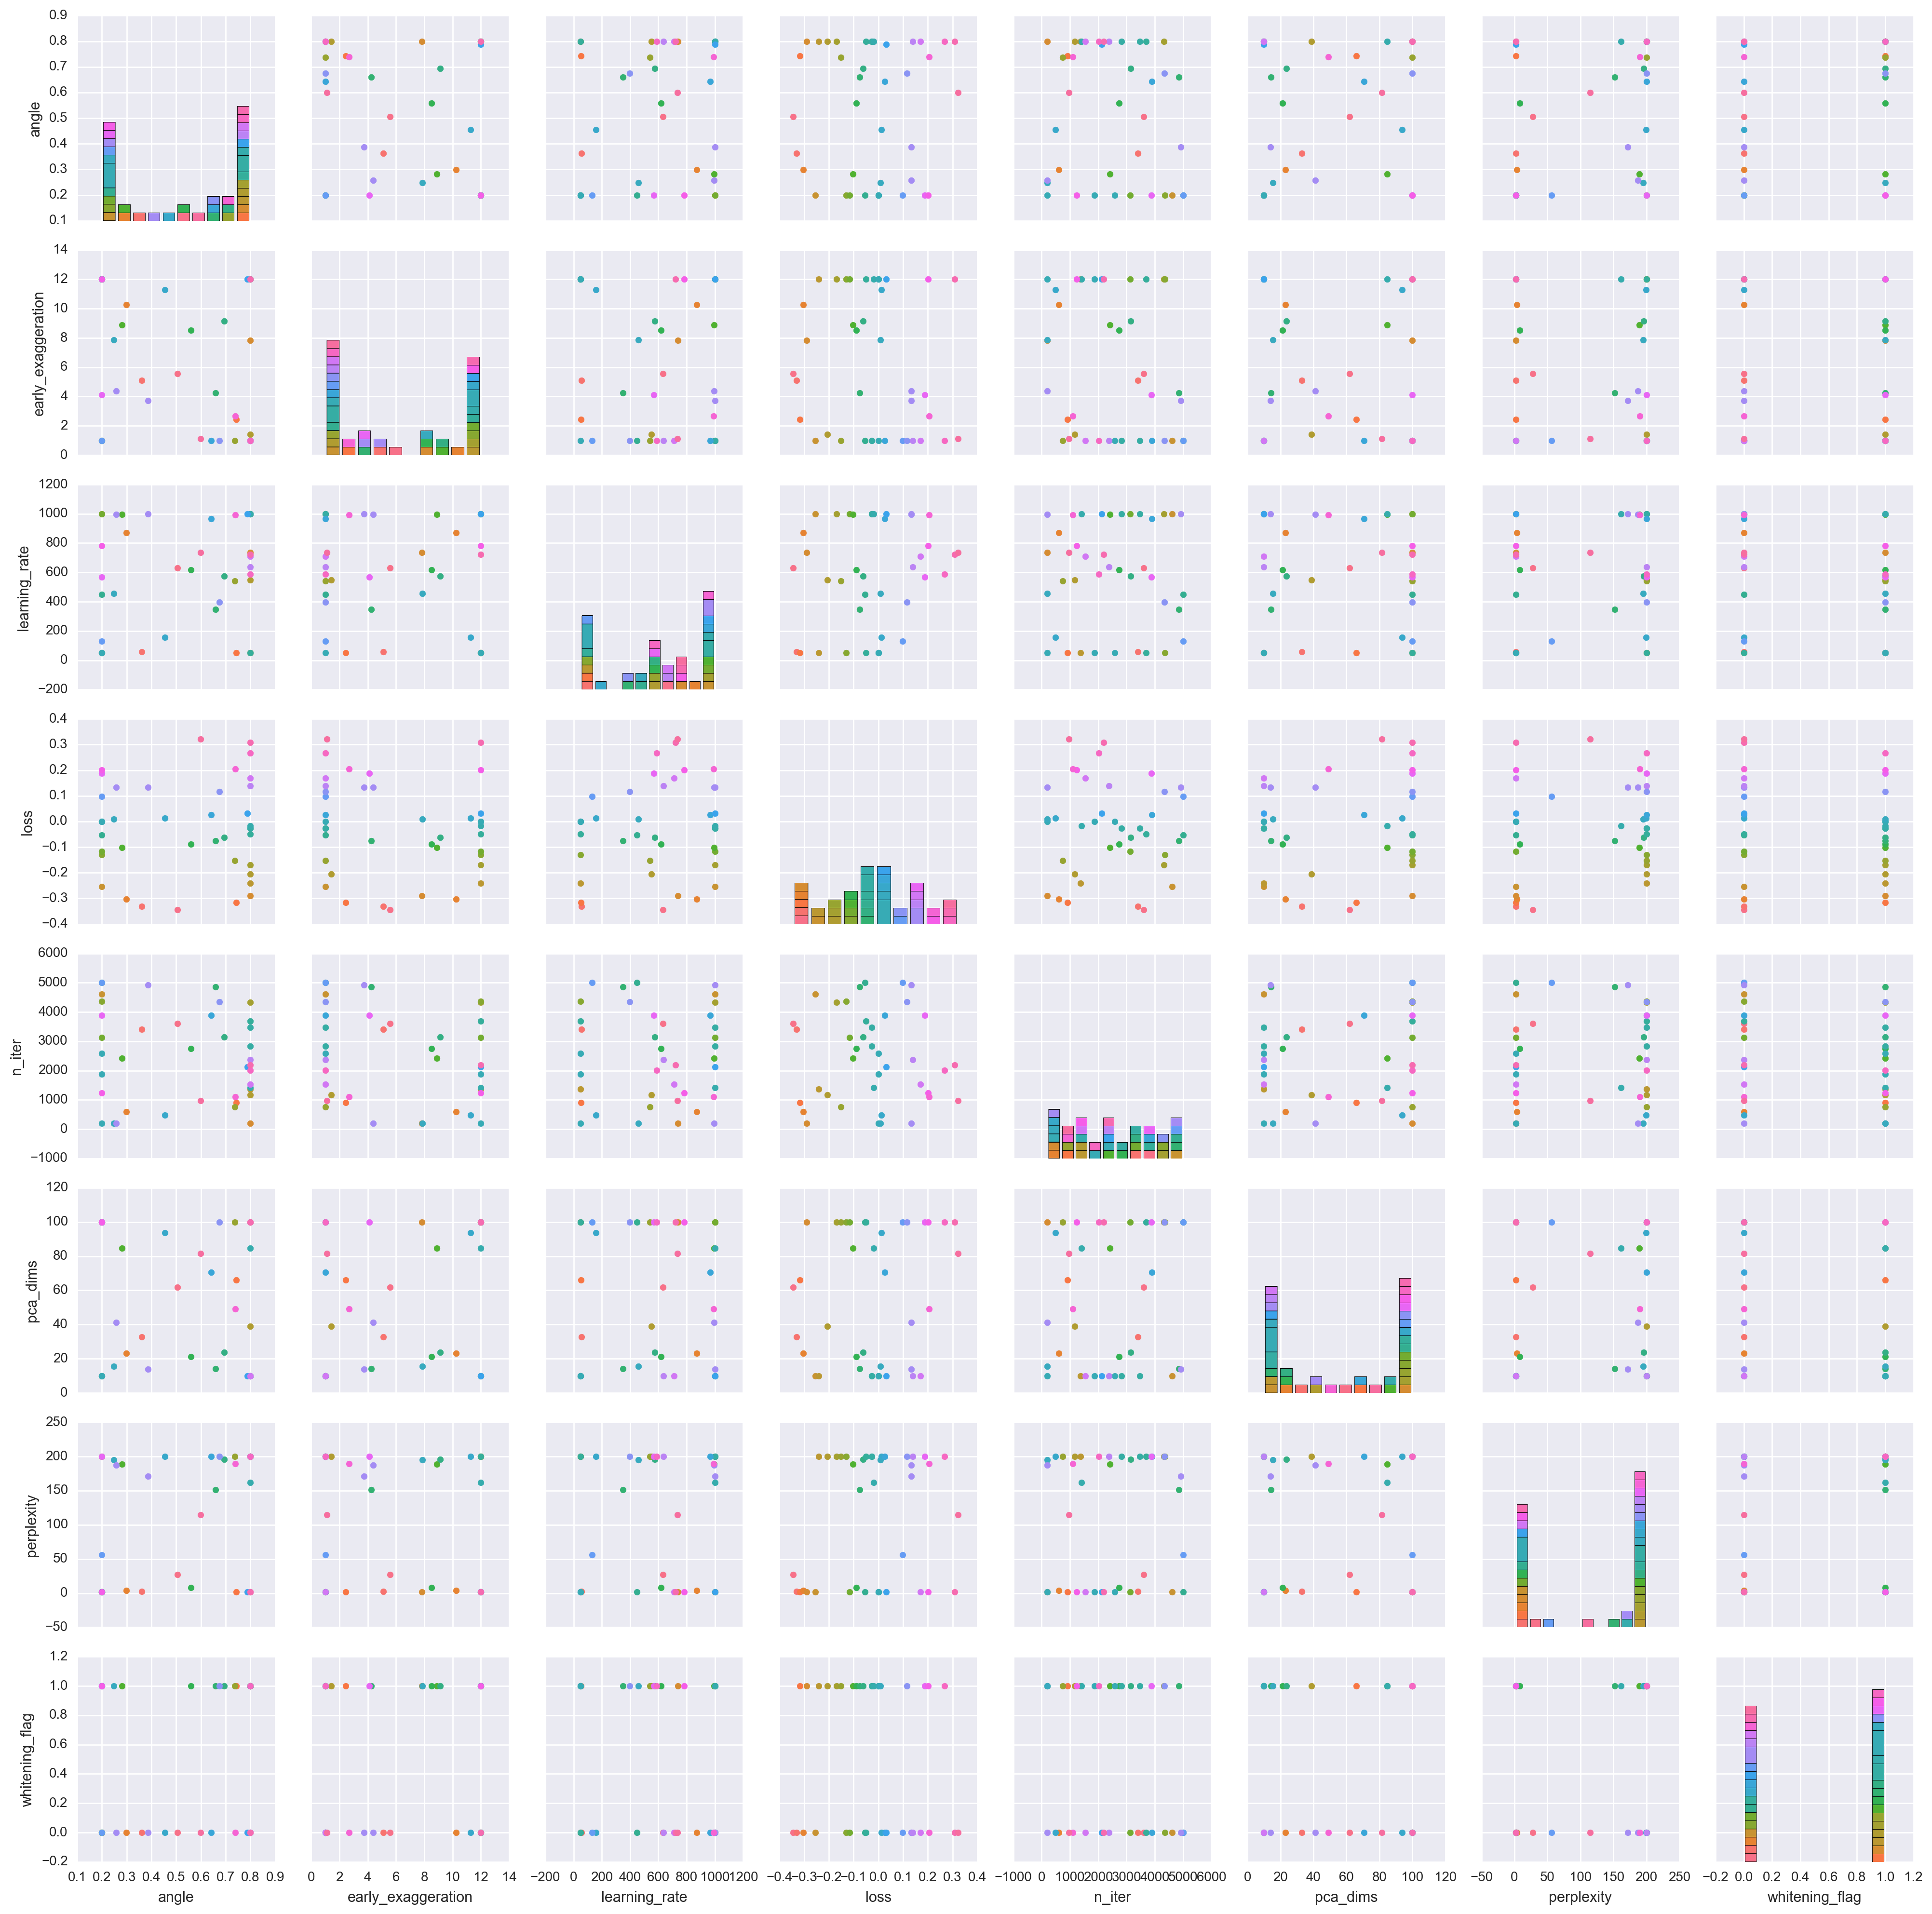

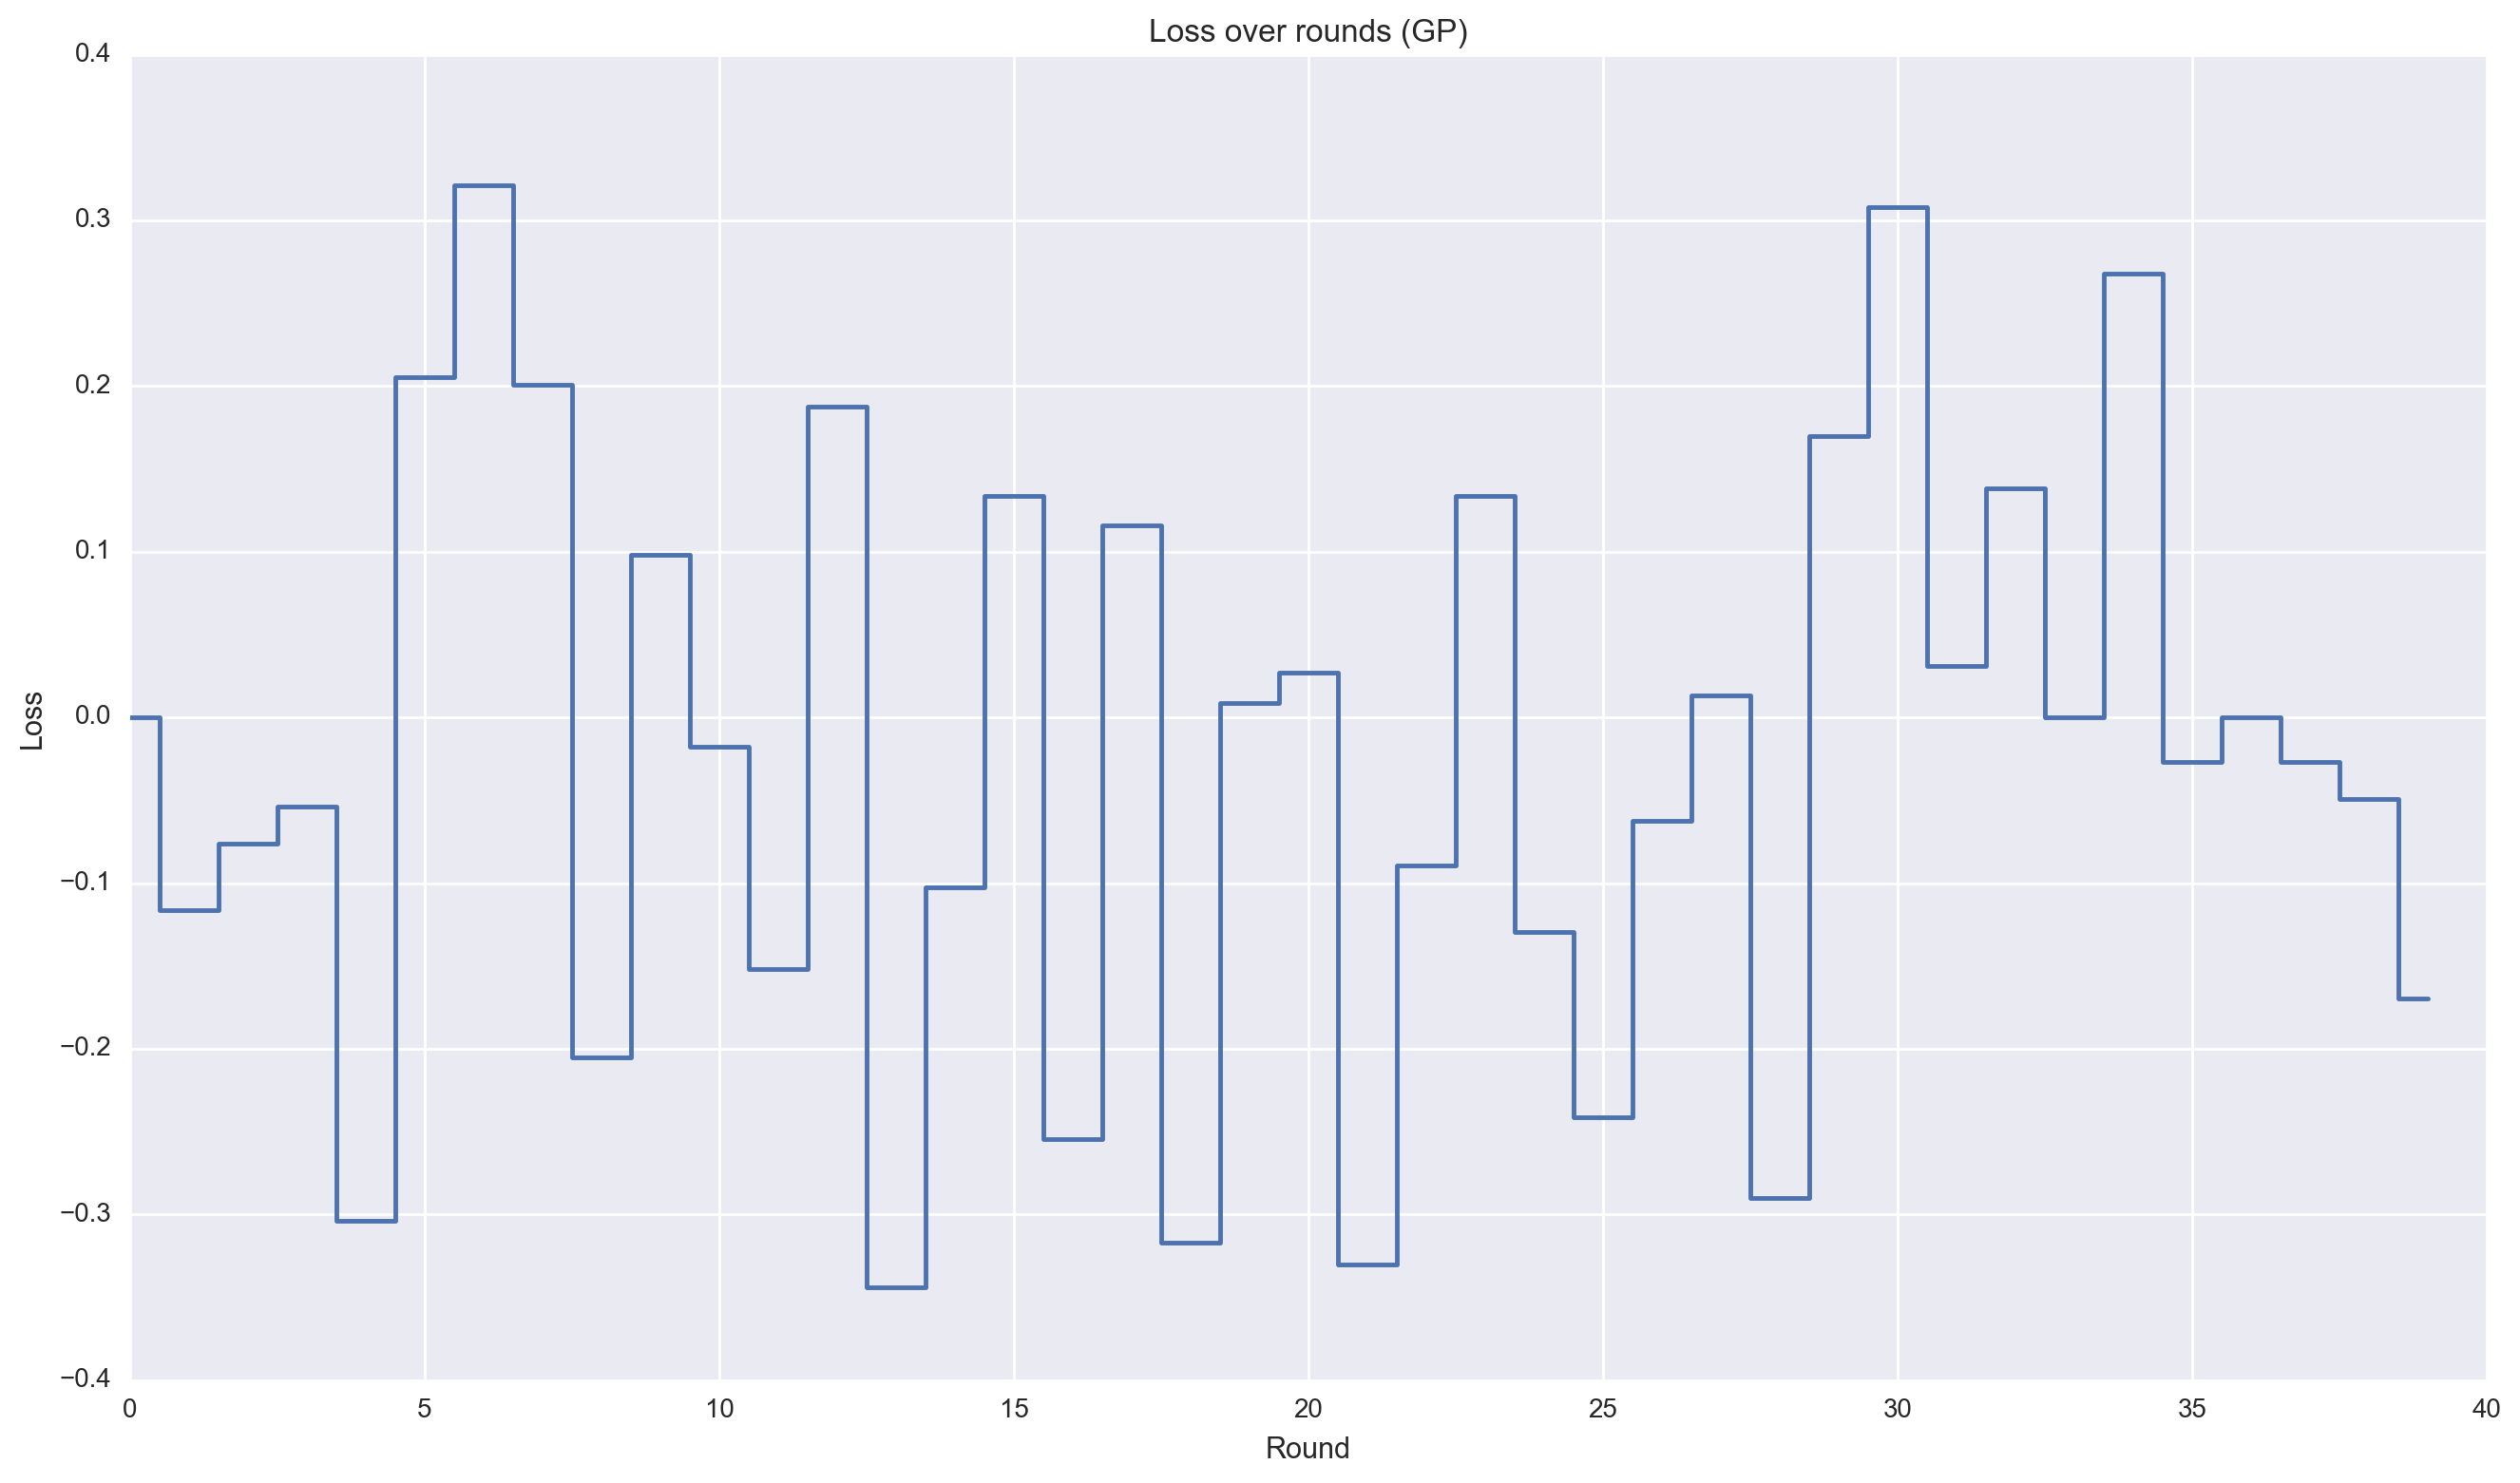

In [18]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['well_sep']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['well_sep']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['well_sep']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_gp.pdf');

In [19]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['well_sep']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['well_sep']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['well_sep']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['well_sep']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['well_sep']['gp']['values']) if e == np.max(experiment_dict['well_sep']['gp']['values'])]

Random Search best: [17]
TPE best: [46]
GP best: [6]


### 4.2 Well-separated clusters with noise

Set of 8 well-separated gaussian blobs in a 100-dimensional space under uniform noise.

In [20]:
# reading the data
test_df = pd.read_csv('data/final/well-sep-noise.csv')

In [21]:
# removing target variable
test_target = test_df['TARGET']

In [22]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_noise_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['well_sep_noise']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

KL divergence: 1.42757487297 | AMI score: 0.988115472641
AMI target-highd: 0.988115472641 | AMI target-lowd: 1.0
Rank-order correlation: -0.00446428571429
Parameters: {'whitening_flag': False, 'n_iter': 2000, 'pca_dims': 15, 'angle': 0.7411734812824842, 'learning_rate': 160.12770070000474, 'early_exaggeration': 7.074414867159083, 'perplexity': 16.0}
 
KL divergence: 0.257067531347 | AMI score: 0.765901691614
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.766532373456
Rank-order correlation: 0.107142857143
Parameters: {'whitening_flag': True, 'n_iter': 2000, 'pca_dims': 35, 'angle': 0.6288352642780238, 'learning_rate': 941.5155467340117, 'early_exaggeration': 9.59089699549062, 'perplexity': 70.0}
 
KL divergence: 0.55563300848 | AMI score: 0.00749633794654
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.0073585292083
Rank-order correlation: -0.160714285714
Parameters: {'whitening_flag': True, 'n_iter': 4700, 'pca_dims': 85, 'angle': 0.5873455069429949, 'learning_rate': 442.

In [23]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_noise_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['well_sep_noise']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

KL divergence: 0.318477362394 | AMI score: 0.988115472641
AMI target-highd: 0.988115472641 | AMI target-lowd: 1.0
Rank-order correlation: -0.227678571429
Parameters: {'whitening_flag': False, 'n_iter': 2200, 'pca_dims': 40, 'angle': 0.41299941702273424, 'learning_rate': 71.89855104681251, 'early_exaggeration': 5.445926599005683, 'perplexity': 146.0}
 
KL divergence: 0.159759998322 | AMI score: 0.818419269029
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.826393987673
Rank-order correlation: -0.0223214285714
Parameters: {'whitening_flag': False, 'n_iter': 2500, 'pca_dims': 95, 'angle': 0.6944203225073564, 'learning_rate': 862.5637425255882, 'early_exaggeration': 4.036276368499537, 'perplexity': 161.0}
 
KL divergence: 0.430247306824 | AMI score: 0.81874038751
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.823658132853
Rank-order correlation: -0.174107142857
Parameters: {'whitening_flag': True, 'n_iter': 2900, 'pca_dims': 55, 'angle': 0.5430772301296078, 'learning_rate': 96

In [24]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/well_sep_noise_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['well_sep_noise']['gp'] = bo.res['all']

KL divergence: 0.534628033638 | AMI score: 0.763636475941
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.764728301603
Rank-order correlation: -0.133928571429
Parameters: {'whitening_flag': True, 'n_iter': 3176, 'pca_dims': 59, 'angle': 0.4147953466120532, 'learning_rate': 693.44138544750854, 'early_exaggeration': 10.138083556614525, 'perplexity': 75.219927453707911}
 
KL divergence: 0.24711805582 | AMI score: 0.923050889041
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.932568686117
Rank-order correlation: 0.0178571428571
Parameters: {'whitening_flag': False, 'n_iter': 1164, 'pca_dims': 54, 'angle': 0.61730194325871102, 'learning_rate': 860.82381729796441, 'early_exaggeration': 3.4703752263764533, 'perplexity': 108.82708719430127}
 
KL divergence: 0.108560360968 | AMI score: 0.790109910776
AMI target-highd: 0.988115472641 | AMI target-lowd: 0.794730127824
Rank-order correlation: -0.21875
Parameters: {'whitening_flag': True, 'n_iter': 2439, 'pca_dims': 33, 'angle': 0.43285

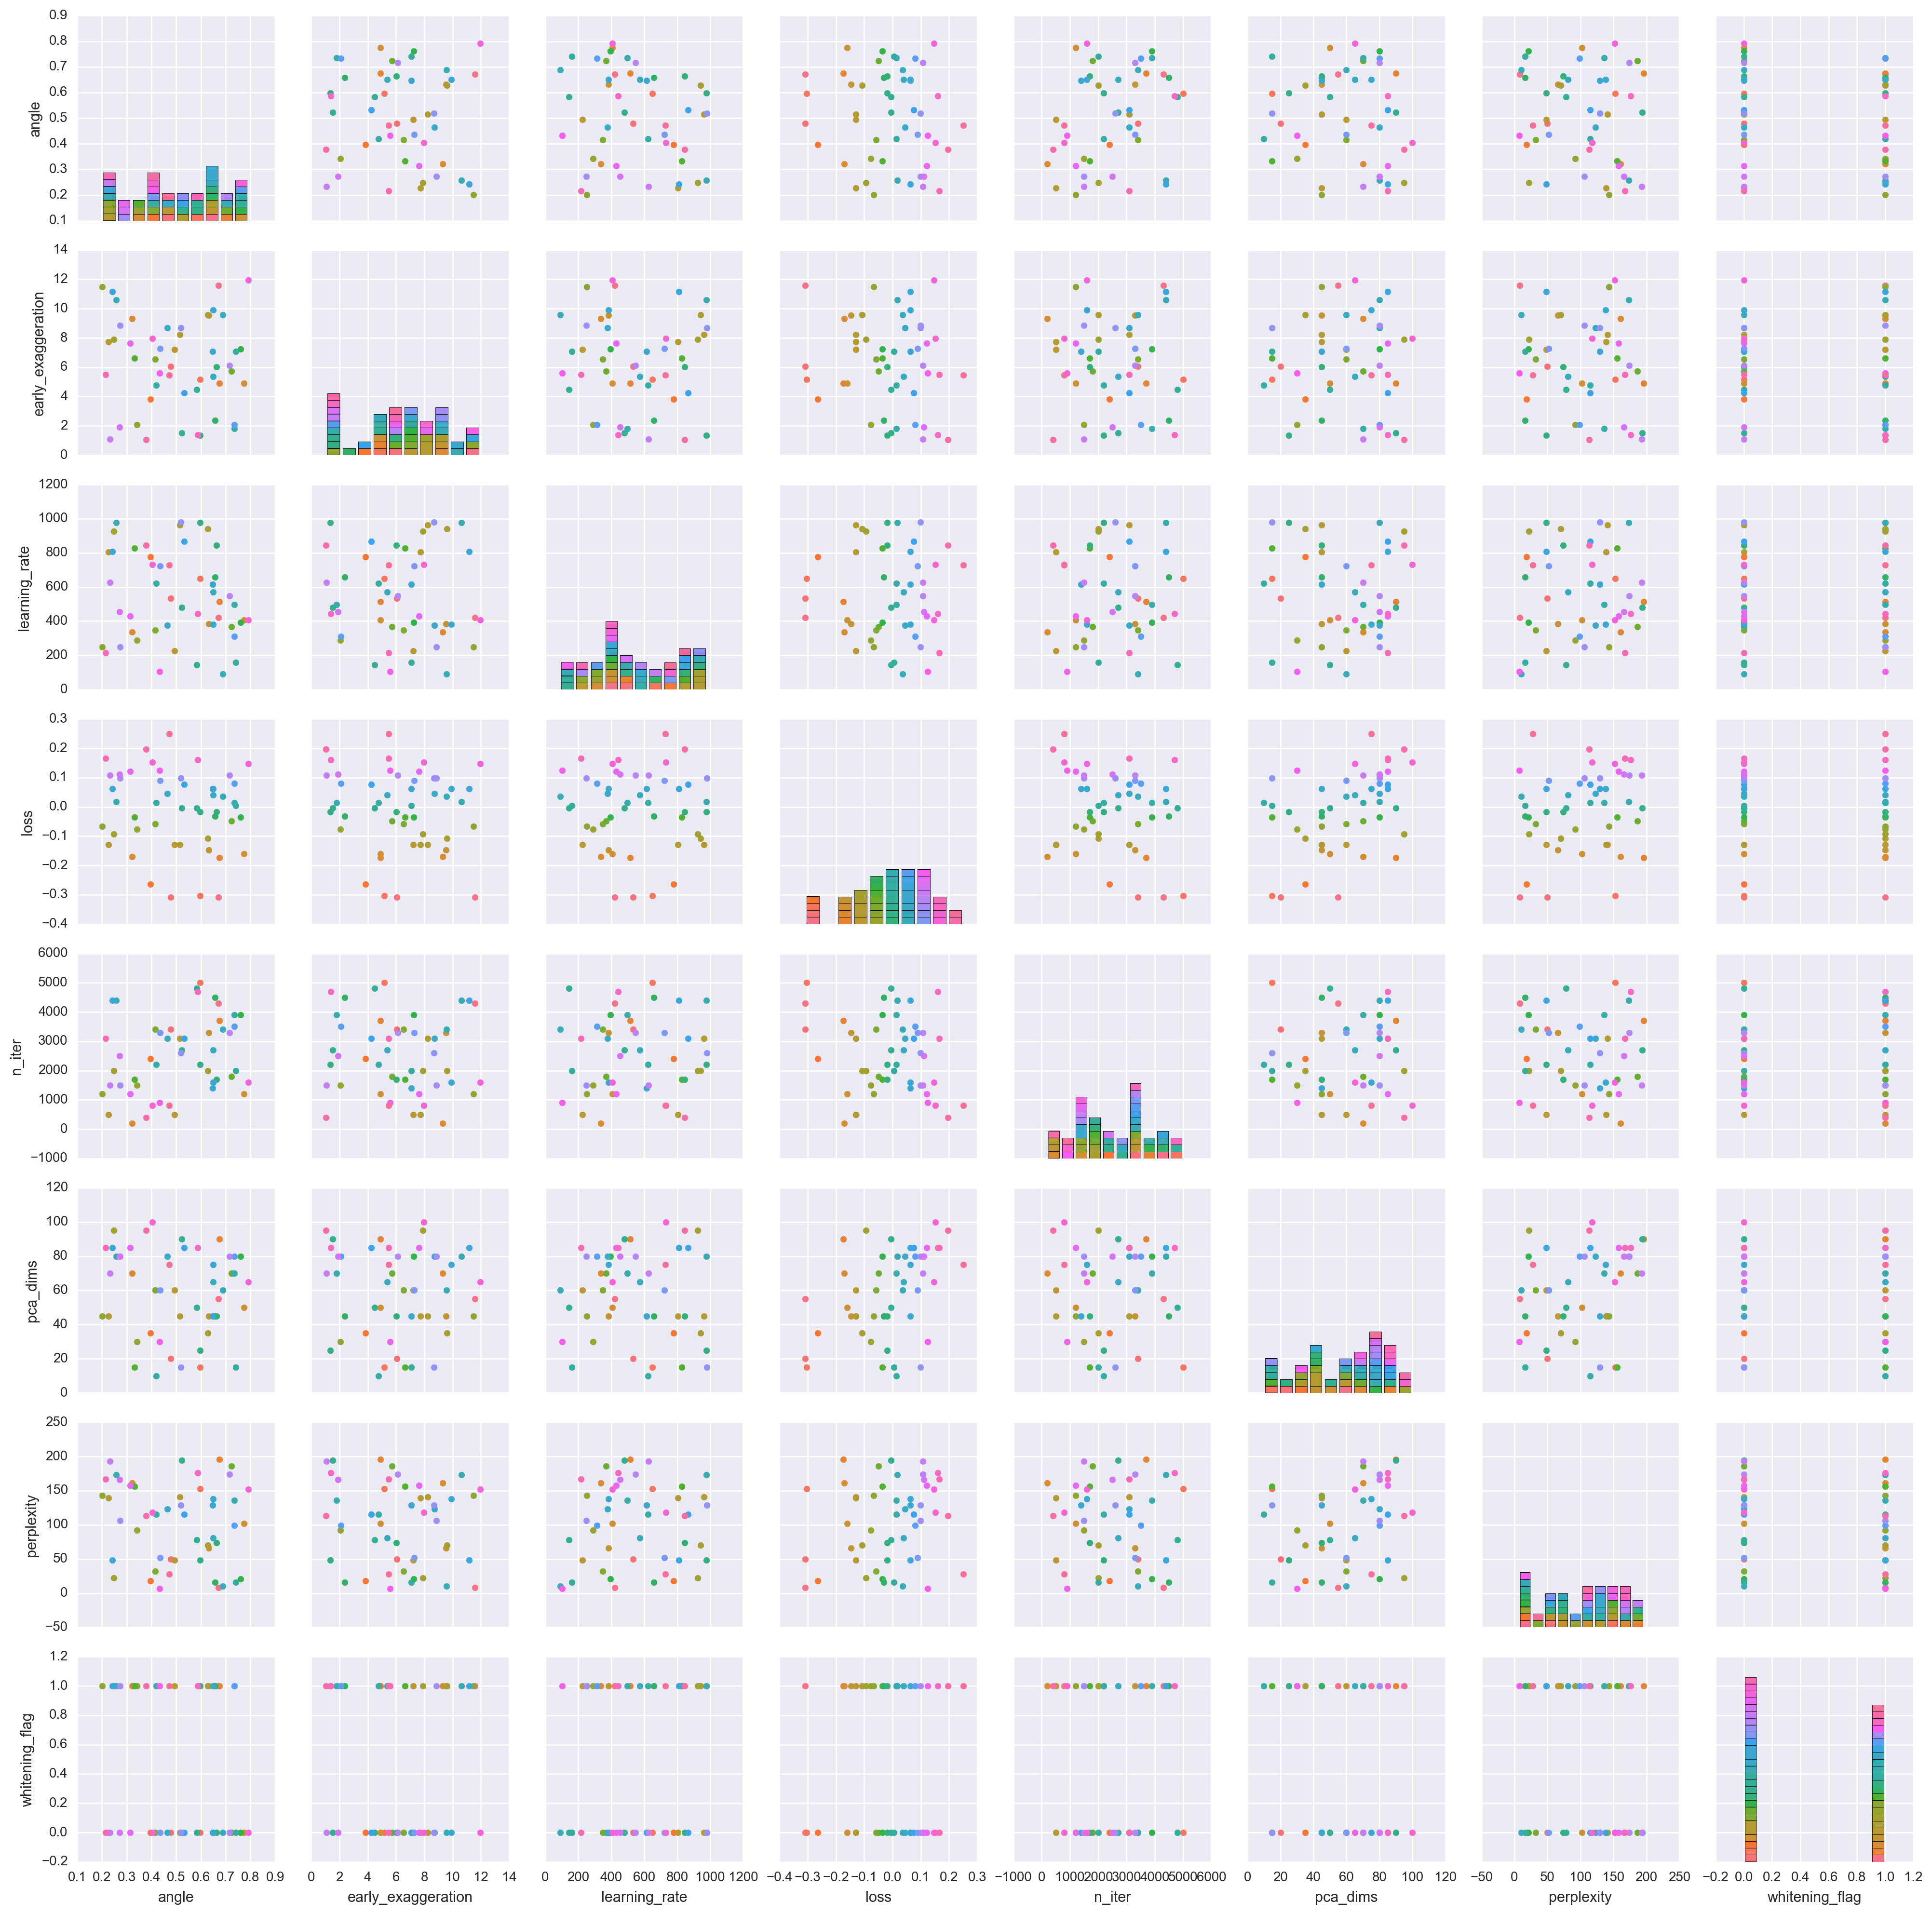

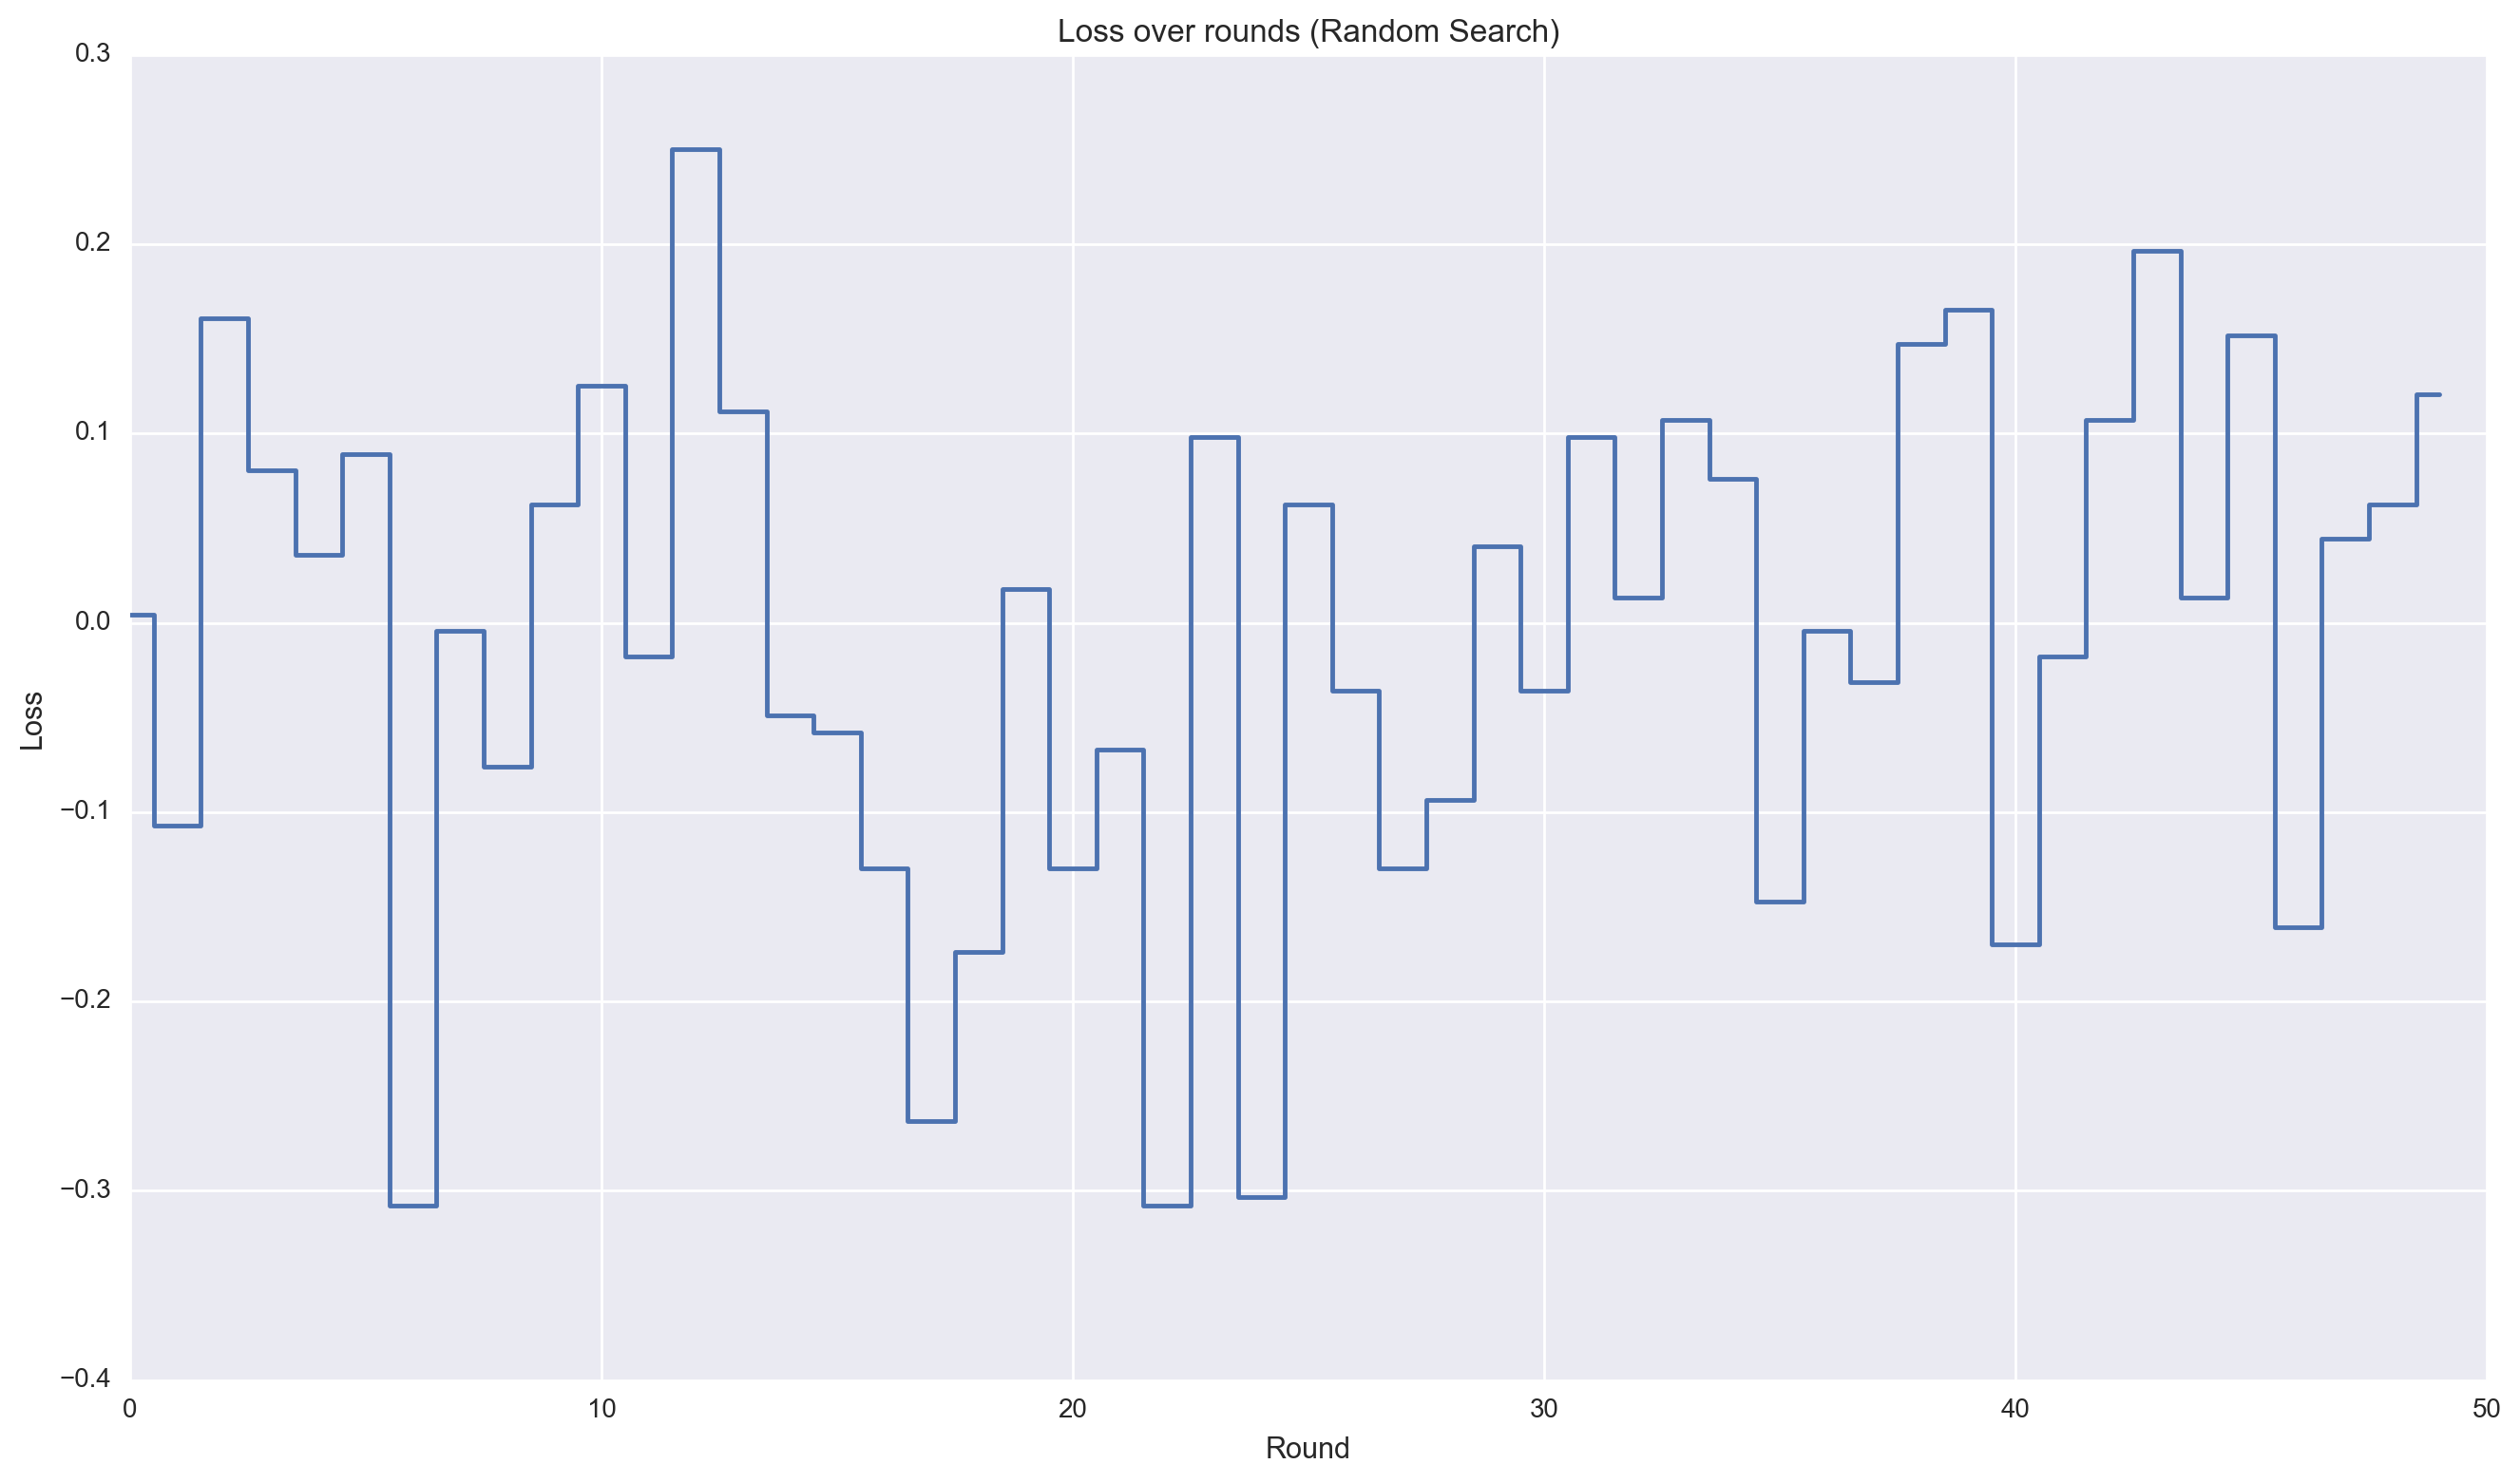

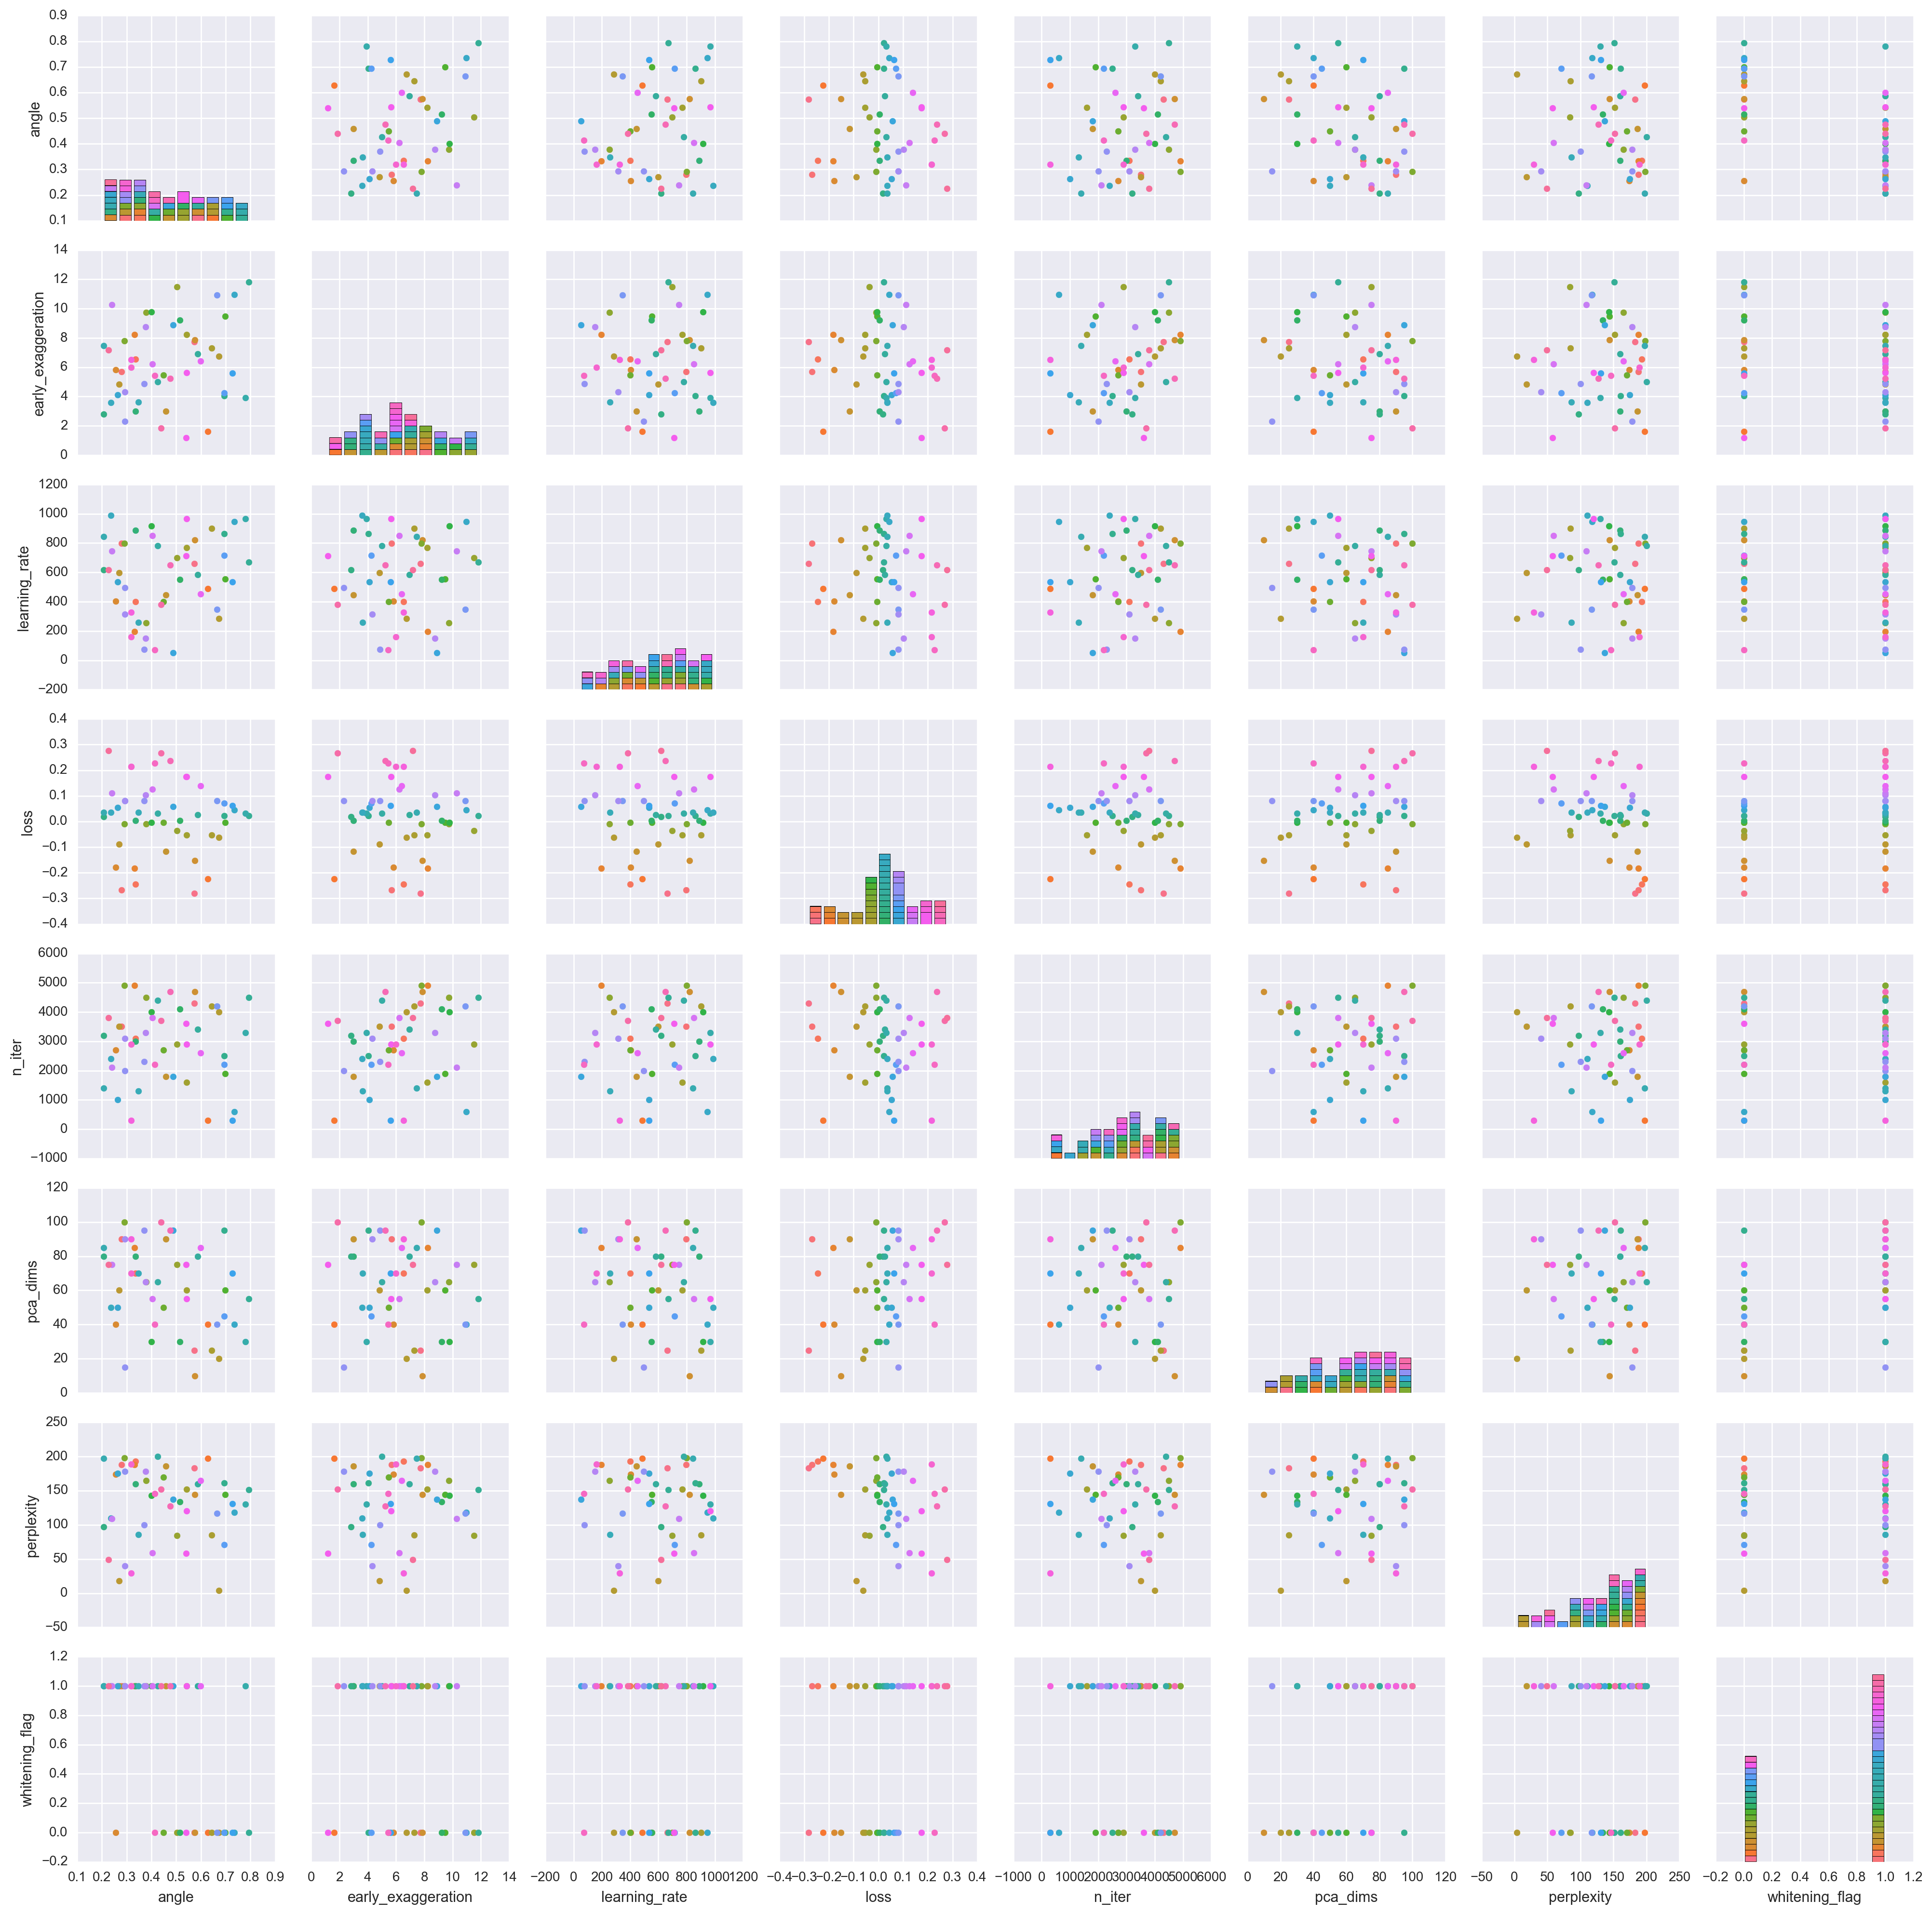

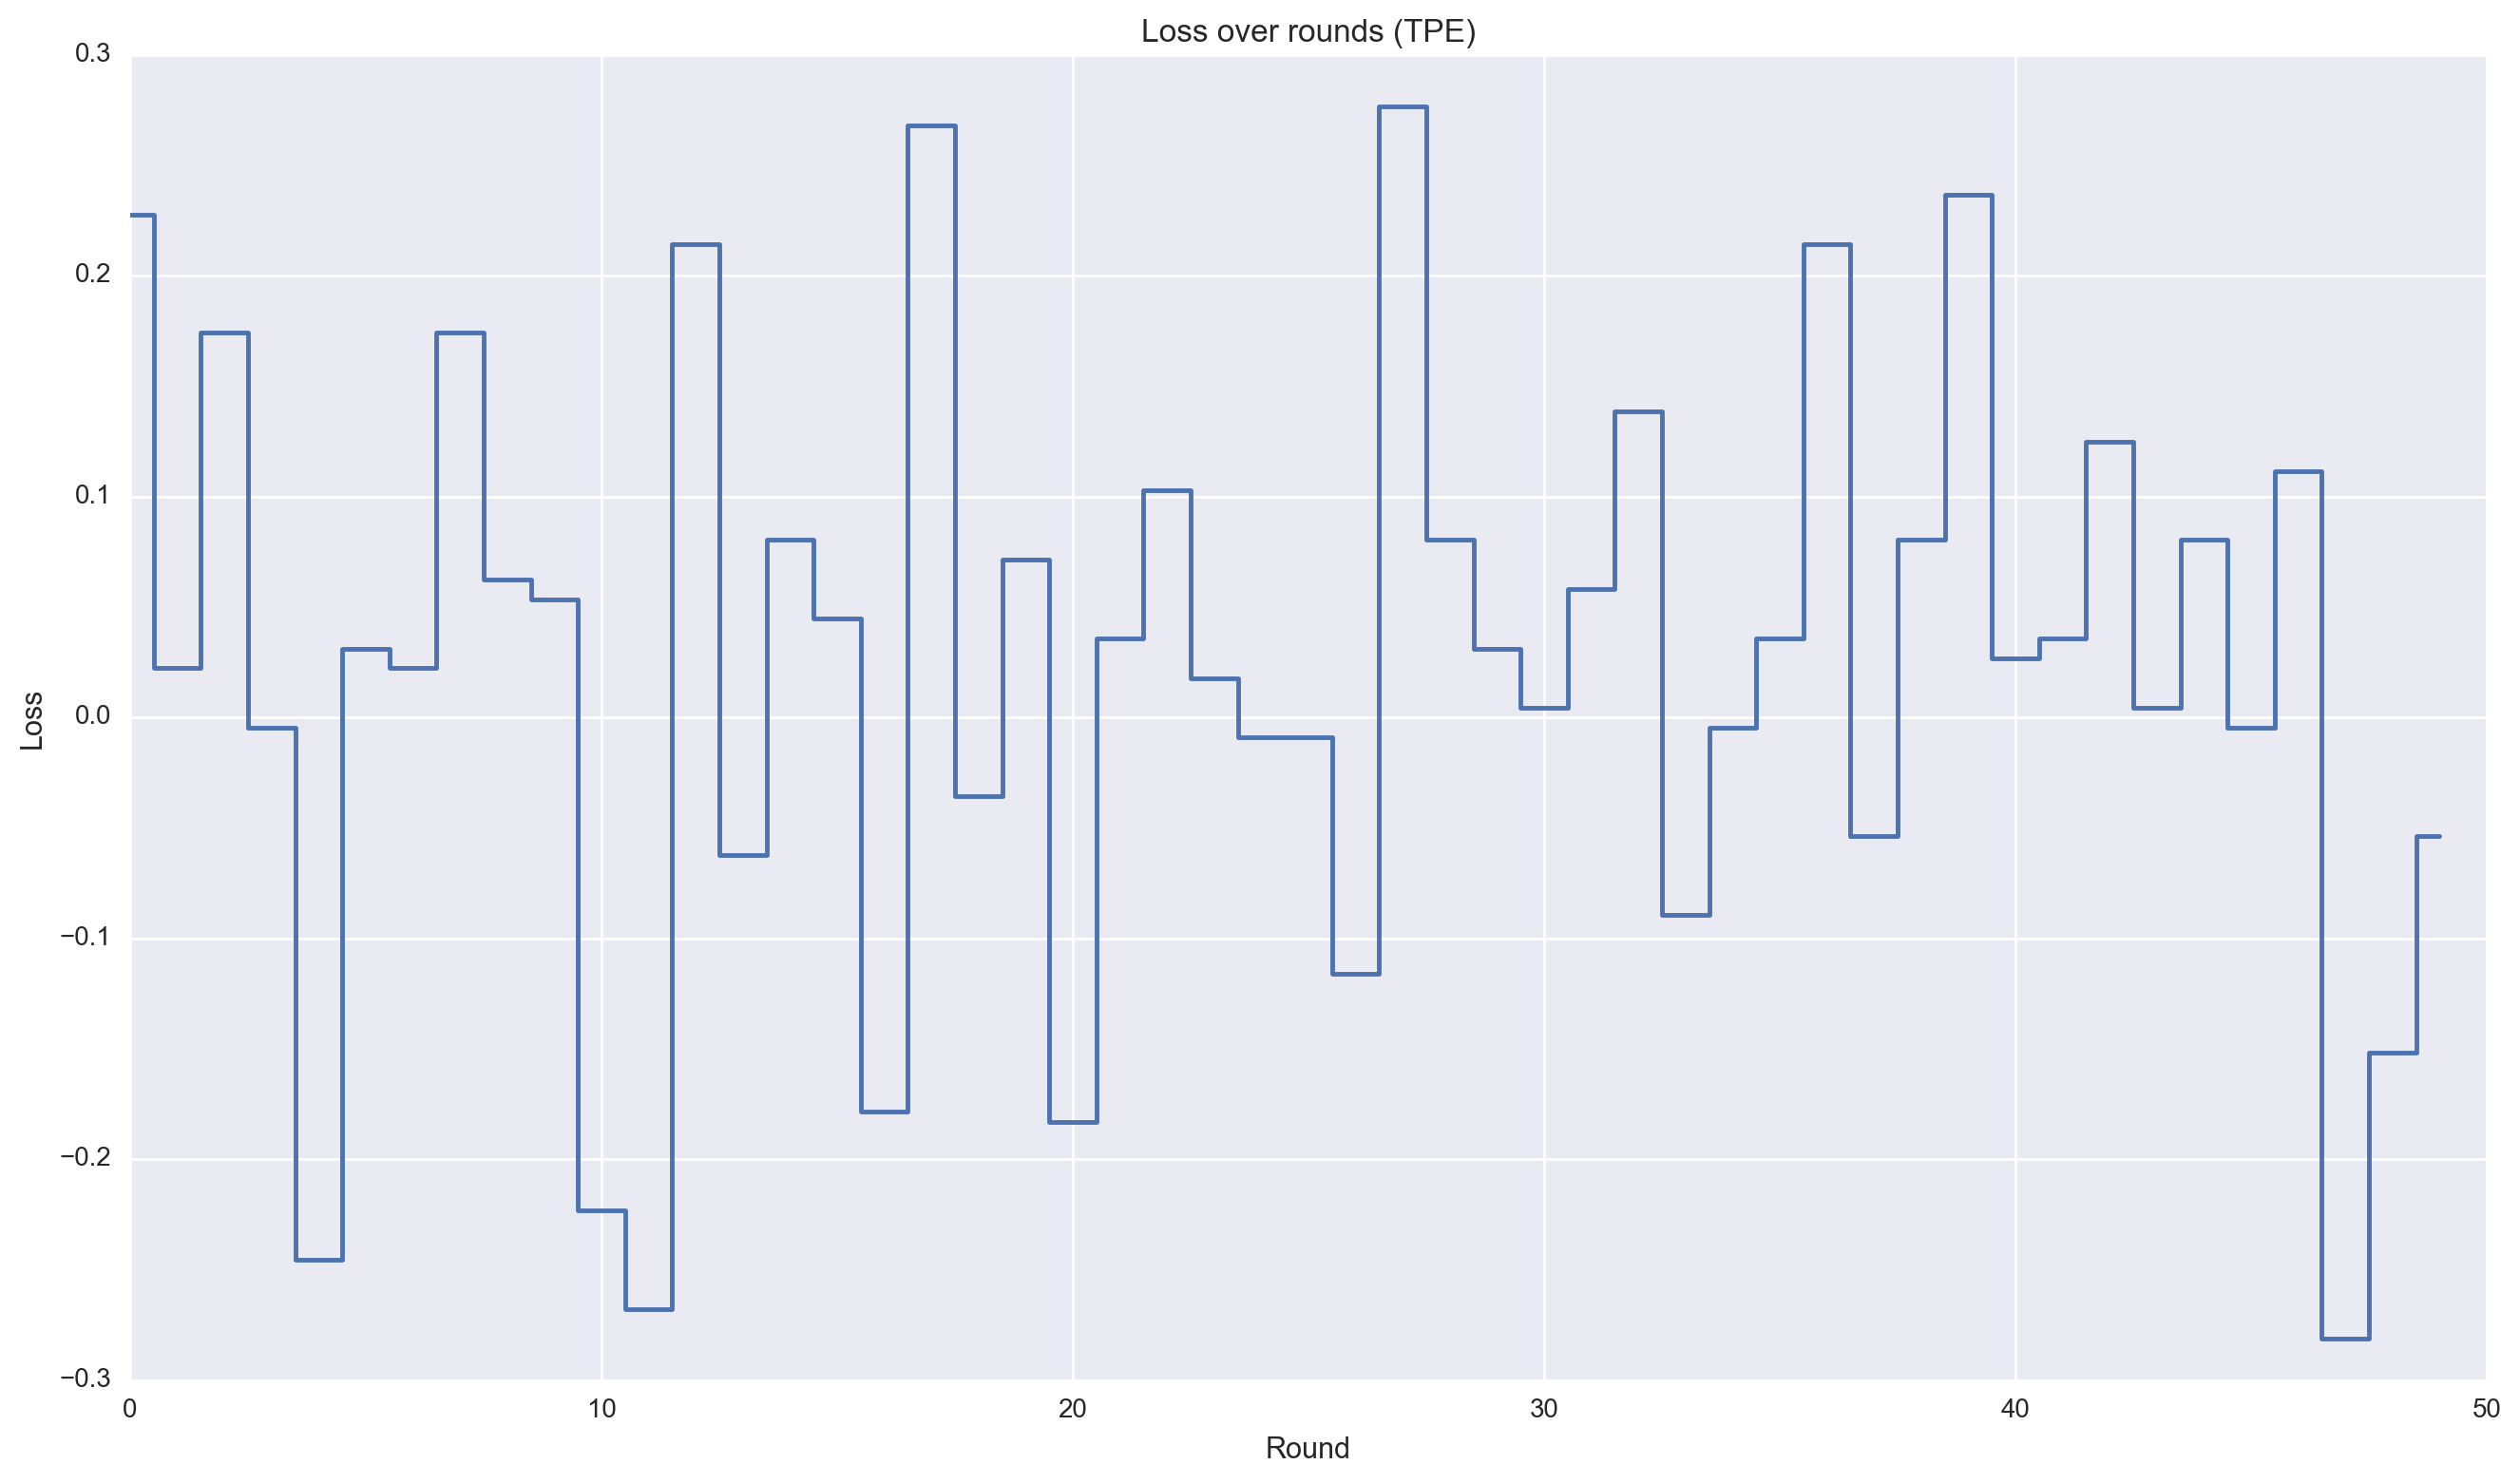

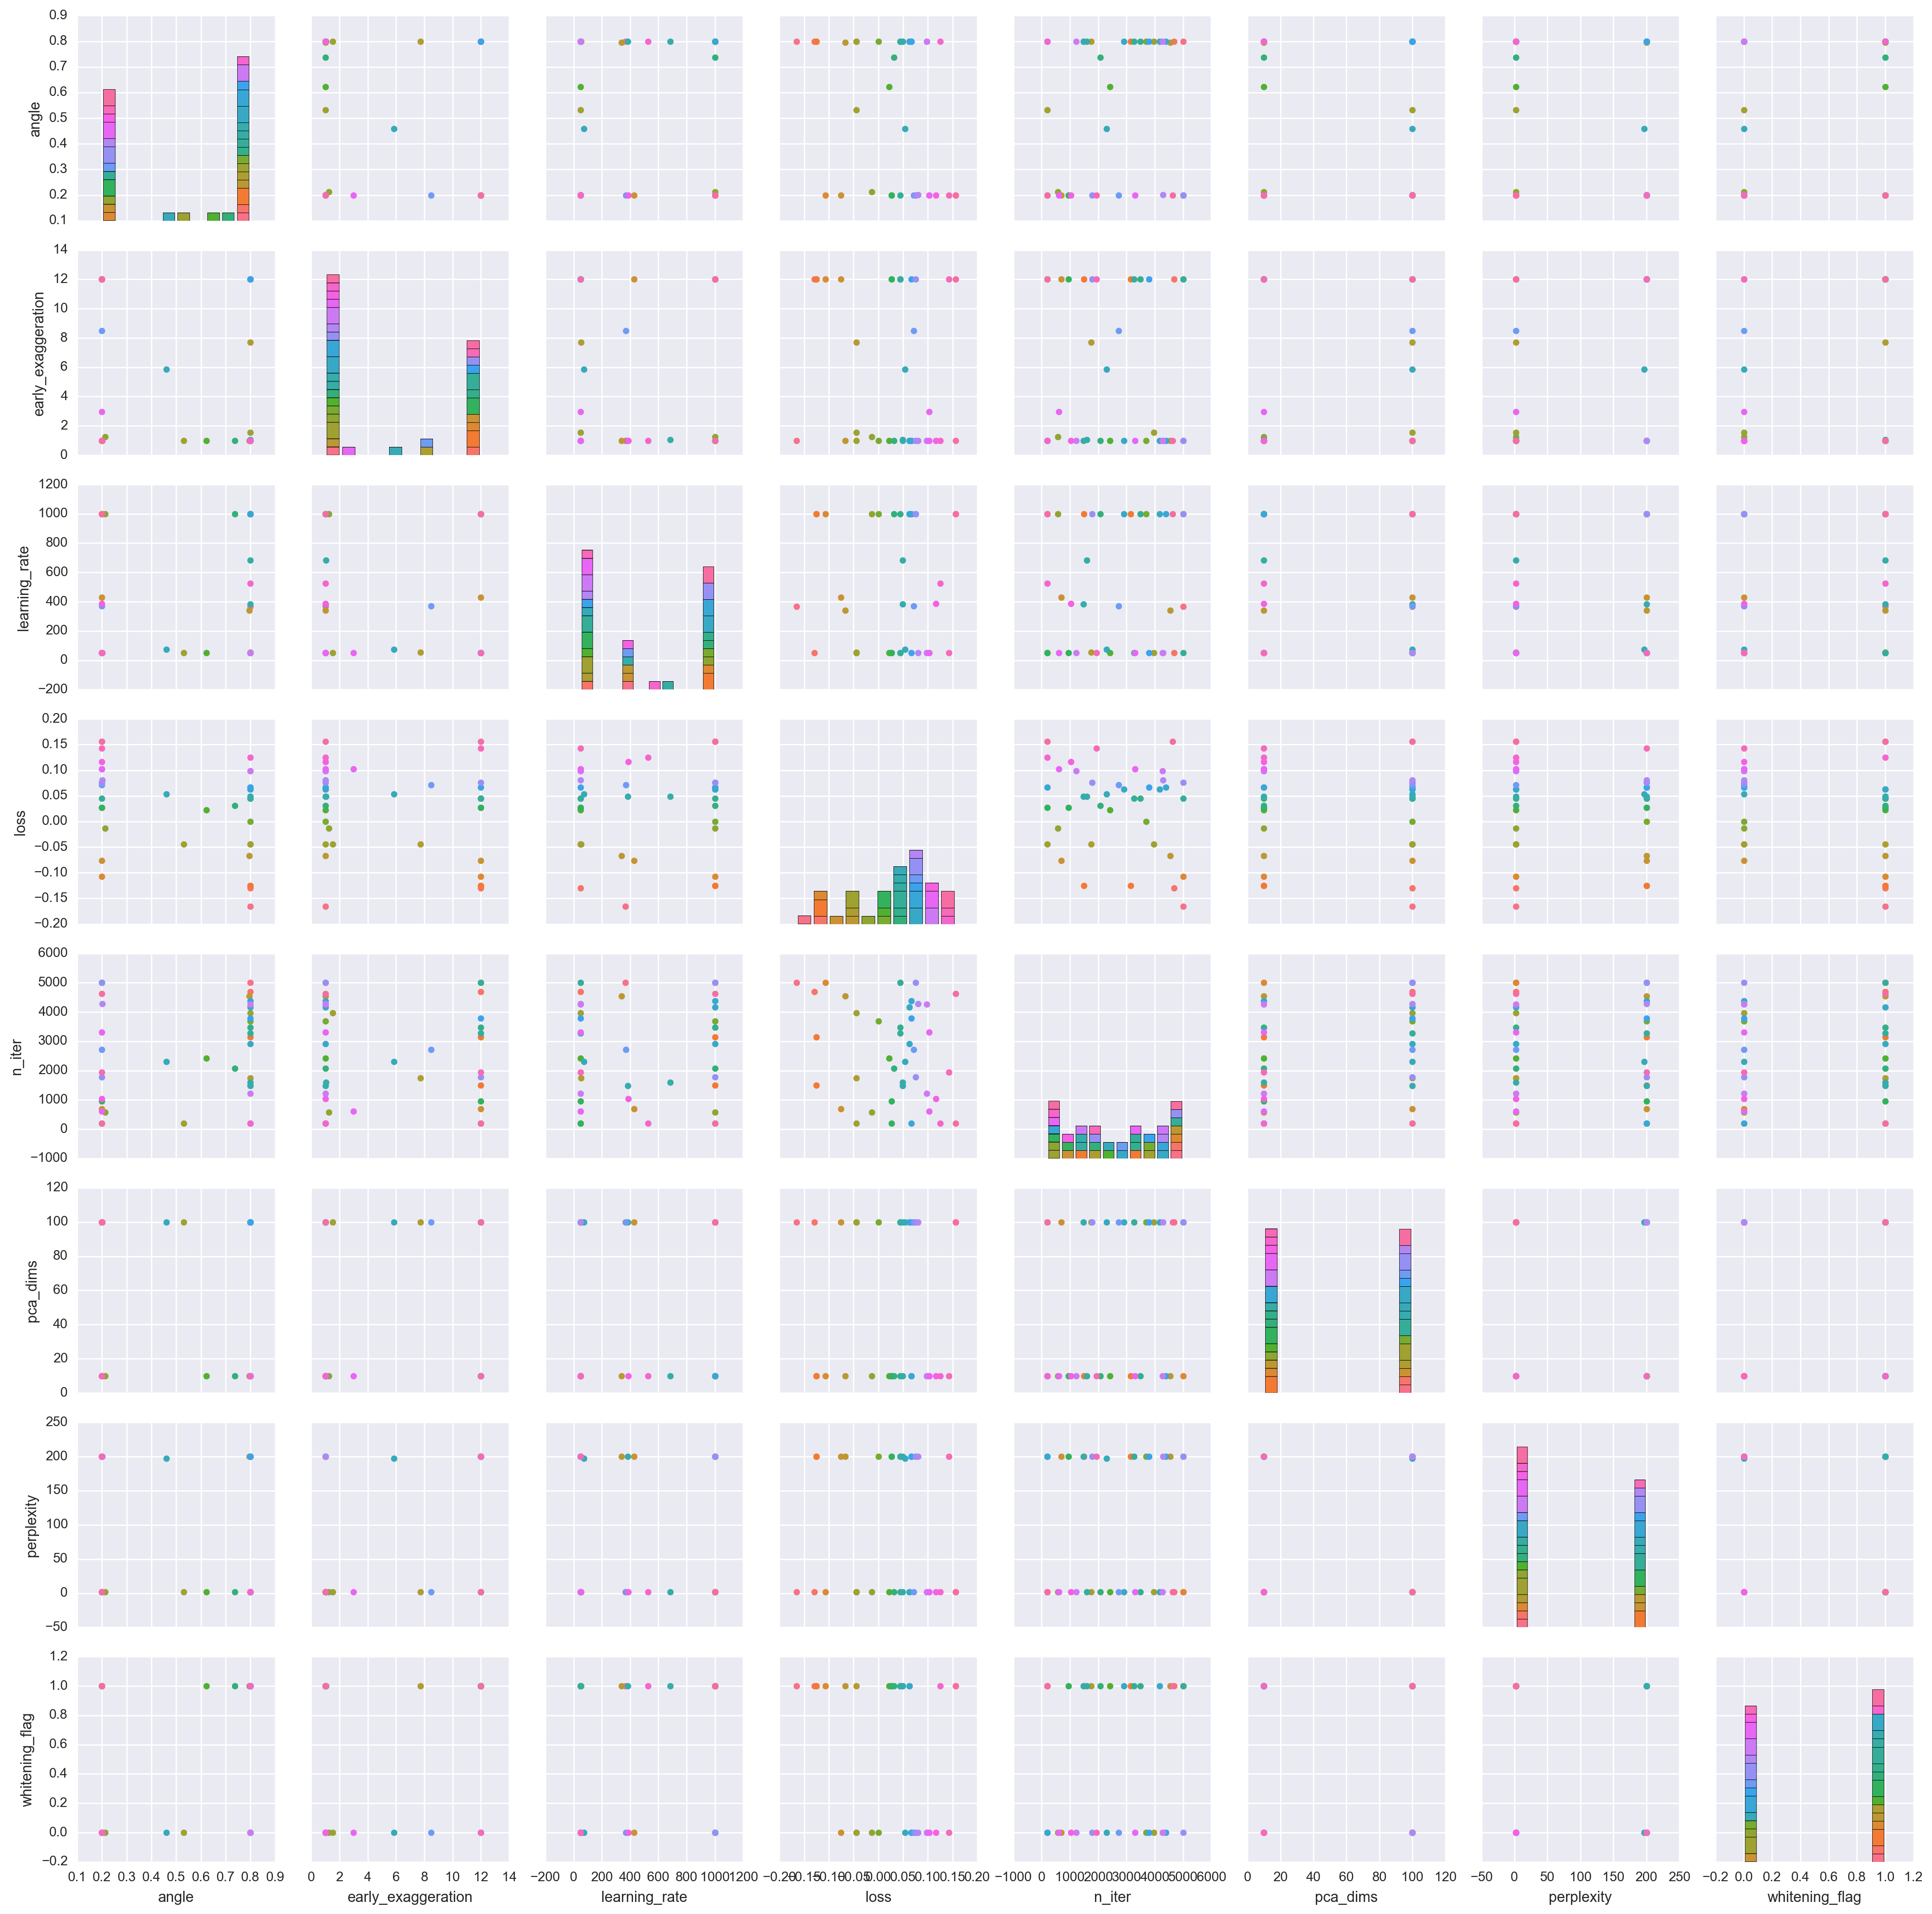

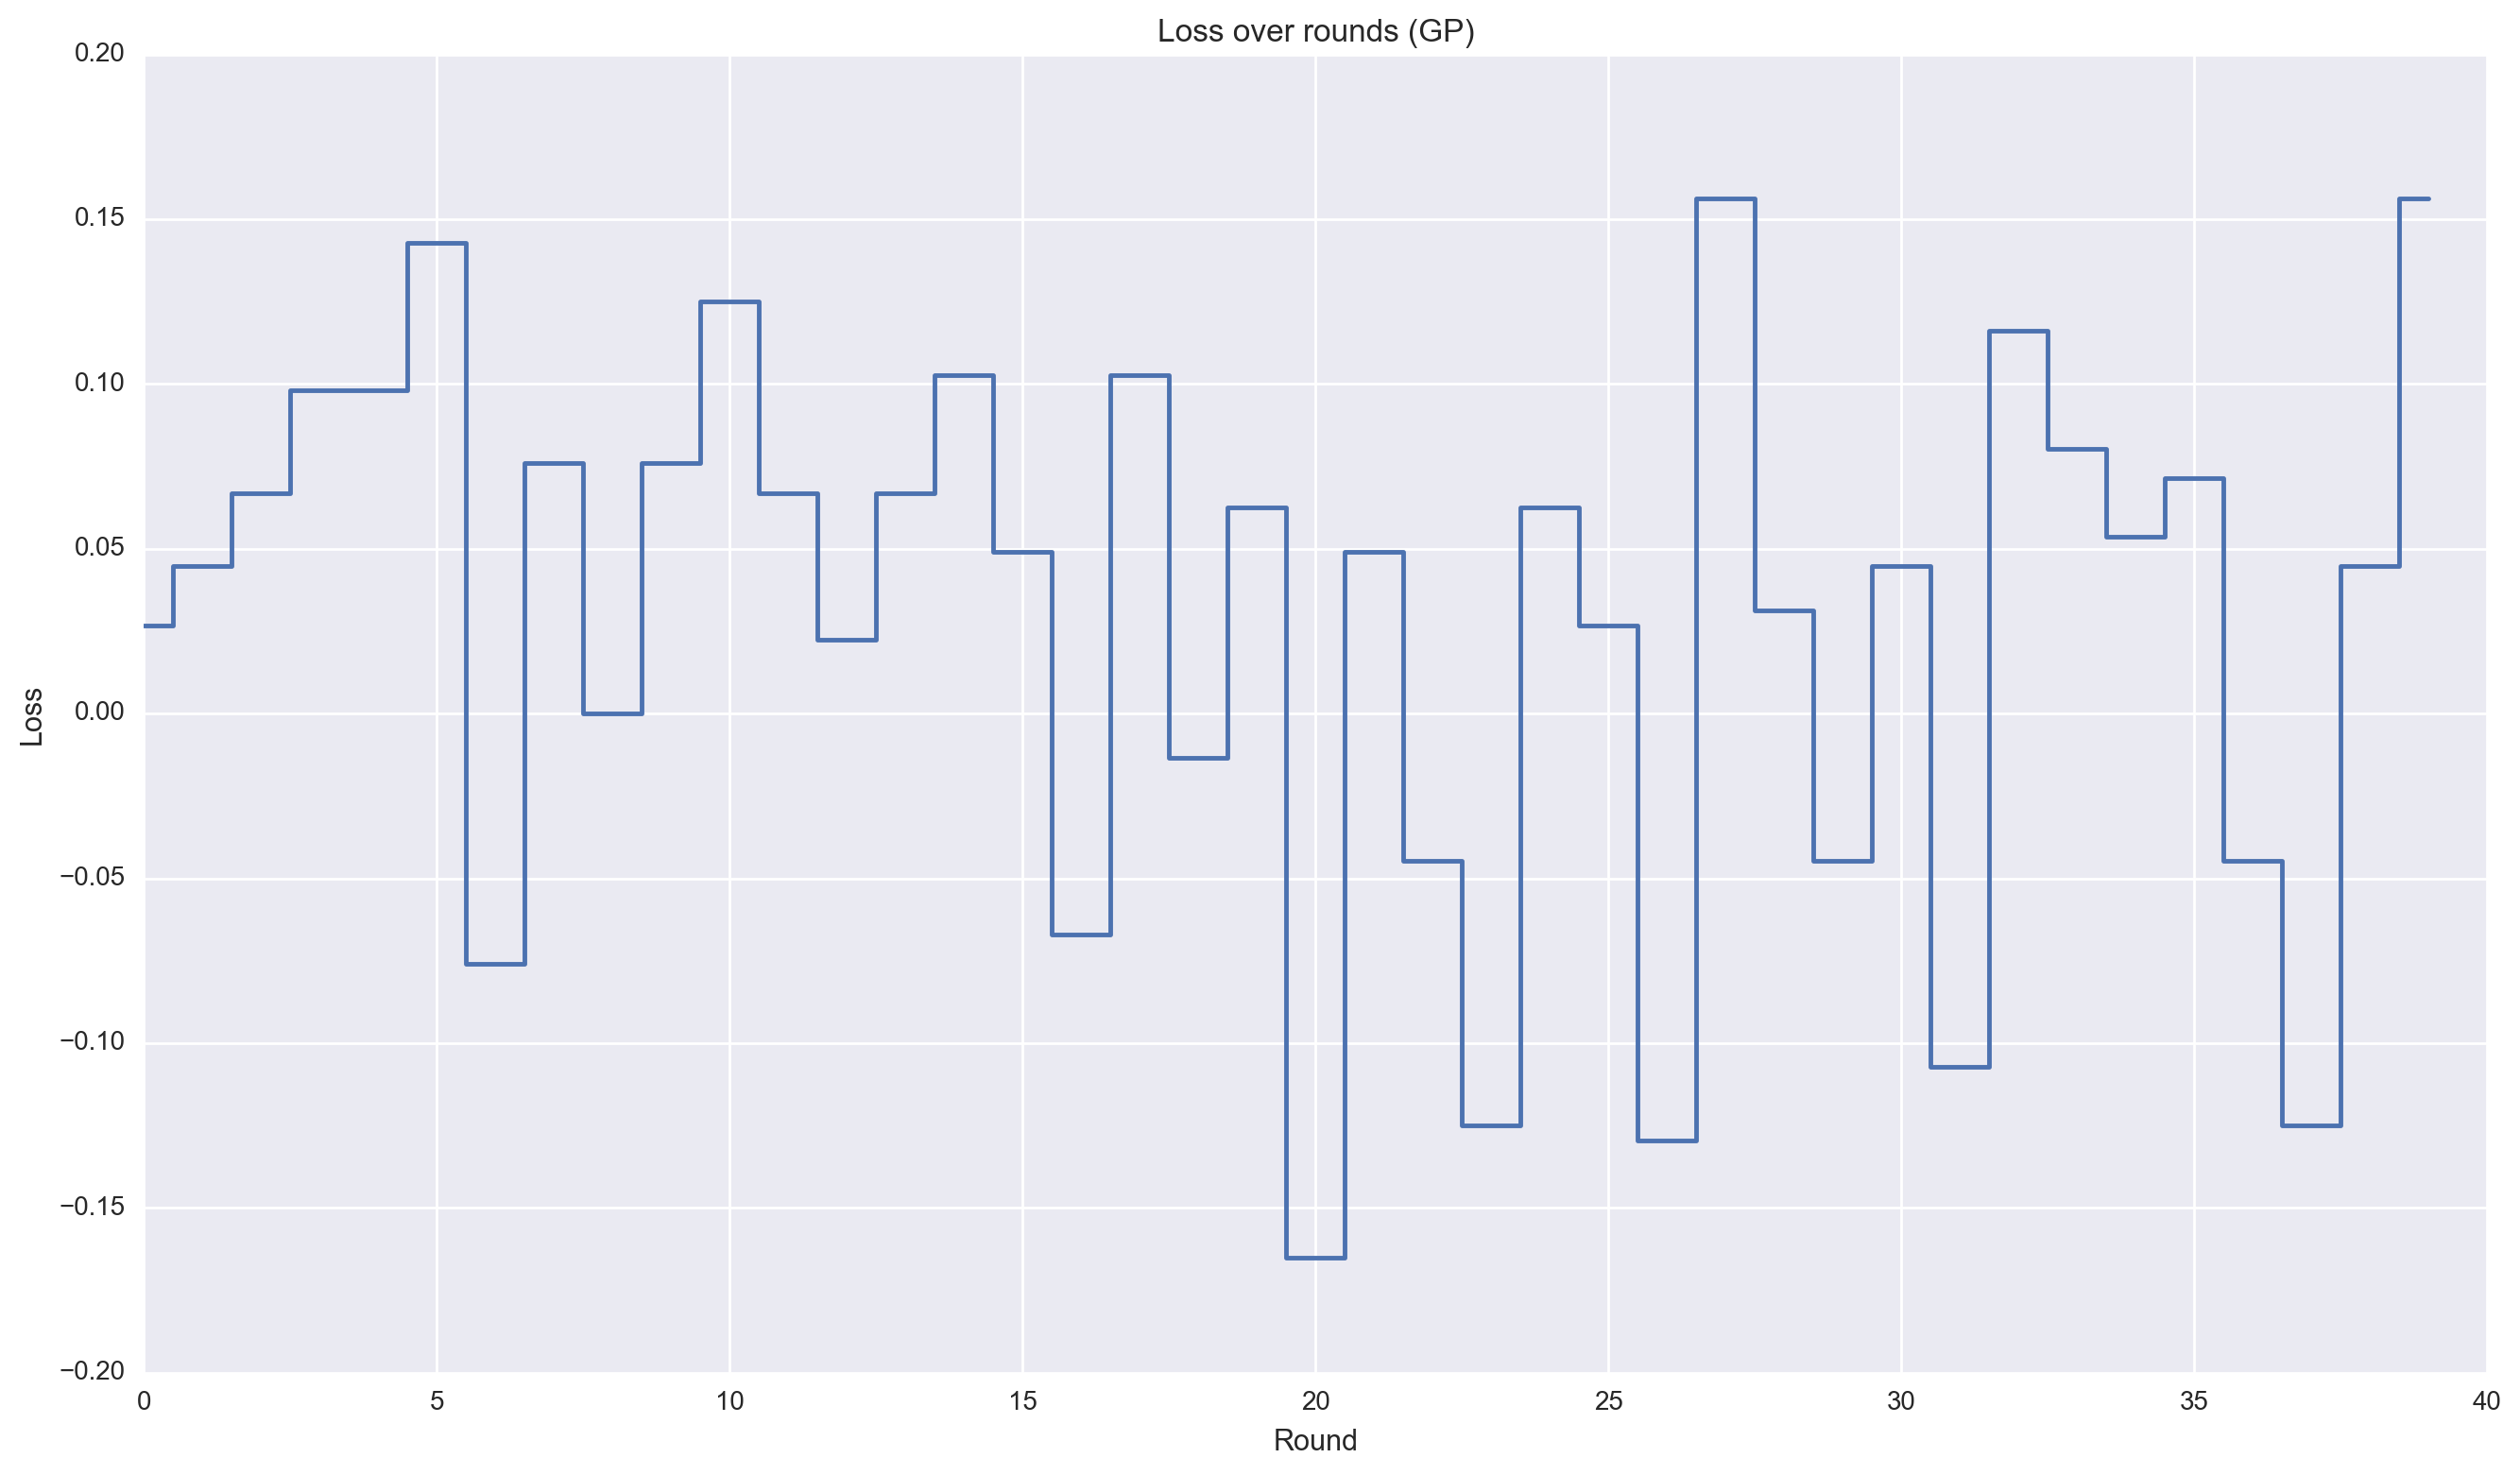

In [25]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['well_sep_noise']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_noise_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_noise_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['well_sep_noise']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_noise_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_noise_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['well_sep_noise']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/well_sep_noise_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/well_sep_noise_gp.pdf');

In [26]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['well_sep_noise']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['well_sep_noise']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['gp']['values']) if e == np.max(experiment_dict['well_sep_noise']['gp']['values'])]

Random Search best: [22]
TPE best: [47]
GP best: [27, 39]


In [27]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['rand']) if e['loss'] == np.max([e['loss'] for e in experiment_dict['well_sep_noise']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['tpe']) if e['loss'] == np.max([e['loss'] for e in experiment_dict['well_sep_noise']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['well_sep_noise']['gp']['values']) if e == np.min(experiment_dict['well_sep_noise']['gp']['values'])]

Random Search best: [12]
TPE best: [27]
GP best: [20]


### 4.3 200-dimensional gaussian noise

Gaussian noise centered on origin. No clusters nor significant patterns to show.

In [ ]:
# reading the data
test_df = pd.read_csv('data/final/gaussian-noise.csv')

In [ ]:
# removing target variable
test_target = test_df['TARGET']

In [ ]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/gaussian_noise_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['gaussian_noise']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

In [ ]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/gaussian_noise_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['gaussian_noise']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

In [ ]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/gaussian_noise_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['gaussian_noise']['gp'] = bo.res['all']

In [ ]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['gaussian_noise']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/gaussian_noise_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/gaussian_noise_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['gaussian_noise']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/gaussian_noise_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/gaussian_noise_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['gaussian_noise']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/gaussian_noise_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/gaussian_noise_gp.pdf');

In [ ]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['gaussian_noise']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['gaussian_noise']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['gaussian_noise']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['gaussian_noise']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['gaussian_noise']['gp']['values']) if e == np.max(experiment_dict['gaussian_noise']['gp']['values'])]

### 4.4 Two gaussian distributions with different densities

Two gaussian distributions centered on the origin, but with different standard deviations.

In [ ]:
# reading the data
test_df = pd.read_csv('data/final/topology.csv')

In [ ]:
# removing target variable
test_target = test_df['TARGET']

In [ ]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/topology_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['topology']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

In [ ]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/topology_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['topology']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

In [ ]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/topology_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['topology']['gp'] = bo.res['all']

In [ ]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['topology']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/topology_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/topology_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['topology']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/topology_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/topology_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['topology']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/topology_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/topology_gp.pdf');

In [ ]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['topology']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['topology']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['topology']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['topology']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['topology']['gp']['values']) if e == np.max(experiment_dict['topology']['gp']['values'])]

### 4.5 COIL-20

Images of rotated objects.

In [28]:
# reading the data
test_df = pd.read_csv('data/final/coil-20.csv')

In [29]:
# removing target variable
test_target = test_df['TARGET']

In [30]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/coil_20_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['coil_20']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

KL divergence: 0.386500835419 | AMI score: 0.782372500361
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.750660413402
Rank-order correlation: 0.0957644824311
Parameters: {'whitening_flag': True, 'n_iter': 1900, 'pca_dims': 45, 'angle': 0.6334385473335122, 'learning_rate': 700.7258825290229, 'early_exaggeration': 5.949108033167727, 'perplexity': 173.0}
 
KL divergence: 0.587850153446 | AMI score: 0.78222116088
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.75906876944
Rank-order correlation: 0.1670781893
Parameters: {'whitening_flag': False, 'n_iter': 800, 'pca_dims': 60, 'angle': 0.44357006096629137, 'learning_rate': 370.3586693374898, 'early_exaggeration': 11.252853580819432, 'perplexity': 74.0}
 
KL divergence: 1.20474171638 | AMI score: 0.693949266821
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.673077167195
Rank-order correlation: 0.00973725862615
Parameters: {'whitening_flag': False, 'n_iter': 1600, 'pca_dims': 35, 'angle': 0.4759302876387794, 'learning_rate

In [31]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/coil_20_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['coil_20']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

KL divergence: 2.50310397148 | AMI score: 0.634854185222
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.635464372664
Rank-order correlation: 0.0456220322887
Parameters: {'whitening_flag': False, 'n_iter': 2400, 'pca_dims': 80, 'angle': 0.6977449755988303, 'learning_rate': 339.7408733698741, 'early_exaggeration': 3.6068026451860766, 'perplexity': 4.0}
 
KL divergence: 1.3799123764 | AMI score: 0.625396217641
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.596130060217
Rank-order correlation: 0.0499271921494
Parameters: {'whitening_flag': False, 'n_iter': 4600, 'pca_dims': 70, 'angle': 0.27186563268736796, 'learning_rate': 111.01432898111818, 'early_exaggeration': 4.747372021152705, 'perplexity': 49.0}
 
KL divergence: 1.20263564587 | AMI score: 0.653266909511
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.631867837651
Rank-order correlation: 0.0910541310541
Parameters: {'whitening_flag': False, 'n_iter': 4400, 'pca_dims': 80, 'angle': 0.7879788851489817, 'learning_ra

In [32]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/coil_20_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['coil_20']['gp'] = bo.res['all']

KL divergence: 1.87084925175 | AMI score: 0.674032959951
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.64538386111
Rank-order correlation: 0.057423235201
Parameters: {'whitening_flag': True, 'n_iter': 3709, 'pca_dims': 45, 'angle': 0.77219818730617451, 'learning_rate': 568.19081878149507, 'early_exaggeration': 1.6799338606482681, 'perplexity': 5.6925384205397611}
 
KL divergence: 0.380823969841 | AMI score: 0.789508238447
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.760319296257
Rank-order correlation: 0.188097499209
Parameters: {'whitening_flag': False, 'n_iter': 1352, 'pca_dims': 34, 'angle': 0.31036573771942139, 'learning_rate': 767.70188336802926, 'early_exaggeration': 1.2783180498170101, 'perplexity': 127.50653934880984}
 
KL divergence: 1.00542294979 | AMI score: 0.712784441894
AMI target-highd: 0.894875869955 | AMI target-lowd: 0.689468396424
Rank-order correlation: 0.334700854701
Parameters: {'whitening_flag': False, 'n_iter': 4861, 'pca_dims': 75, 'angle': 0.6

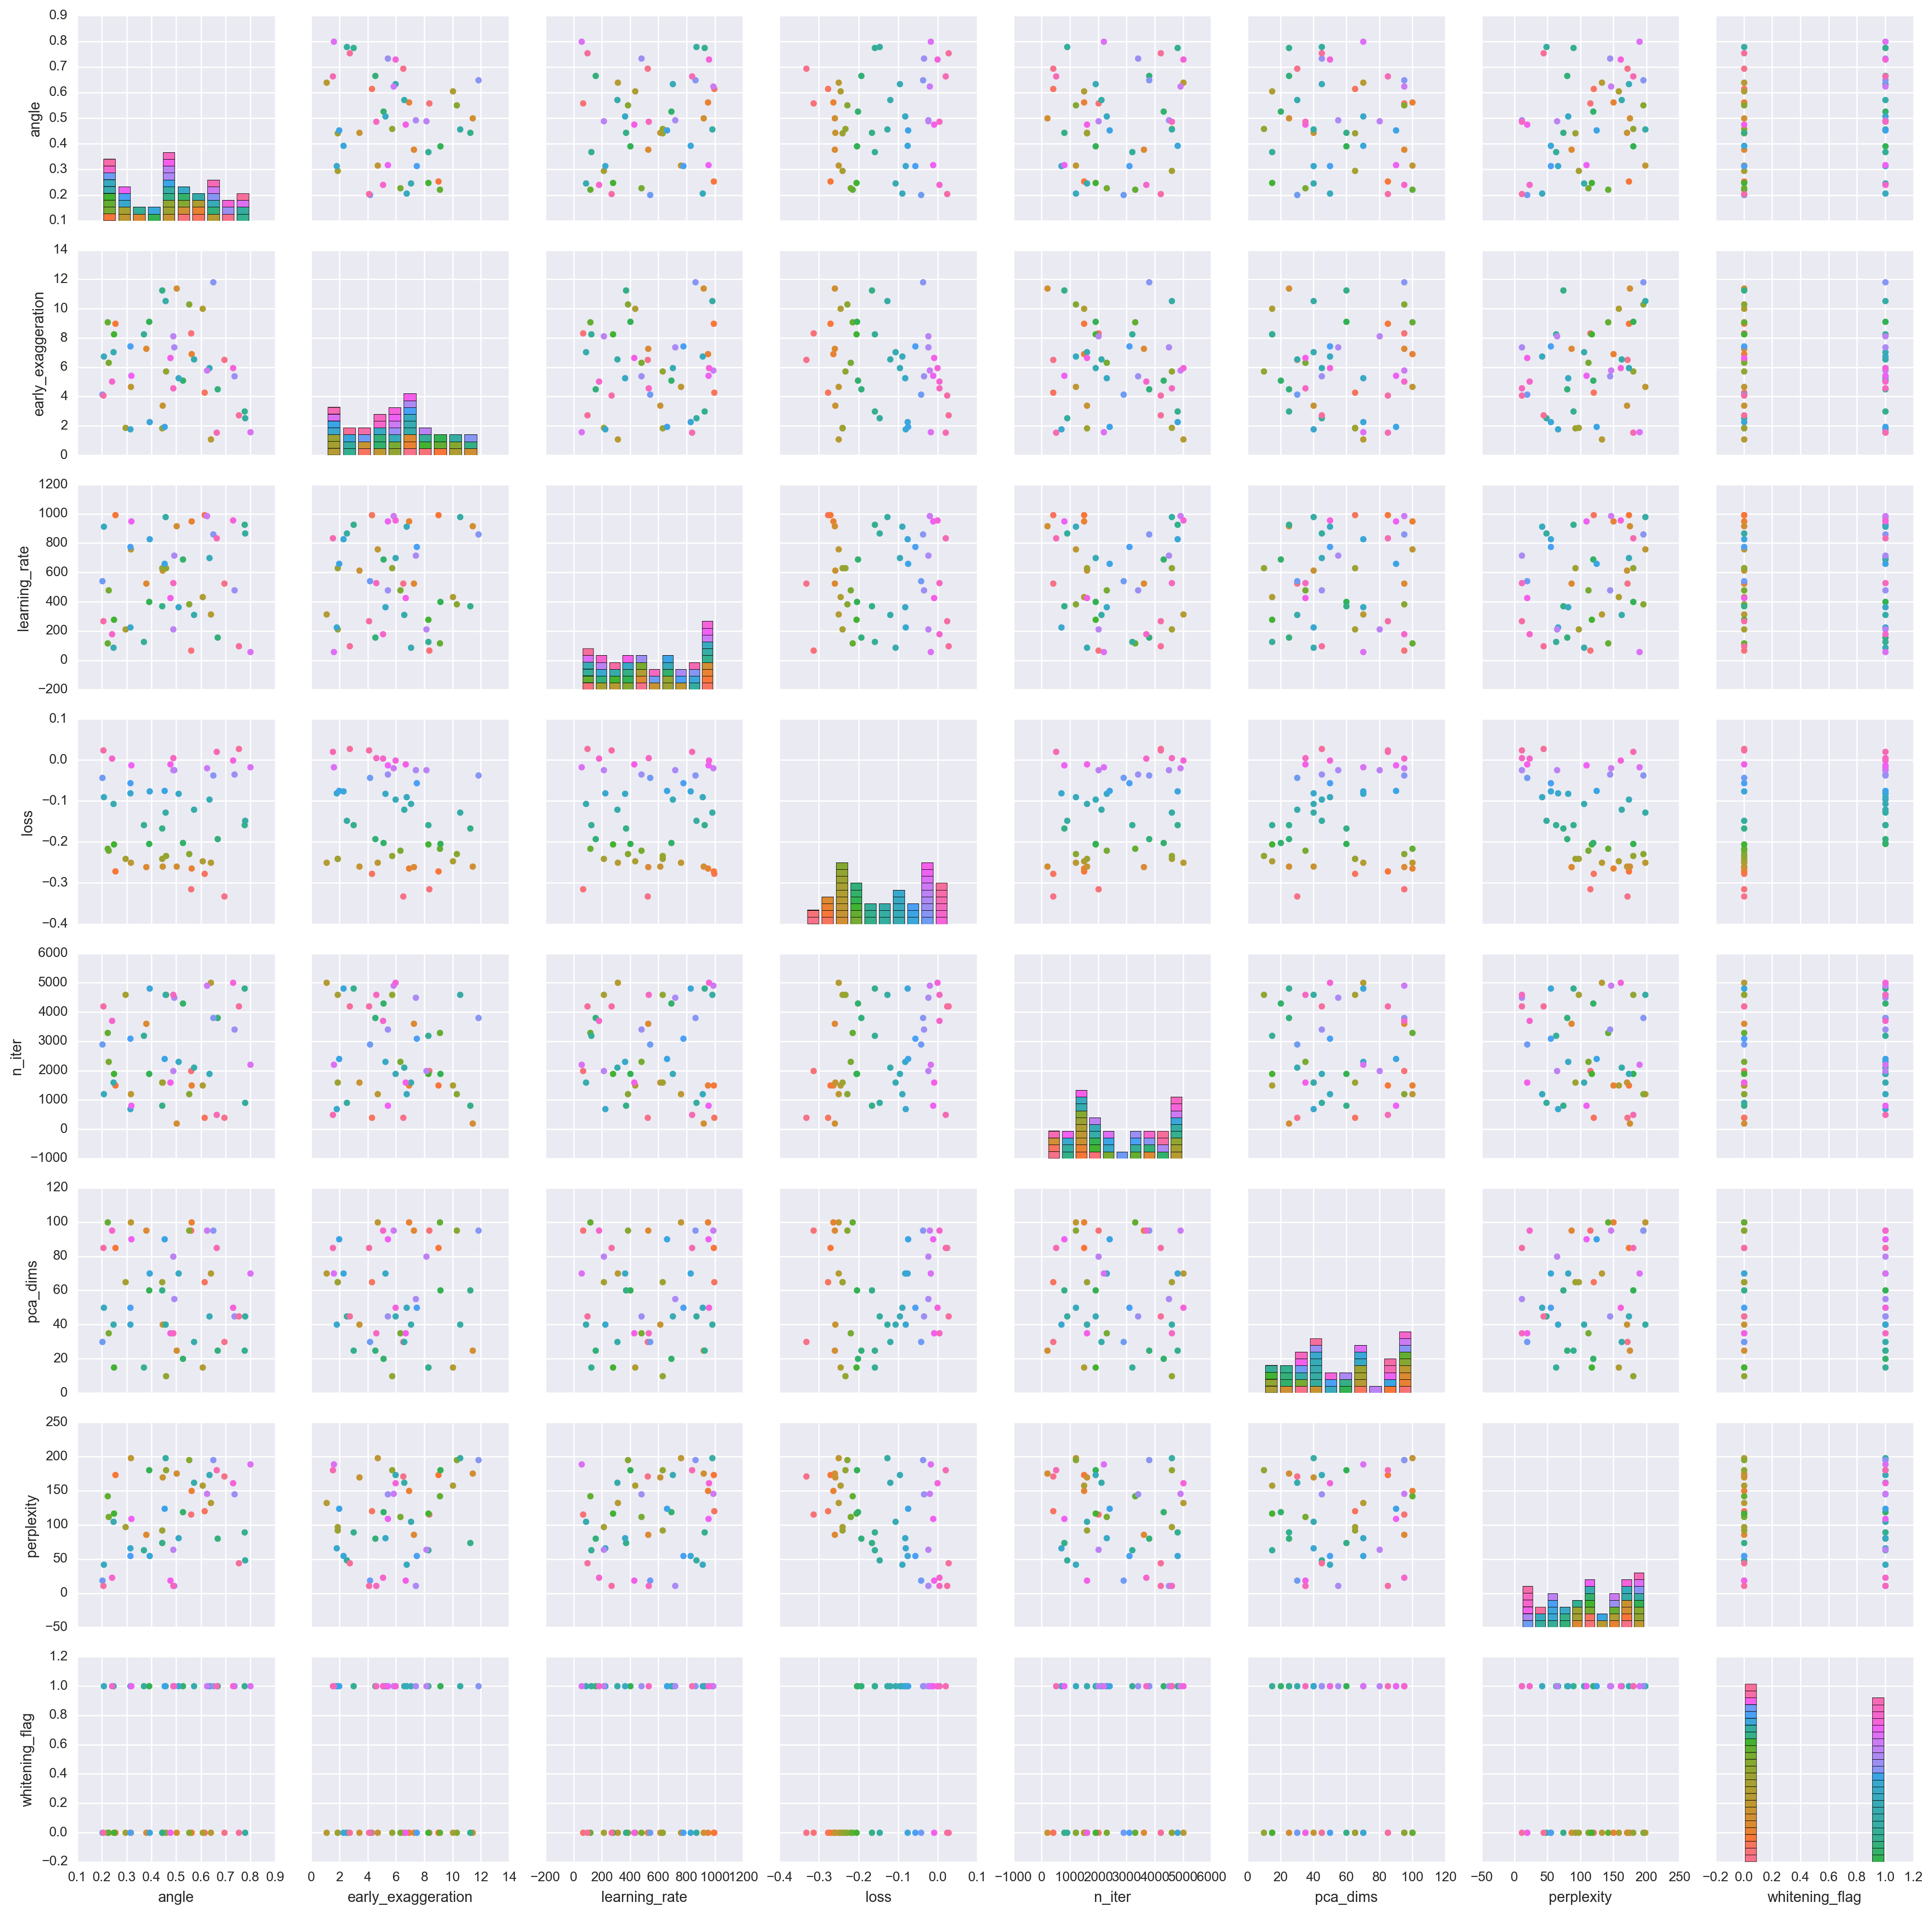

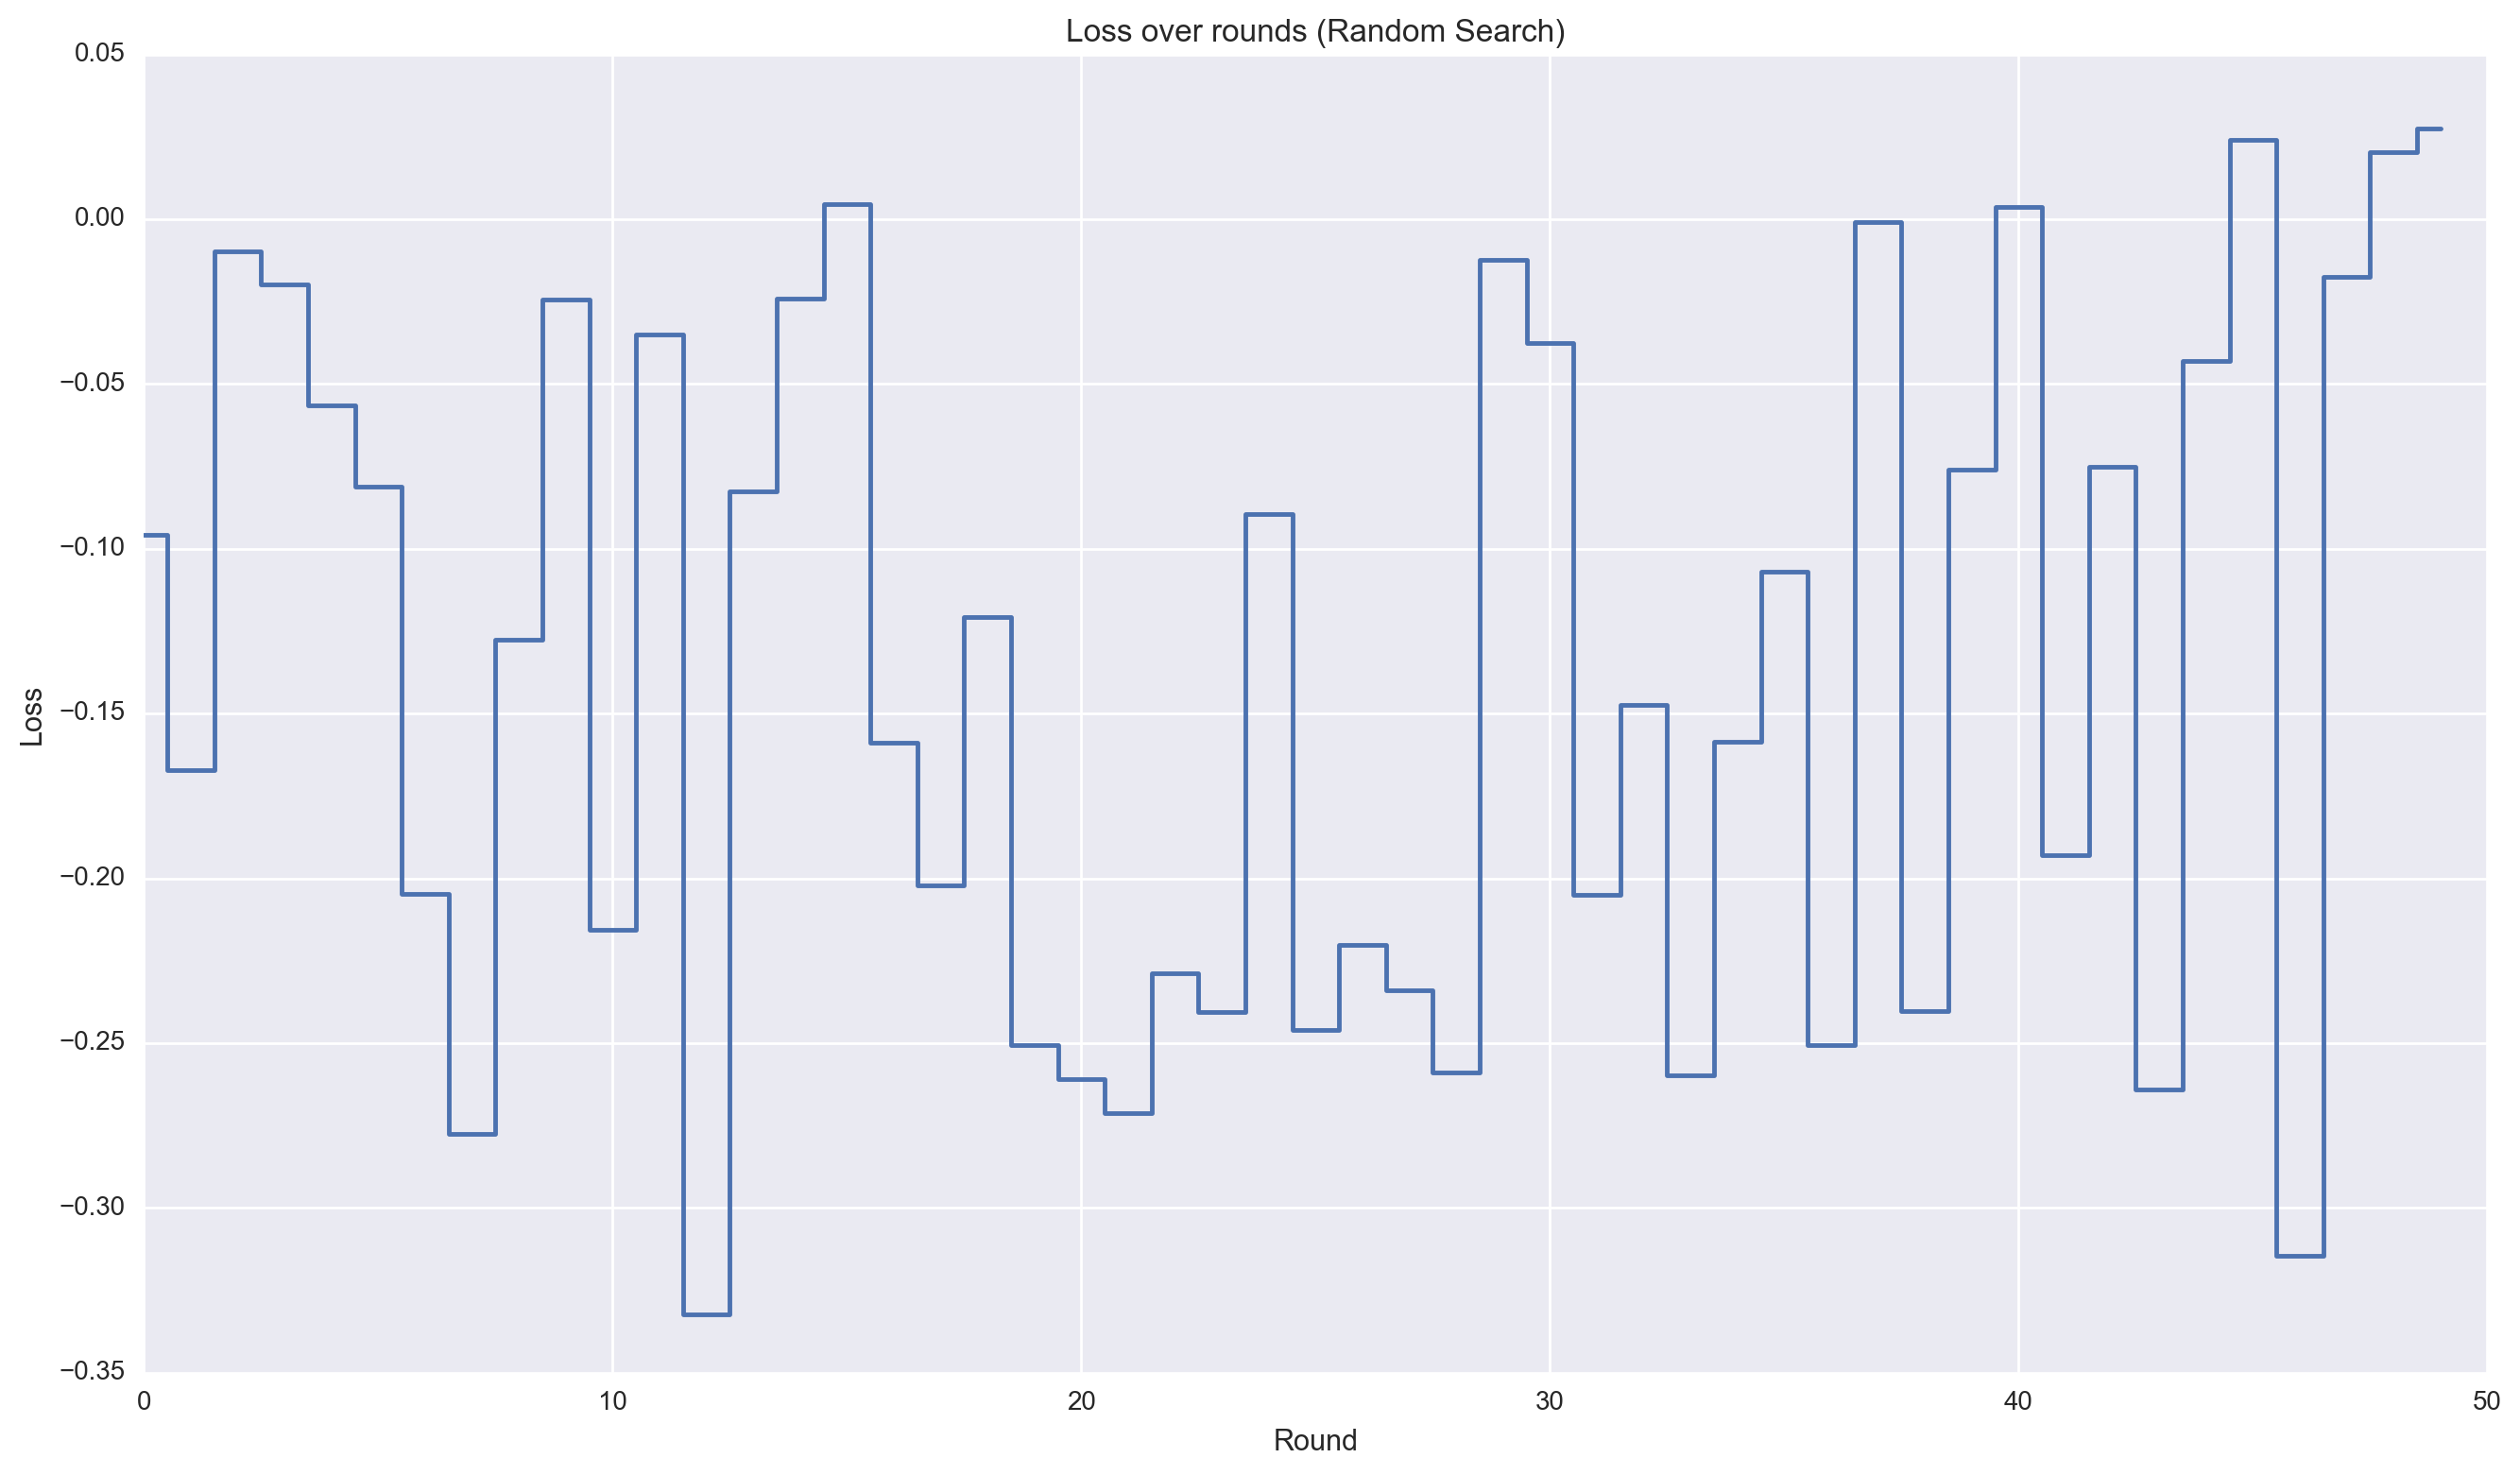

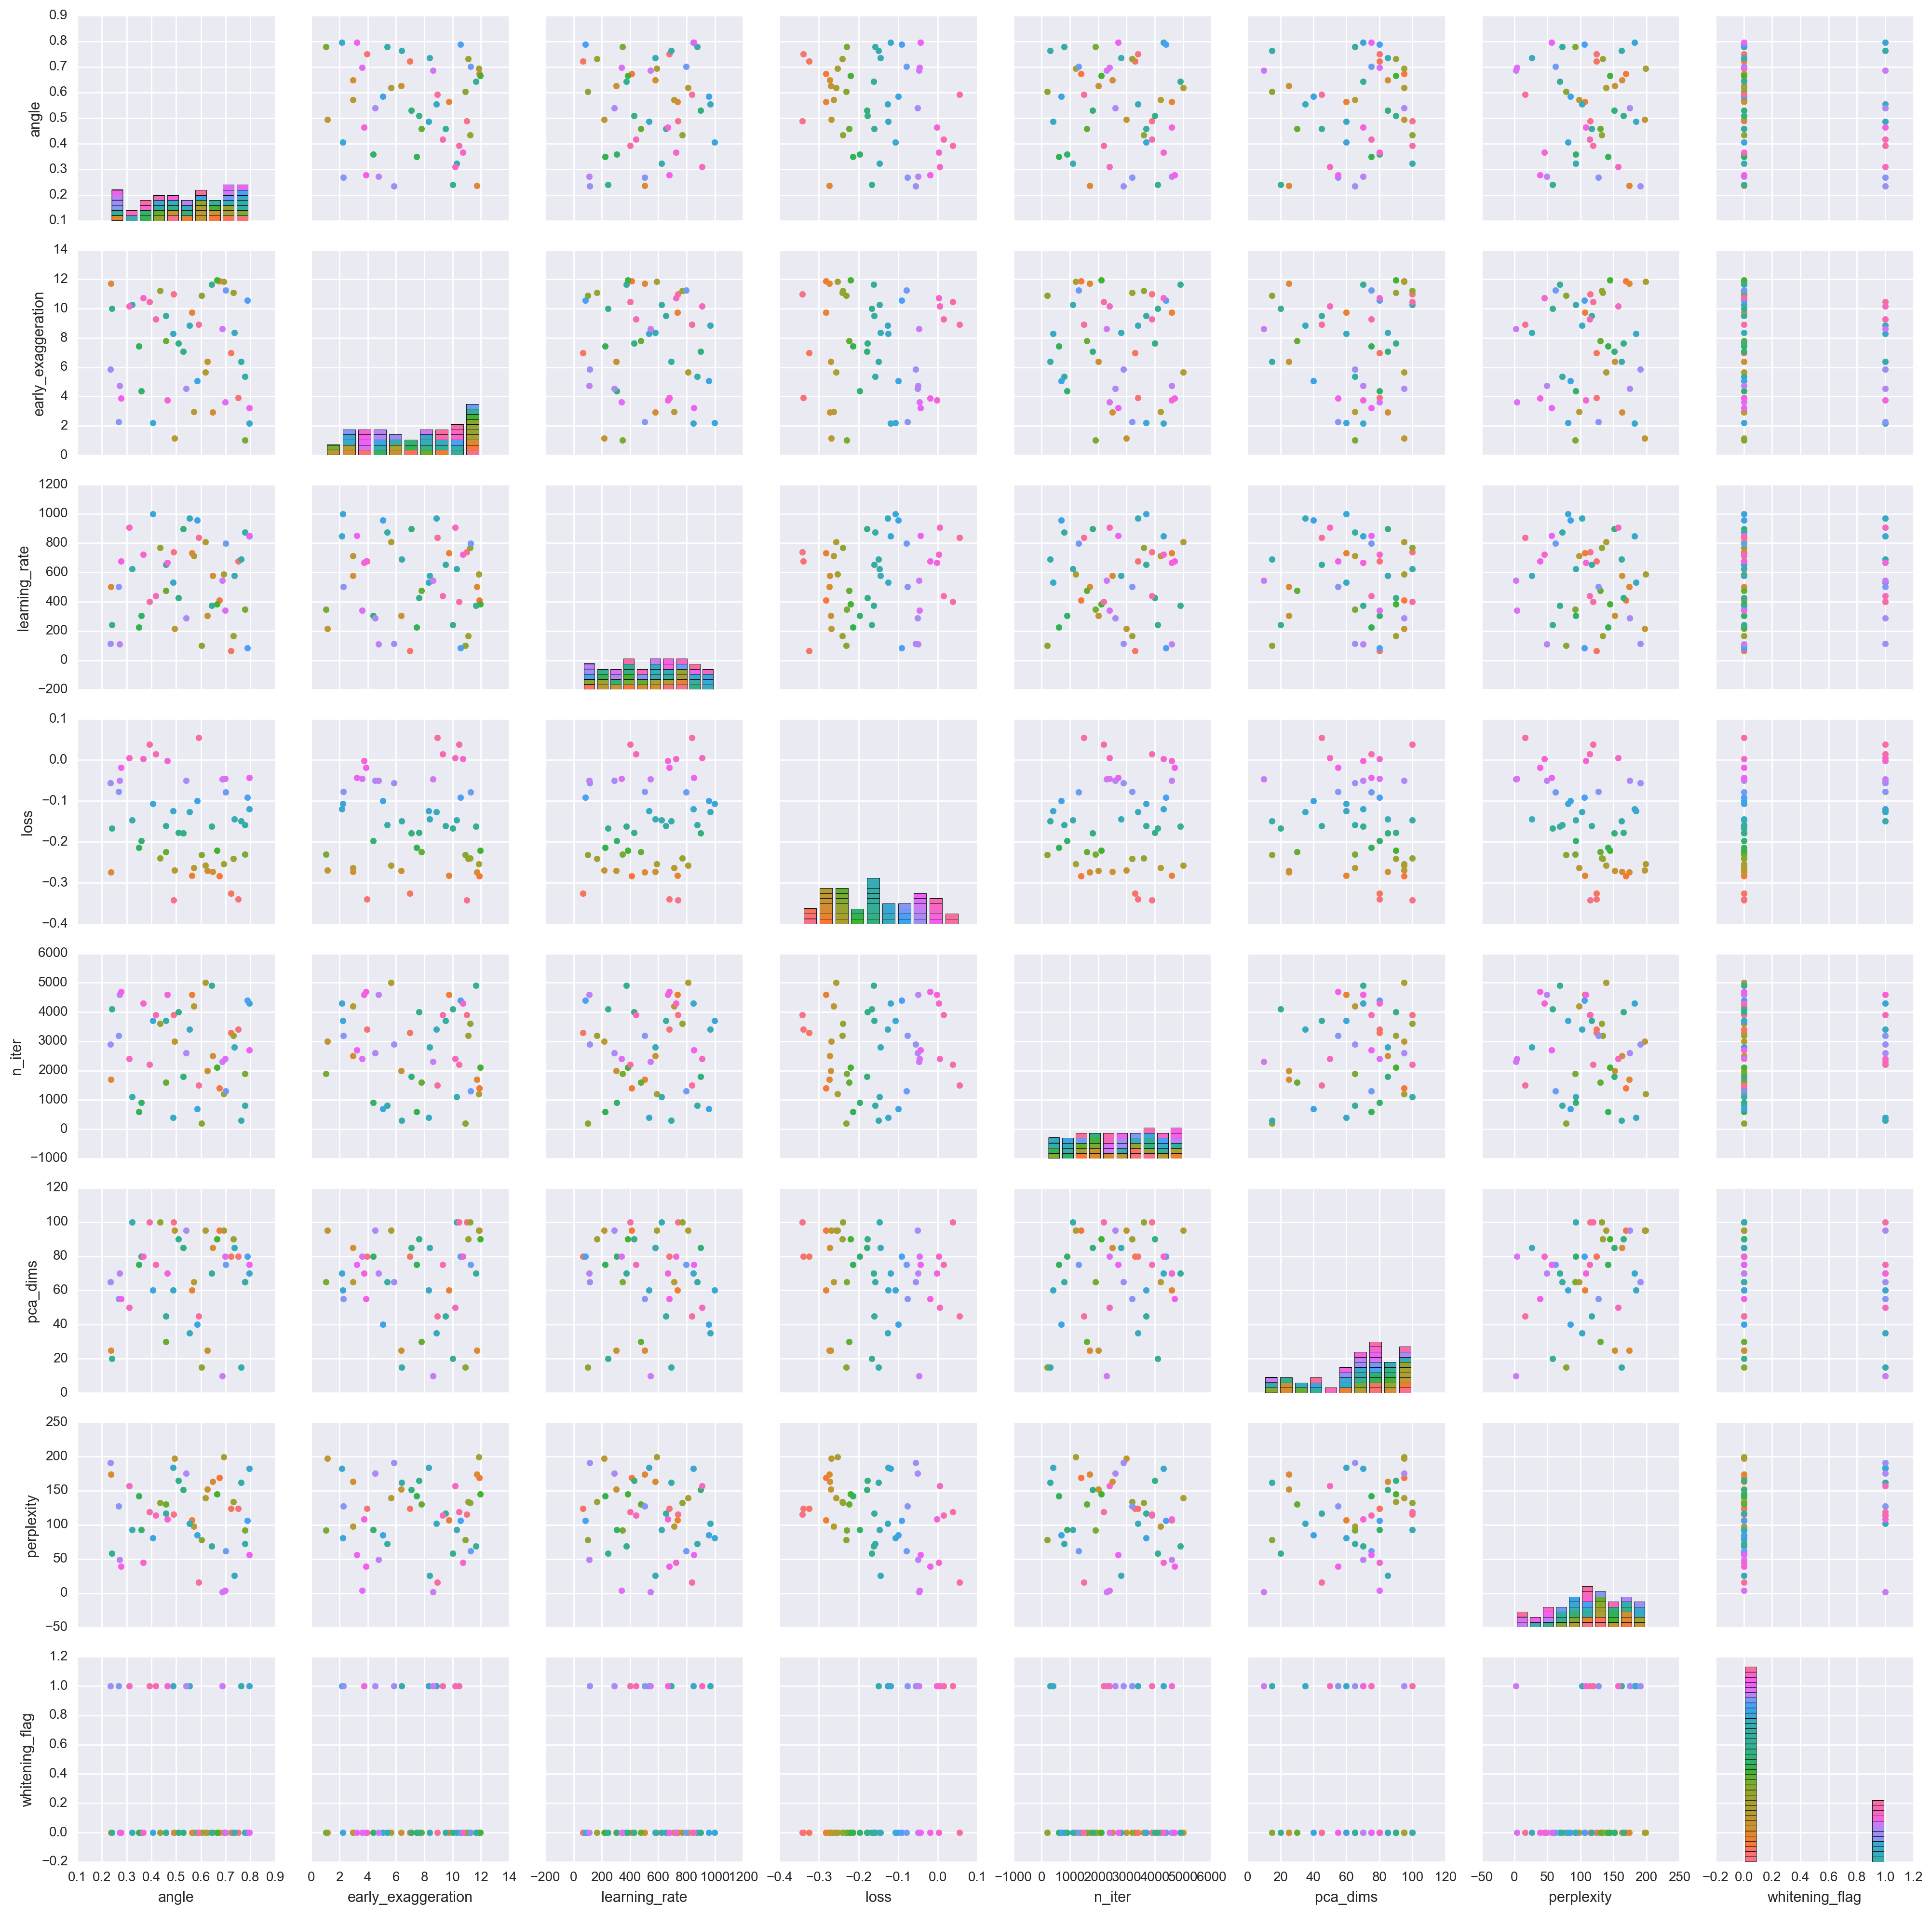

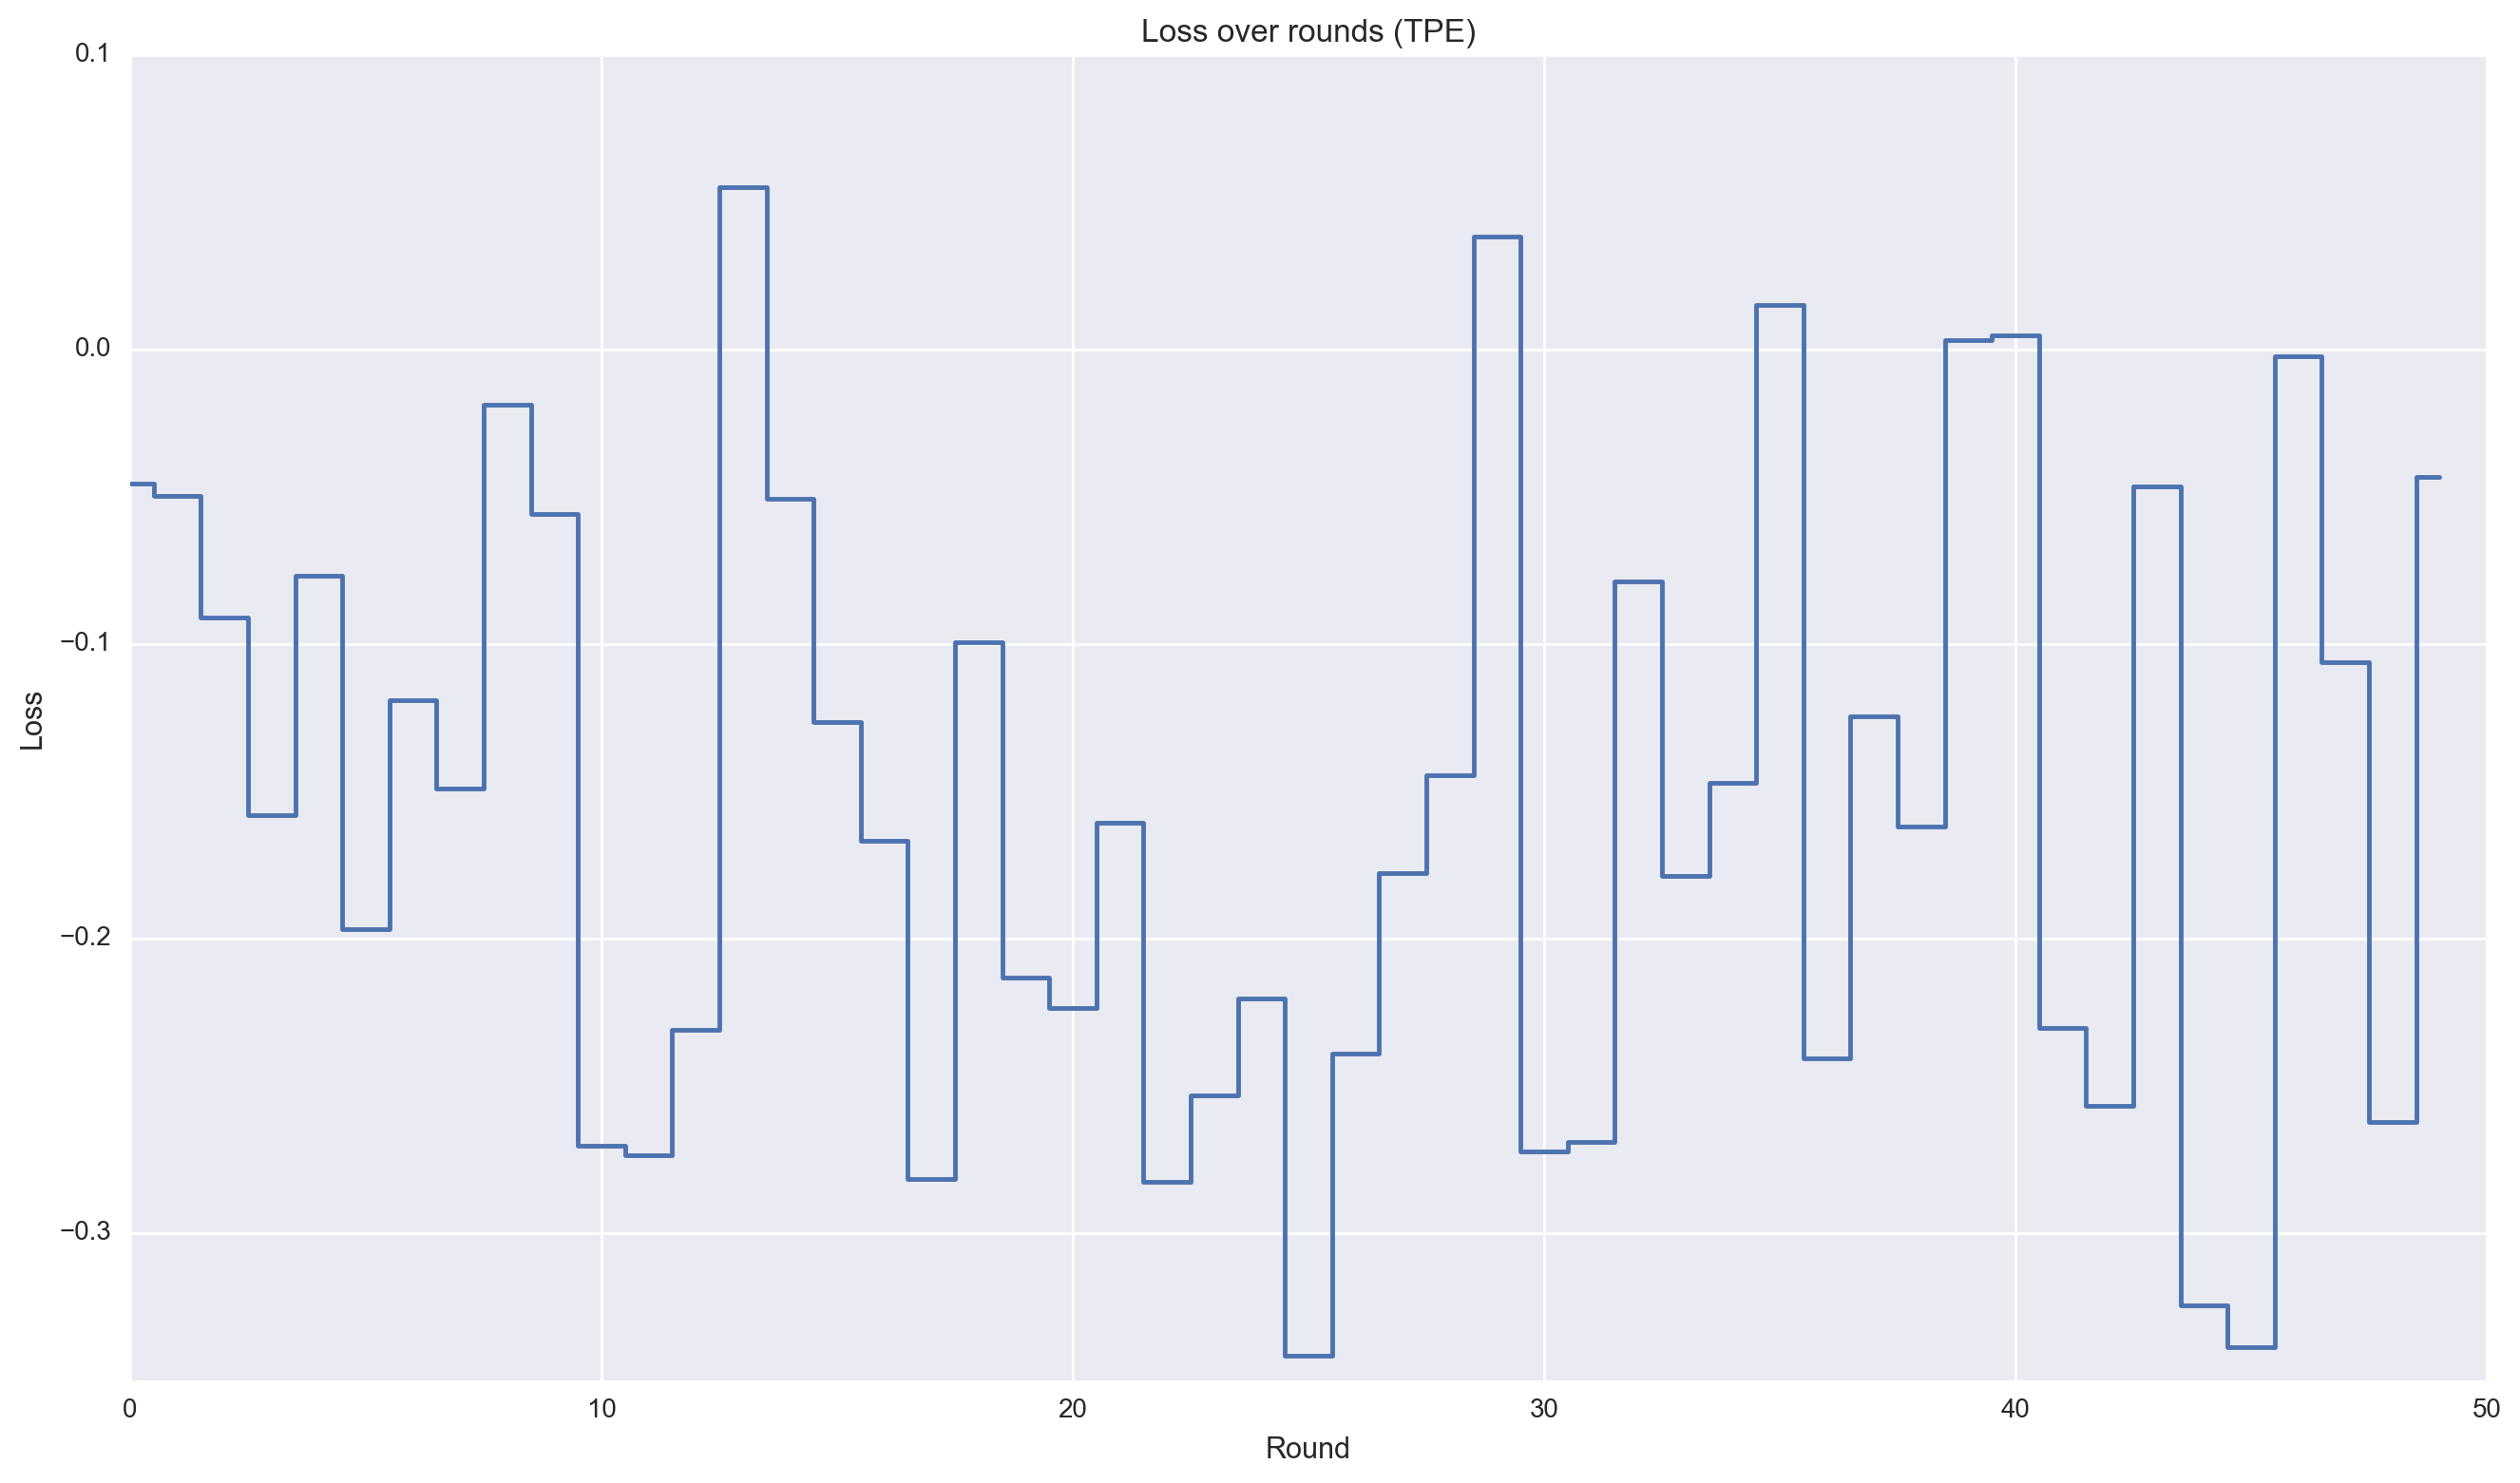

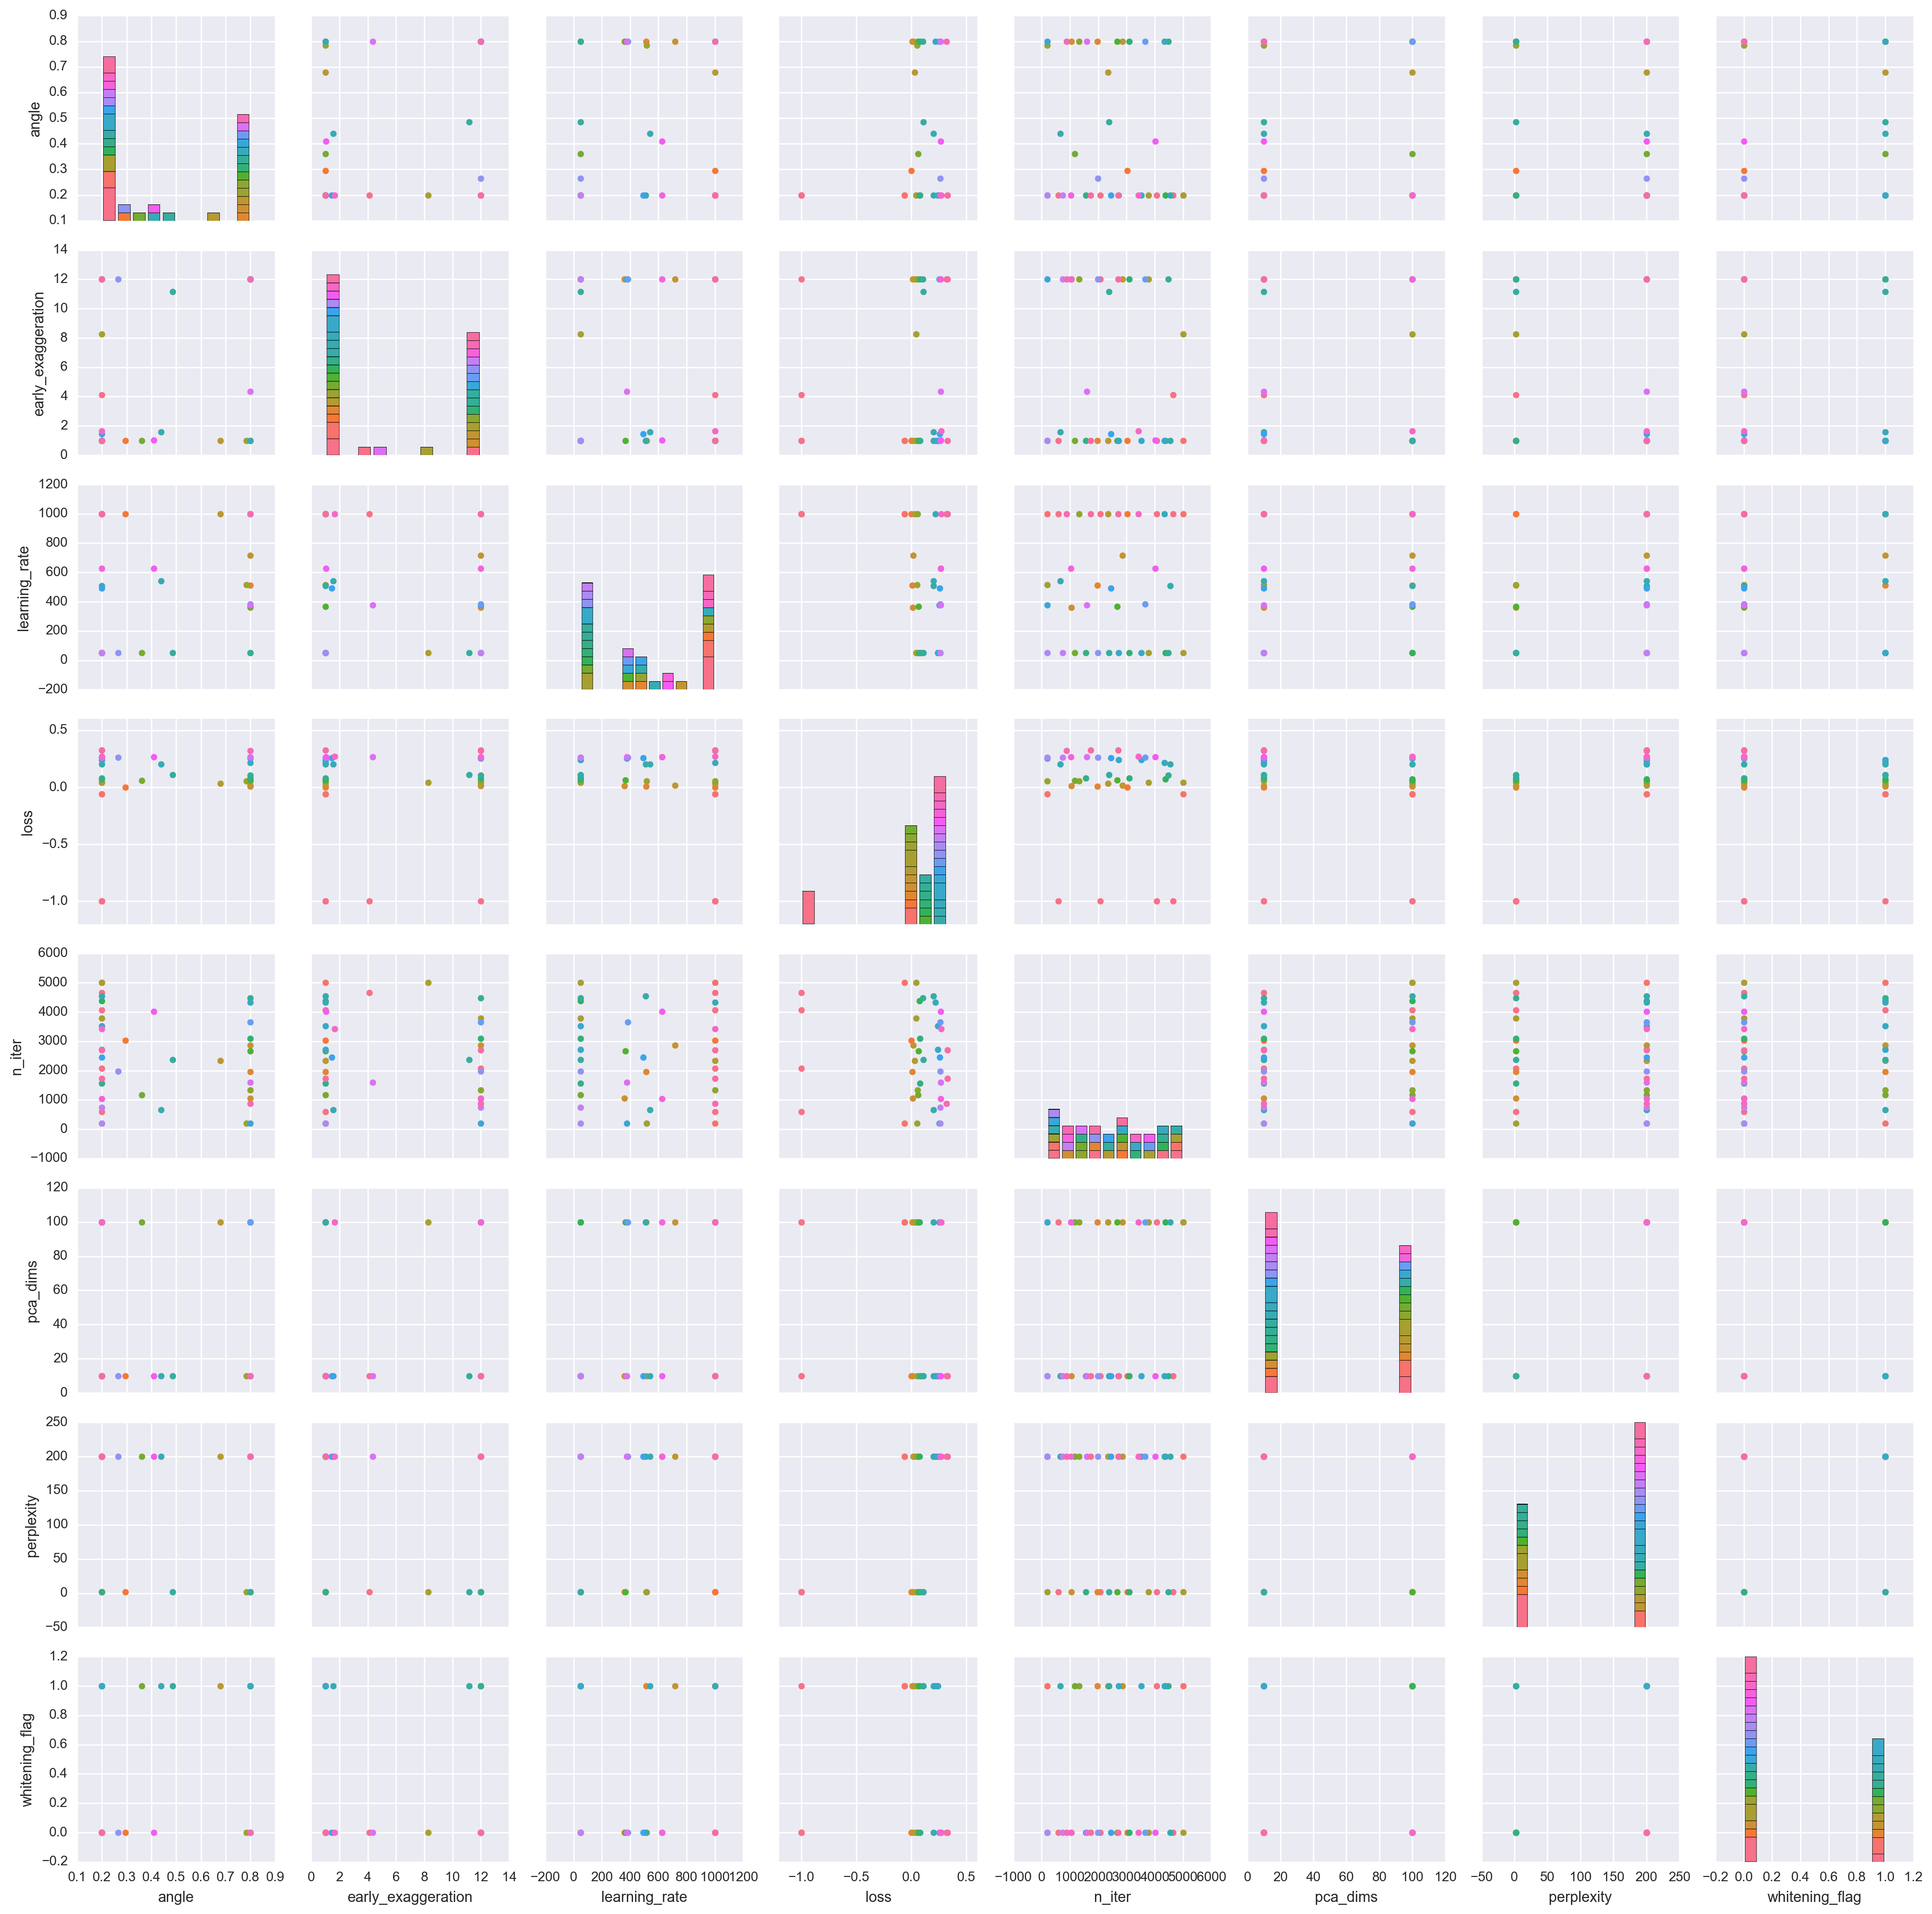

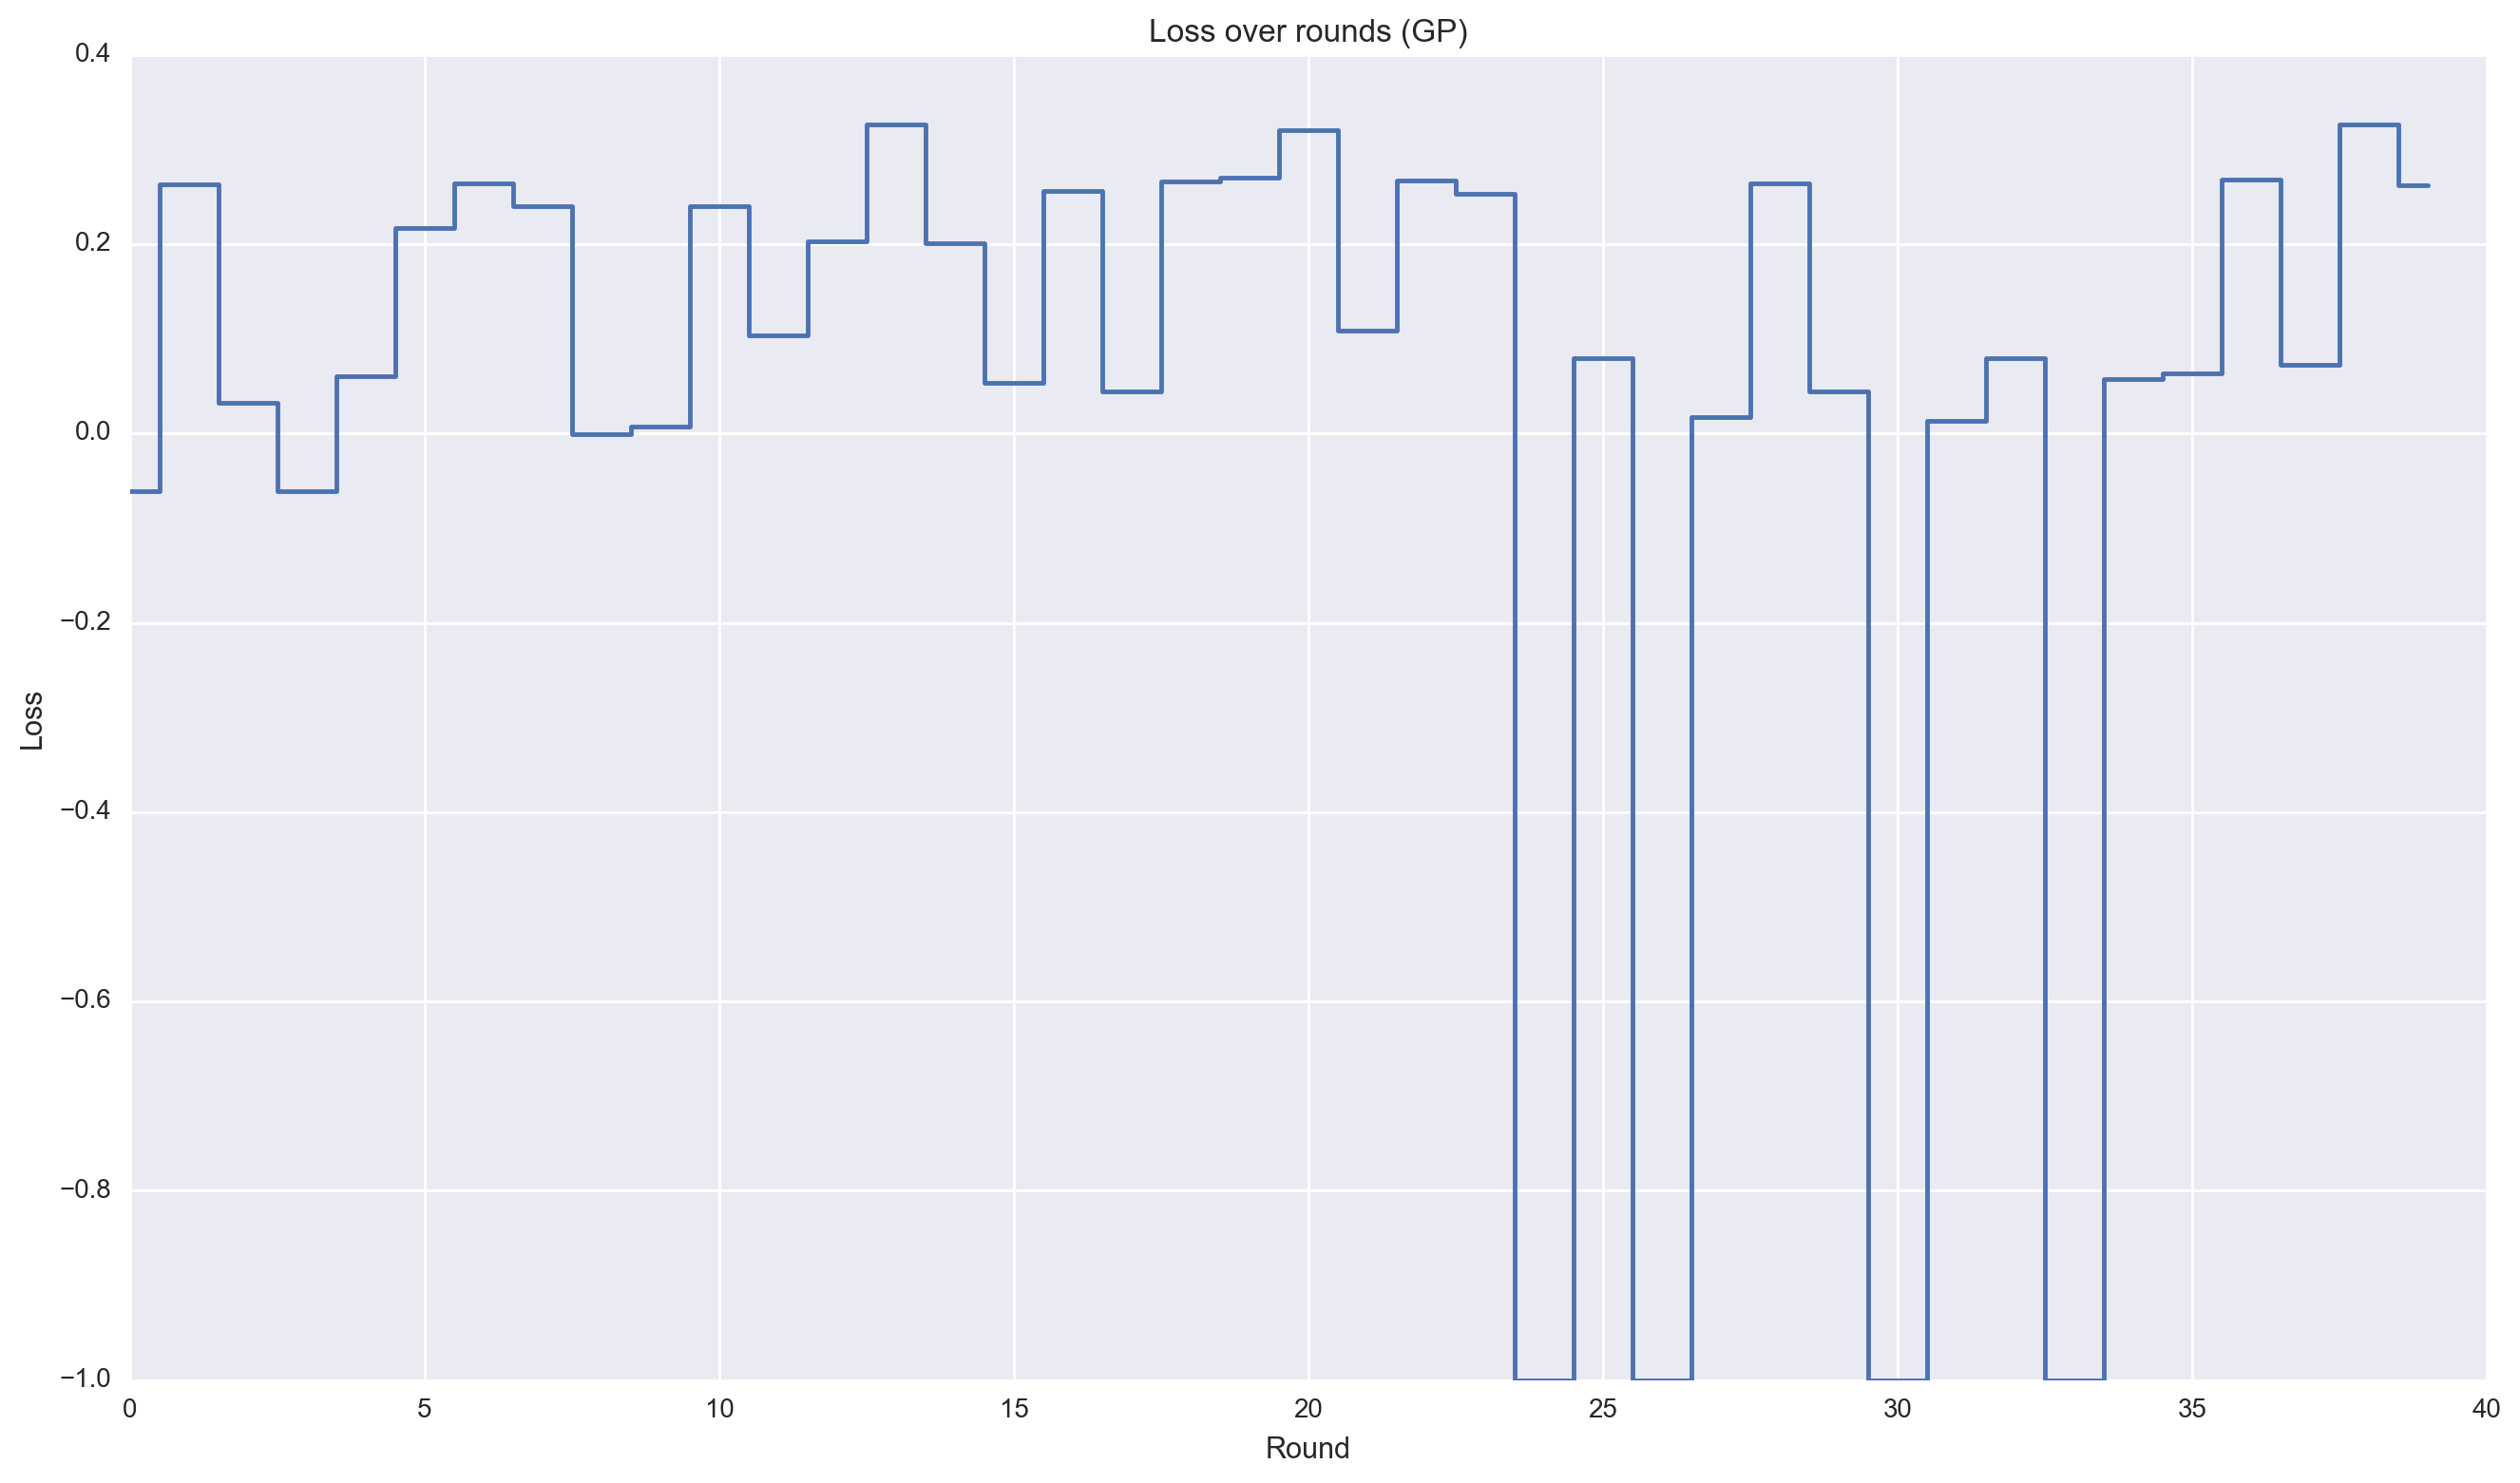

In [33]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['coil_20']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/coil_20_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/coil_20_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['coil_20']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/coil_20_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/coil_20_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['coil_20']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/coil_20_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/coil_20_gp.pdf');

In [34]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['coil_20']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['coil_20']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['coil_20']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['coil_20']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['coil_20']['gp']['values']) if e == np.max(experiment_dict['coil_20']['gp']['values'])]

Random Search best: [12]
TPE best: [25]
GP best: [13, 38]


### 4.6 Olivetti faces

Pictures of different people with small variations.

In [ ]:
# reading the data
test_df = pd.read_csv('data/final/olivetti-faces.csv')

In [ ]:
# removing target variable
test_target = test_df['TARGET']

In [ ]:
# random search #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/olivetti_rand')

# trials object stores the evaluations
trials_rand = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=rand.suggest, space=space_hp, max_evals=50, trials=trials_rand)

# storing the results
experiment_dict['olivetti']['rand'] = [trials_rand.trials[i]['result'] for i in range(len(trials_rand.trials))]

In [ ]:
# TPE #

# initializing wrapper - hyperopt
opt_task_hp = hp_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/olivetti_tpe')

# trials object stores the evaluations
trials_tpe = Trials()

# using the fmin function from hyperopt
best = fmin(fn=opt_task_hp.target, algo=tpe.suggest, space=space_hp, max_evals=50, trials=trials_tpe)

# storing the results
experiment_dict['olivetti']['tpe'] = [trials_tpe.trials[i]['result'] for i in range(len(trials_tpe.trials))]

In [ ]:
# gaussian processes #

# initializing wrapper - BayesianOptimazion
opt_task_bo = bo_wrapper(test_df, save_path='vis/rank-order-optim/all_plots/olivetti_gp')

# defining optimization object
bo = BayesianOptimization(opt_task_bo.target, space_bo, verbose=0)

# optimizing
bo.maximize(init_points=10, n_iter=40, acq='ucb', kappa=10)

# writing results
experiment_dict['olivetti']['gp'] = bo.res['all']

In [ ]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(dict_entry['loss'])
        except KeyError:
            temp_dict['loss'] = [dict_entry['loss']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = exp_dict['values']
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# random search #

# results data frame
rand_res_df = exp_dict_to_df_hp(experiment_dict['olivetti']['rand'])

# plotting hyperparameter importance
g = sns.PairGrid(rand_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/olivetti_rand.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(rand_res_df['loss'])), rand_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (Random Search)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/olivetti_rand.pdf');

# tpe #

# results data frame
tpe_res_df = exp_dict_to_df_hp(experiment_dict['olivetti']['tpe'])

# plotting hyperparameter importance
g = sns.PairGrid(tpe_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/olivetti_tpe.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(tpe_res_df['loss'])), tpe_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (TPE)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/olivetti_tpe.pdf');

# gaussian processes #

# results data frame
gp_res_df = exp_dict_to_df_bo(experiment_dict['olivetti']['gp'])

# plotting hyperparameter importance
g = sns.PairGrid(gp_res_df, hue='loss');
g.map_diag(plt.hist);
g.map_offdiag(plt.scatter);
g.savefig('vis/rank-order-optim/hyperparam_maps/olivetti_gp.pdf');

# plotting loss function evolution
fig = plt.figure(figsize=[16,9]); plt.step(range(len(gp_res_df['loss'])), gp_res_df['loss'], where='mid'); 
plt.title('Loss over rounds (GP)'); plt.xlabel('Round'); plt.ylabel('Loss'); 
fig.savefig('vis/rank-order-optim/loss_over_rounds/olivetti_gp.pdf');

In [ ]:
# showing best embedded spaces #
print "Random Search best:", [i for i,e in enumerate(experiment_dict['olivetti']['rand']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['olivetti']['rand']])]
print "TPE best:", [i for i,e in enumerate(experiment_dict['olivetti']['tpe']) if e['loss'] == np.min([e['loss'] for e in experiment_dict['olivetti']['tpe']])]
print "GP best:", [i for i,e in enumerate(experiment_dict['olivetti']['gp']['values']) if e == np.max(experiment_dict['olivetti']['gp']['values'])]

## Final Data & Plots

Let us wrap the data up for publication, with includes the generation of new plots.

In [7]:
# computing figures of the optimization process #

# function to transform the experiment dict into a data frame - hyperopt #
def exp_dict_to_df_hp(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict:

        # add parameters to dict
        for key in dict_entry['parameters'].keys():
            try:
                temp_dict[key].append(dict_entry['parameters'][key])
            except KeyError:
                temp_dict[key] = [dict_entry['parameters'][key]]

        # add loss to dict
        try:
            temp_dict['loss'].append(-1*np.array(dict_entry['loss']))
        except KeyError:
            temp_dict['loss'] = [-1*np.array(dict_entry['loss'])]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

# function to transform the experiment dict into a data frame - bayesian optim #
def exp_dict_to_df_bo(exp_dict):

    # dictionary to story intermediate values
    temp_dict = dict()

    # for each experiment
    for dict_entry in exp_dict['params']:

        # add parameters to dict
        for key in dict_entry.keys():
            try:
                temp_dict[key].append(dict_entry[key])
            except KeyError:
                temp_dict[key] = [dict_entry[key]]
    
    # adding loss
    temp_dict['loss'] = +1*np.array(exp_dict['values'])
    
    # correcting whitening_flag
    temp_dict['whitening_flag'] = [False if e < 0.50 else True for e in temp_dict['whitening_flag']]
    
    # return a data frame
    return pd.DataFrame(temp_dict)

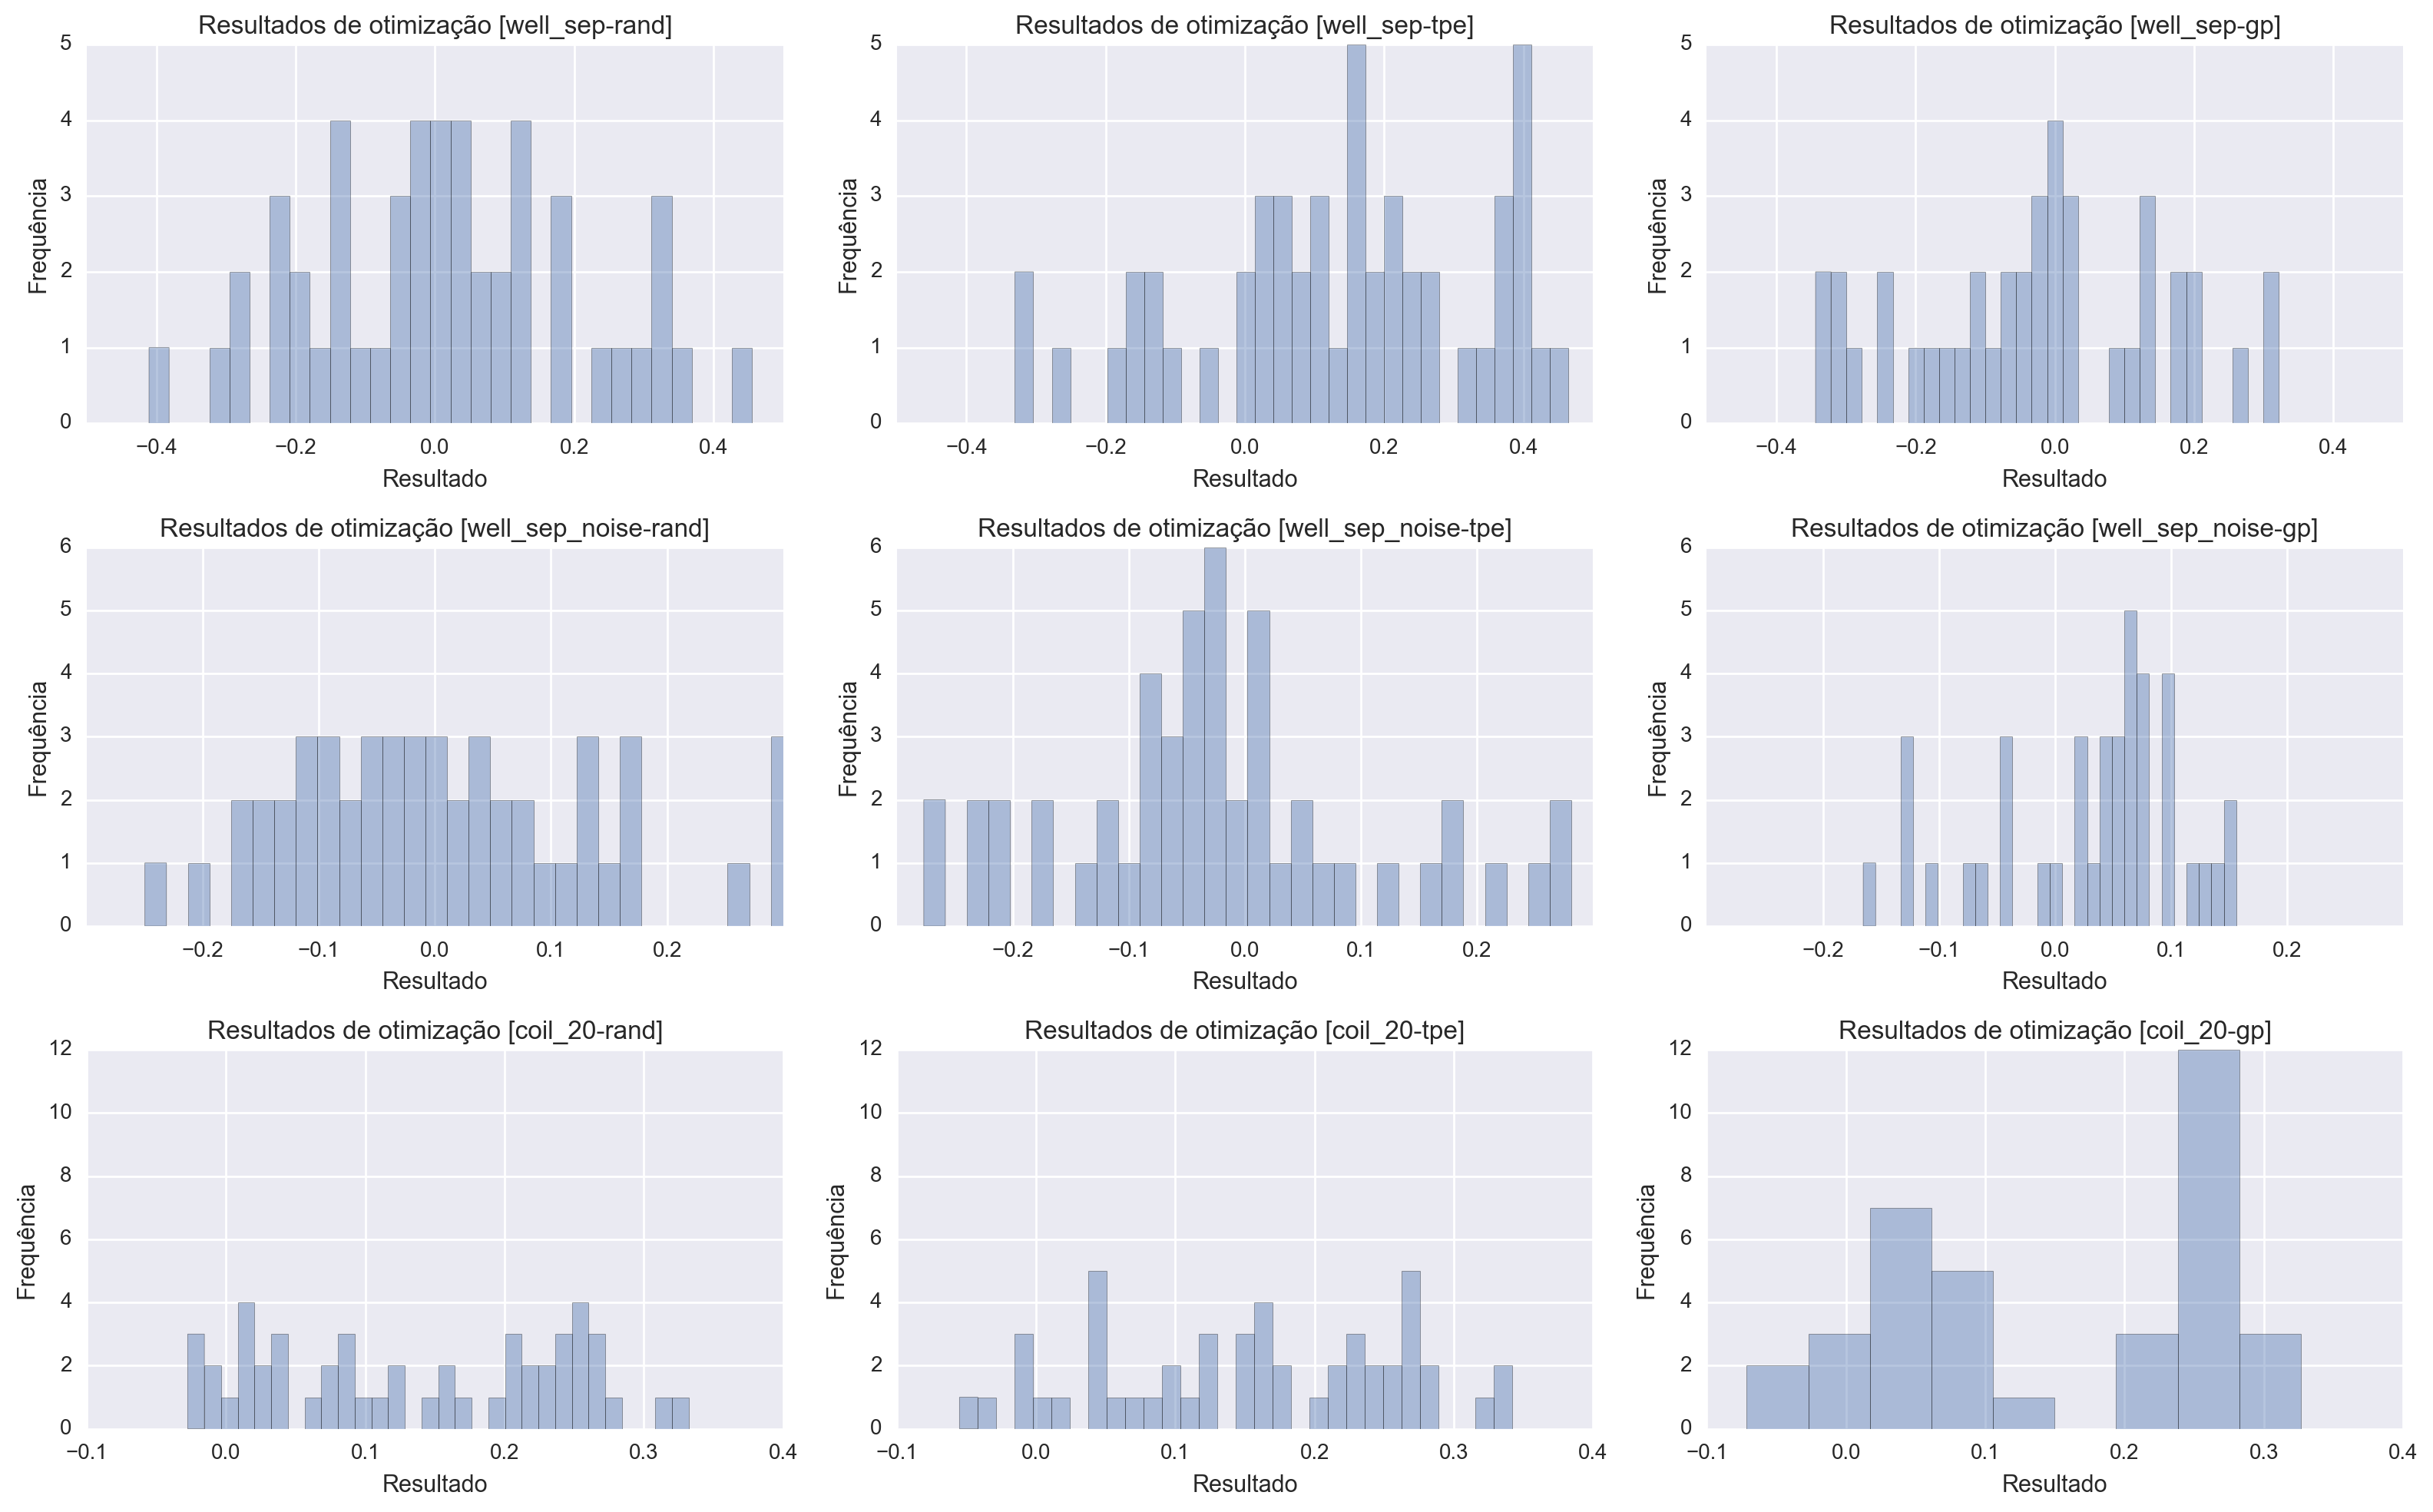

In [85]:
# opening figure
fig = plt.figure(figsize=[16,10], dpi=300)

# count variable
count = 0

# x-axis limits
x_limits = {'well_sep': [-0.5,0.5], 'well_sep_noise': [-0.3,0.3], 'coil_20': [-0.1, 0.4]}
y_limits = {'well_sep': [0.0,5.0], 'well_sep_noise': [0.0,6.0], 'coil_20': [0.0, 12.0]}

# realizing joined graphs
for dataset in ['well_sep', 'well_sep_noise', 'coil_20']:
        
    for optim in ['rand', 'tpe', 'gp']:
        
        # choosing right function 
        if optim == 'gp':

            # results data frame
            res_df = exp_dict_to_df_bo(experiment_dict[dataset][optim])            
            
        # if not gp, use hp data treting function
        else:
            
            # results data frame
            res_df = exp_dict_to_df_hp(experiment_dict[dataset][optim])

        # plotting loss function evolution
        plt.subplot(3, 3, count + 1); sns.distplot(res_df['loss'], label=optim, bins=30, kde=False); plt.tight_layout()
        plt.title(u'Resultados de otimização [{}-{}]'.format(dataset, optim)); plt.xlabel('Resultado'); plt.ylabel(u'Frequência'); 
        plt.xlim(x_limits[dataset]); plt.ylim(y_limits[dataset])
        
        # adding to count
        count += 1

In [86]:
fig.savefig('vis/rank-order-optim/loss_over_rounds/rank-order-loss-histo.pdf');

In [38]:
# max, min, mean per optimization round table
summary_df = pd.DataFrame()

# realizing joined graphs
for dataset in ['well_sep', 'well_sep_noise', 'coil_20']:
        
    for optim in ['rand', 'tpe', 'gp']:
        
        # choosing right function 
        if optim == 'gp':

            # results data frame
            res_df = exp_dict_to_df_bo(experiment_dict[dataset][optim])            
            
        # if not gp, use hp data treting function
        else:
            
            # results data frame
            res_df = exp_dict_to_df_hp(experiment_dict[dataset][optim])

        # temporary df
        temp_df = pd.DataFrame()
        temp_df.loc[:,'dataset'] = [dataset]
        temp_df.loc[:,'optim'] = [optim]
        temp_df.loc[:,'mean_loss'] = [res_df['loss'].mean()]
        temp_df.loc[:,'max_loss'] = [res_df['loss'].max()]
        temp_df.loc[:,'min_loss'] = [res_df['loss'].min()]
        
        # accumulating
        summary_df = pd.concat([summary_df, temp_df])

In [39]:
summary_df.drop('dataset', axis=1)

optim  mean_loss  max_loss  min_loss
0  rand   0.013750  0.455357 -0.410714
0   tpe   0.131250  0.464286 -0.330357
0    gp  -0.024888  0.321429 -0.343750
0  rand   0.007589  0.308036 -0.250000
0   tpe  -0.023393  0.281250 -0.276786
0    gp   0.029464  0.156250 -0.165179
0  rand   0.137164  0.332194 -0.027591
0   tpe   0.153791  0.341741 -0.054992
0    gp   0.035610  0.326673 -1.000000

In [71]:
# finding the distributions of parameters for the best experiments #

# opening figure
f = plt.figure(figsize=[9,9], dpi=300)

# accummulation dict
top5_dict = {}

# realizing joined graphs
for i, dataset in enumerate(['well_sep', 'well_sep_noise', 'coil_20']):
    
    # df for storing all the best experiments
    dataset_res_df = pd.DataFrame()
        
    for optim in ['rand', 'tpe', 'gp']:
        
        # choosing right function 
        if optim == 'gp':

            # results data frame
            res_df = exp_dict_to_df_bo(experiment_dict[dataset][optim]); res_df.loc[:,'optim'] = optim            
            
        # if not gp, use hp data treting function
        else:
            
            # results data frame
            res_df = exp_dict_to_df_hp(experiment_dict[dataset][optim]); res_df.loc[:,'optim'] = optim 
        
        # updating 
        dataset_res_df = pd.concat([dataset_res_df, res_df])
    
    # filtering top 5 trials
    top5 = dataset_res_df.sort_values('loss', ascending=False).head(5)
    top5.loc[:,'whitening_flag'] = top5.loc[:,'whitening_flag'].astype(str)
    
    # accumulating
    top5_dict[dataset] = top5.loc[:, ['loss','angle','early_exaggeration','learning_rate','n_iter','pca_dims','perplexity','whitening_flag','optim']]

In [75]:
top5_dict['well_sep']

loss     angle  early_exaggeration  learning_rate  n_iter  pca_dims  \
46  0.464286  0.268902            5.114404     849.895897  4800.0      40.0   
17  0.455357  0.216464            6.021844     623.875977  2200.0      20.0   
28  0.428571  0.202407            7.450697     422.111956  3900.0      20.0   
27  0.410714  0.212138            7.257147     433.855933  3800.0      35.0   
29  0.410714  0.219034            5.138664     456.089778  3800.0      30.0   

    perplexity whitening_flag optim  
46       178.0          False   tpe  
17       115.0          False  rand  
28       148.0          False   tpe  
27       144.0          False   tpe  
29       144.0          False   tpe

In [76]:
top5_dict['well_sep_noise']

loss     angle  early_exaggeration  learning_rate  n_iter  pca_dims  \
22  0.308036  0.671739           11.573539     420.365253  4300.0      55.0   
6   0.308036  0.478700            6.040094     533.464046  3400.0      20.0   
24  0.303571  0.596916            5.179607     649.956827  5000.0      15.0   
47  0.281250  0.573598            7.737569     661.515239  4300.0      25.0   
11  0.267857  0.279957            5.677929     797.297208  3500.0      90.0   

    perplexity whitening_flag optim  
22         8.0           True  rand  
6         50.0          False  rand  
24       153.0          False  rand  
47       183.0          False   tpe  
11       188.0           True   tpe

In [77]:
top5_dict['coil_20']

loss     angle  early_exaggeration  learning_rate       n_iter  \
25  0.341741  0.488821           11.009293     739.738076  3900.000000   
45  0.338905  0.750213            3.923351     677.629346  3400.000000   
12  0.332194  0.694643            6.510226     524.254472   400.000000   
38  0.326673  0.200000           12.000000    1000.000000  2707.292701   
13  0.326673  0.200000            1.000000    1000.000000  1734.048096   

    pca_dims  perplexity whitening_flag optim  
25     100.0       115.0          False   tpe  
45      80.0       124.0          False   tpe  
12      30.0       171.0          False  rand  
38      10.0       200.0          False    gp  
13      10.0       200.0          False    gp

In [4]:
experiment_dict = load_obj('trials/rank-order')

In [40]:
# função para salvar dicionário de experimentos
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, 0)
        
# salvando dicionário de resultados
save_obj(experiment_dict, 'trials/rank-order')

In [3]:
import pickle
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)